## Visualizations

In [46]:
import os
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def train_seq_to_idx(row, R=4):
    # Only takes into account the number of overlaps, not the order
    full_seq, train_subseq = row["train_datasets"], row["Cumulative Training"]
    
    full_seq_set = set(full_seq.split('_'))
    train_subseq_set = set(train_subseq.split('_'))
    k = len(full_seq_set.intersection(train_subseq_set))
    N = len(full_seq_set)
    return R - N + k

def latest_training(row):
    full_seq = row["Cumulative Training"]
    datasets = full_seq.split("_")
    return datasets[-1]

def tot_num_training_ds(row):
    full_seq = row["train_datasets"]
    datasets = full_seq.split("_")
    return len(datasets)

def create_df_from_dir(base_dir, experiment_dir, model_name):
    query_dir = os.path.join(base_dir, experiment_dir, model_name)
    
    df_list = []
    for root,d_names,f_names in os.walk(query_dir):
        for f in f_names:
            res_df = pd.read_csv(os.path.join(root, f))
            df_list.append(res_df)
    df = pd.concat(df_list)
    df["cum_train_idx"] = df.apply(lambda row: train_seq_to_idx(row), axis=1)
    df["Latest Training"] = df.apply(lambda row: latest_training(row), axis=1)
    df["tot_num_training_ds"] = df.apply(lambda row: tot_num_training_ds(row), axis=1)
    
    return df

#df["cum_train_idx"] = df.apply(lambda row: train_seq_to_idx(row), axis=1)
#df["Latest Training"] = df.apply(lambda row: latest_training(row), axis=1)

#df2[["Validation Set", "train_datasets", "Cumulative Training", "Latest Training", "cum_train_idx", "accuracy", "f1", "precision", "recall", "recall_con"]]
#df2.columns

####df[["Validation Set", "train_datasets", "Cumulative Training", "Latest Training", "cum_train_idx", "accuracy", "f1", "precision", "recall", "recall_con", "learning_rate"]]




In [243]:
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Circle


def lighten_color(in_hex, lighten_percent):
    in_hex = in_hex.lstrip('#')
    rgb = tuple(int(in_hex[i:i+2], 16) for i in (0, 2, 4))
    light_r, light_g, light_b = [round(val + (255 - val) * lighten_percent) for val in rgb]
    light_hex = f"#{light_r:X}{light_g:X}{light_b:X}"
    
    return light_hex

def draw_arrows(df, metric, x_pad, arrow_prox, arrow_color, y_text_pad, highlight_forward_back, in_ax):
    forward, backward = "multinli_mednli_mancon_roam", "roam_mancon_mednli_multinli"
    full_seq = (df["train_datasets"].values[0])
    line_width = 4 if ((full_seq in [forward, backward]) and highlight_forward_back) else 1
    if highlight_forward_back:
        if full_seq == forward:
            arrow_color = "#9dbda5"
        elif full_seq == backward:
            arrow_color = "#f0adad"

    for i in range(min(df.cum_train_idx), max(df.cum_train_idx)):
        x1, x2 = i, i+1
        x1_prox = x2 - (x2-x1)*arrow_prox
        x2_prox = x1 + (x2-x1)*arrow_prox
        y1, y2 = df[df["cum_train_idx"]==i][metric].values[0], df[df["cum_train_idx"]==i+1][metric].values[0]
        y1_prox = y2 - (y2-y1)*arrow_prox
        y2_prox = y1 + (y2-y1)*arrow_prox
        #in_ax.arrow(x1, y1, (x2-x1)*arrow_prox, (y2-y1)*arrow_prox, 
        #            head_width=.05, head_length=.05, facecolor='grey', edgecolor='none', length_includes_head=True, ls='--')
        #in_ax.annotate("", xy=(x1+x_pad,y1_prox), xycoords='data', xytext=(x2-x_pad,y2_prox), textcoords='data',
        in_ax.annotate("", xy=(x1_prox,y1_prox), xycoords='data', xytext=(x2_prox,y2_prox), textcoords='data',
                       arrowprops={'arrowstyle': '<|-, head_width=0.4, head_length=.6',
                                   'connectionstyle': 'arc3',
                                   'facecolor': arrow_color,
                                   'edgecolor': arrow_color,
                                   #'ls': ':',
                                   'lw': line_width})
        #latest_train = df[df["cum_train_idx"]==i+1]["Latest Training"].values[0]
        #in_ax.text((x1+x2)/2, (y1_prox+y2_prox)/2 + y_text_pad, f"+ ${latest_train}$", ha="center", va="center", transform_rotates_text=True,
        #           rotation=(np.arctan((y2_prox-y1_prox)/(x2-x1) * 180 / np.pi), size=14, color=arrow_color)
                
    return None

def calculate_data_ratios_dist(train_datasets_list, data_ratio):
    multiplier_datasets = ["multinli", "mednli", "mancon"]
    # Number of times to apply the multiplier
    ratio_multiplier = len(set(multiplier_datasets).intersection(set(train_datasets_list)))
    n_datasets = len(train_datasets_list)
    dist = np.ones(n_datasets)
    for i, dataset in enumerate(train_datasets_list):
        if dataset in multiplier_datasets:
            dist[i] = data_ratio ** ratio_multiplier
            ratio_multiplier -= 1
            
    return dist

def draw_pie_scatter(df, metric, ds_color_map, background_color, combined_color, size, in_ax, is_combined=False):
        
    num_ft_datasets = max(df.cum_train_idx)
    lowest_train_idx = min(df.cum_train_idx)
    for i in range(lowest_train_idx, num_ft_datasets+1): 
        curr_df = df[df["cum_train_idx"]==i]
        train_so_far = curr_df["Cumulative Training"].values[0]
        all_train_datasets = curr_df["train_datasets"].values[0].split("_")
        
        xpos, ypos = i, curr_df[metric].values[0]
    
        # for incremental pie slices
        data_ratio = curr_df["data_ratios"].values[0]
        dist = calculate_data_ratios_dist(all_train_datasets, data_ratio)
        cumsum = np.cumsum(dist)
        cumsum = cumsum/ cumsum[-1]
        pie = [0] + cumsum.tolist()

        for j, (r1, r2) in enumerate(zip(pie[:-1], pie[1:])):
                        
            train_j = all_train_datasets[j]
            if train_j in train_so_far:
                color = ds_color_map[train_j]
            else:
                color = background_color
            
            angles = np.pi / 2 - np.linspace(2 * np.pi * r1, 2 * np.pi * r2, num=25)
            
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()
            
            xy = np.column_stack([x, y])
            
            if is_combined:
                in_ax.scatter([xpos], [ypos], marker=xy, s=size*2.25, color=combined_color, zorder=9)  # Drawing the border
                in_ax.scatter([xpos], [ypos], marker=xy, s=size, color=color, zorder=10)

            else:
                in_ax.scatter([xpos], [ypos], marker=xy, s=size*1.1, color="black")  # Drawing the border
                in_ax.scatter([xpos], [ypos], marker=xy, s=size, color=color)
                
    return None

def draw_custom_legends(df, ds_color_map, ds_name_map, background_color, combined_color, val_ds, val_color, in_ax, show_combined=False):
    # Train legend
    ds_names = list(ds_color_map.keys())[:4]
    ds_names_nice = [ds_name_map[ds] for ds in ds_names]
    custom_lines = [Line2D([0], [0], color='white', marker='o', markerfacecolor=ds_color_map[ds], markeredgecolor=background_color, markersize=15) for ds in ds_names]
    
    if show_combined:
        combined_line = Line2D([0], [0], color='white', marker='o', markerfacecolor="white", markeredgecolor=combined_color, markersize=19)
        custom_lines.append(combined_line)
        ds_names_nice.append("Combined")
    
    in_ax.legend(custom_lines, ds_names_nice)#, title='Training\n')#, title_fontproperties={'weight':'bold'})
    #train_legend = plt.legend(custom_lines, [ds_name_map[ds] for ds in list(ds_color_map.keys())[:4]], loc='upper left')
    #in_ax.add_artist(train_legend)

    # Val legend
    #custom_patch = [Patch(facecolor=val_color, edgecolor='gray')]
    #in_ax.legend(custom_patch, [ds_name_map[val_ds]], loc='upper right')
    #val_legend = plt.legend(custom_patch, [ds_name_map[val_ds]], loc='upper right')
    #in_ax.add_artist(val_legend)
    
    return None

def get_seq_plot_order(in_df, metric):
    #seqs = set(in_df["train_datasets"])
    #num_ds_in_seq = {seq: len(seq.split("_")) for seq in seqs}
    #ordered_num_ds_in_seq = {k: v for k, v in sorted(num_ds_in_seq.items(), key=lambda item: item[1])}
    #return list(ordered_num_ds_in_seq.keys())
    
    # Order by performance metric
    seq_final_metrics = dict(in_df.groupby("train_datasets")[metric].max())
    ordered_final_metrics = {k: v for k, v in sorted(seq_final_metrics.items(), key=lambda item: item[1])}
    return list(ordered_final_metrics.keys())



In [216]:
# Matplotlib parameters

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Helvetica",
    "font.family": "normal",
    "font.size": 22
})

SMALL_SIZE = 22
MEDIUM_SIZE = 28
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [323]:
from collections import OrderedDict


def draw_pie_seq_plot(root, experiment, model, metrics_to_vis, highlight_forward_back=False):
    
    # Color and name parameters
    dataset_color_map = OrderedDict({"multinli": "#D81B74", "mednli": "#FFC107", "mancon": "#52CC62", "roam": "#1E88E5", "roamDD": "#1E88E5", "roamPH": "#1E88E5", "roamDDPH": "#1E88E5"})
    dataset_name_map = OrderedDict({"multinli": "MultiNLI", "mednli": "MedNLI", "mancon": "ManCon", "roam": "Roam", "roamDD": "RoamDD", "roamPH": "RoamPH", "roamDDPH": "RoamDDPH"})
    model_name_map = OrderedDict({"roberta": "RoBERTa", "pubmedbert": "PubMedBERT", "biobert": "BioBERT", "scibert": "SciBERT", "bioclinbert": "BioClinBERT"})
    background_color = "#adacac"
    combined_color = "#964B00"
    arrow_color = '#cccaca'

    # Nice names for metrics, model
    metrics = OrderedDict({"accuracy": "Accuracy",
                           "f1": "Macro F1",
                           "precision": "Precision",
                           "recall": "Recall",
                           "recall_con": "Contradictions Recall"})

    df = create_df_from_dir(root, experiment, model)

    # Set of metrics to visualize
    #metrics_to_vis = metrics.keys()

    for lr in set(df["learning_rate"]):
        # Get the dataframe for each learning rate
        sub_df = df[df["learning_rate"] == lr]

        # Plot a row of figures, one per val set
        for val_set, val_set_official in dataset_name_map.items():

            # Create a row of figures, one per metric
            if len(metrics_to_vis) == 5:
                fig, axs = plt.subplots(1, len(metrics_to_vis), figsize=(28,6))
            else:
                fig, axs = plt.subplots(1, len(metrics_to_vis), figsize=(20, 10))
            fig.tight_layout(pad=3.0)
            fig.suptitle(f'Model: {model_name_map[model]}, Validation Set: {val_set_official}, $lr$ = {lr}', y=1.07)

            # Create the subset of the DF for this val set
            in_df = sub_df[sub_df["Validation Set"] == val_set]
            val_color = lighten_color(dataset_color_map[val_set], 0.95)

            # Create a panel for each metric
            for i, metric in enumerate(metrics_to_vis):

                # Some parameters for each panel
                axs[i].set_ylim([-.05,1.075])
                axs[i].set_title(metrics[metric])
                axs[i].set_facecolor(val_color)
                axs[i].xaxis.set_ticks(np.arange(1,5))
                axs[i].set_xticklabels('')
                axs[i].yaxis.set_ticks(np.arange(0,1.1,.1))
                
                # If there are multiple data ratios present, need to iterate through both
                for data_ratio in set(in_df.data_ratios):
                    
                    in_df_ratio = in_df[in_df.data_ratios == data_ratio]

                    # Plot individual sequences on each panel
                    for seq in get_seq_plot_order(in_df_ratio, metric):          

                        # Filter in the subset of results relevant for this sequence
                        seq_df_all = in_df_ratio[in_df_ratio["train_datasets"] == seq]
                        seq_df_combined = seq_df_all[seq_df_all['train_prep_experiment'] == "combined"]
                        found_combined = len(seq_df_combined) > 0
                        seq_df = seq_df_all[seq_df_all['train_prep_experiment'] == "sequential"]

                        # Draw my custom pie scatter plot
                        draw_pie_scatter(seq_df, metric=metric, ds_color_map=dataset_color_map, background_color=background_color, combined_color=combined_color, size=1250, in_ax=axs[i])
                        if found_combined:
                            draw_pie_scatter(seq_df_combined, metric=metric, ds_color_map=dataset_color_map, background_color=background_color, combined_color=combined_color, size=1250, is_combined=found_combined, in_ax=axs[i])
                        # Draw arrows between pies
                        draw_arrows(seq_df, metric=metric, x_pad=0, arrow_prox=.89, arrow_color=arrow_color, y_text_pad=.05, highlight_forward_back=highlight_forward_back, in_ax=axs[i])
                        # Draw legend for the left-most panel

                combined_in_panel = "combined" in set(in_df.train_prep_experiment)
                if i == 0:
                    draw_custom_legends(in_df, ds_color_map=dataset_color_map, ds_name_map=dataset_name_map, background_color=background_color, combined_color=combined_color, val_ds=val_set, val_color=val_color, show_combined=combined_in_panel, in_ax=axs[i])

            # Display this row of figs
            plt.show()

            #break
        #break
    return df, in_df # DELETE SECOND RETURN


In [232]:
def get_seq_plot_order(in_df):
    seqs = set(in_df["train_datasets"])
    num_ds_in_seq = {seq: len(seq.split("_")) for seq in seqs}
    ordered_num_ds_in_seq = {k: v for k, v in sorted(num_ds_in_seq.items(), key=lambda item: item[1])}
    return list(ordered_num_ds_in_seq.keys())

get_seq_plot_order(in_df)

['roam',
 'mednli',
 'mancon',
 'multinli',
 'mancon_roam',
 'mednli_mancon',
 'multinli_mednli',
 'multinli_mednli_mancon',
 'mednli_mancon_roam',
 'multinli_mednli_mancon_roam']

In [236]:
in_df[in_df.train_datasets == "multinli_mednli_mancon"]

,accuracy,f1,precision,recall,recall_con,Cumulative Training,Validation Set,train_datasets,eval_datasets,epochs,...,truncation,train_prep_experiment,data_ratios,SEED,mancon_neutral_frac,mancon_train_frac,wandb_log_interval,cum_train_idx,Latest Training,tot_num_training_ds
5,0.0,0.0,0.0,0.0,-1.0,none_multinli,roamDDPH,multinli_mednli_mancon,multinli_mednli_mancon_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,2,multinli,3
11,0.0,0.0,0.0,0.0,-1.0,none_multinli_mednli,roamDDPH,multinli_mednli_mancon,multinli_mednli_mancon_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,3,mednli,3
17,0.0,0.0,0.0,0.0,-1.0,none_multinli_mednli_mancon,roamDDPH,multinli_mednli_mancon,multinli_mednli_mancon_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,4,mancon,3


In [242]:
dict(in_df.groupby("train_datasets")["f1"].max())

{'mancon': 0.0148148148148148,
 'mancon_roam': 0.1428571428571428,
 'mednli': 0.0,
 'mednli_mancon': 0.0,
 'mednli_mancon_roam': 0.1538461538461538,
 'multinli': 0.0555555555555555,
 'multinli_mednli': 0.0,
 'multinli_mednli_mancon': 0.0,
 'multinli_mednli_mancon_roam': 0.0,
 'roam': 0.201058201058201}

In [238]:
in_df

,accuracy,f1,precision,recall,recall_con,Cumulative Training,Validation Set,train_datasets,eval_datasets,epochs,...,truncation,train_prep_experiment,data_ratios,SEED,mancon_neutral_frac,mancon_train_frac,wandb_log_interval,cum_train_idx,Latest Training,tot_num_training_ds
5,0.000000,0.000000,0.000000,0.000000,-1.0,none_mednli,roamDDPH,mednli_mancon_roam,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,2,mednli,3
11,0.000000,0.000000,0.000000,0.000000,-1.0,none_mednli_mancon,roamDDPH,mednli_mancon_roam,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,3,mancon,3
17,0.181818,0.153846,0.500000,0.090909,-1.0,none_mednli_mancon_roam,roamDDPH,mednli_mancon_roam,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,4,roam,3
3,0.431818,0.201058,0.333333,0.143939,-1.0,none_roam,roamDDPH,roam,roam_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,4,roam,1
4,0.045455,0.028986,0.333333,0.015152,-1.0,none_mancon,roamDDPH,mancon_roam,mancon_roam_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,3,mancon,2
9,0.272727,0.142857,0.333333,0.090909,-1.0,none_mancon_roam,roamDDPH,mancon_roam,mancon_roam_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,4,roam,2
4,0.000000,0.000000,0.000000,0.000000,-1.0,none_mednli,roamDDPH,mednli_mancon,mednli_mancon_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,3,mednli,2
9,0.000000,0.000000,0.000000,0.000000,-1.0,none_mednli_mancon,roamDDPH,mednli_mancon,mednli_mancon_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,4,mancon,2
5,0.000000,0.000000,0.000000,0.000000,-1.0,none_multinli,roamDDPH,multinli_mednli_mancon,multinli_mednli_mancon_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,2,multinli,3
11,0.000000,0.000000,0.000000,0.000000,-1.0,none_multinli_mednli,roamDDPH,multinli_mednli_mancon,multinli_mednli_mancon_roamPH_roamDD_roamDDPH,10,...,True,sequential,1,42,1,0.67,10,3,mednli,3


In [211]:
np.arange(0,1,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,accuracy,f1,precision,recall,recall_con,Cumulative Training,Validation Set,train_datasets,eval_datasets,epochs,...,truncation,train_prep_experiment,data_ratios,SEED,mancon_neutral_frac,mancon_train_frac,wandb_log_interval,cum_train_idx,Latest Training,tot_num_training_ds


In [361]:
ordered_subseq_df

,accuracy,f1,precision,recall,recall_ent,recall_con,Cumulative Training,Validation Set,train_datasets,eval_datasets,model,epochs,batch_size,learning_rate,truncation,train_prep_experiment,data_ratios,SEED,mancon_neutral_frac,mancon_train_frac,wandb_log_interval,cum_train_idx,Latest Training,tot_num_training_ds
0,0.32,0.161616,0.106667,0.333333,0.000000,0.000000,none_mednli,multinli,mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00010,True,sequential,1,42,1,0.67,10,2,mednli,3
1,0.35,0.172840,0.116667,0.333333,1.000000,0.000000,none_mednli_mancon,multinli,mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00010,True,sequential,1,42,1,0.67,10,3,mancon,3
2,0.32,0.161616,0.106667,0.333333,0.000000,0.000000,none_mednli_mancon_roam,multinli,mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00010,True,sequential,1,42,1,0.67,10,4,roam,3
0,0.45,0.371376,0.466270,0.443894,0.542857,0.757576,none_mednli,multinli,mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00001,True,sequential,1,42,1,0.67,10,2,mednli,3
1,0.46,0.356322,0.363873,0.445599,0.942857,0.393939,none_mednli_mancon,multinli,mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00001,True,sequential,1,42,1,0.67,10,3,mancon,3
2,0.58,0.532940,0.693483,0.568705,0.942857,0.575758,none_mednli_mancon_roam,multinli,mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,3
0,0.32,0.161616,0.106667,0.333333,0.000000,0.000000,none_roam,multinli,roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00010,True,sequential,1,42,1,0.67,10,4,roam,1
0,0.32,0.161616,0.106667,0.333333,0.000000,0.000000,none_roam,multinli,roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,1
0,0.35,0.172840,0.116667,0.333333,1.000000,0.000000,none_mancon,multinli,mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00010,True,sequential,1,42,1,0.67,10,3,mancon,2
1,0.32,0.161616,0.106667,0.333333,0.000000,0.000000,none_mancon_roam,multinli,mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,roberta,4,8,0.00010,True,sequential,1,42,1,0.67,10,4,roam,2


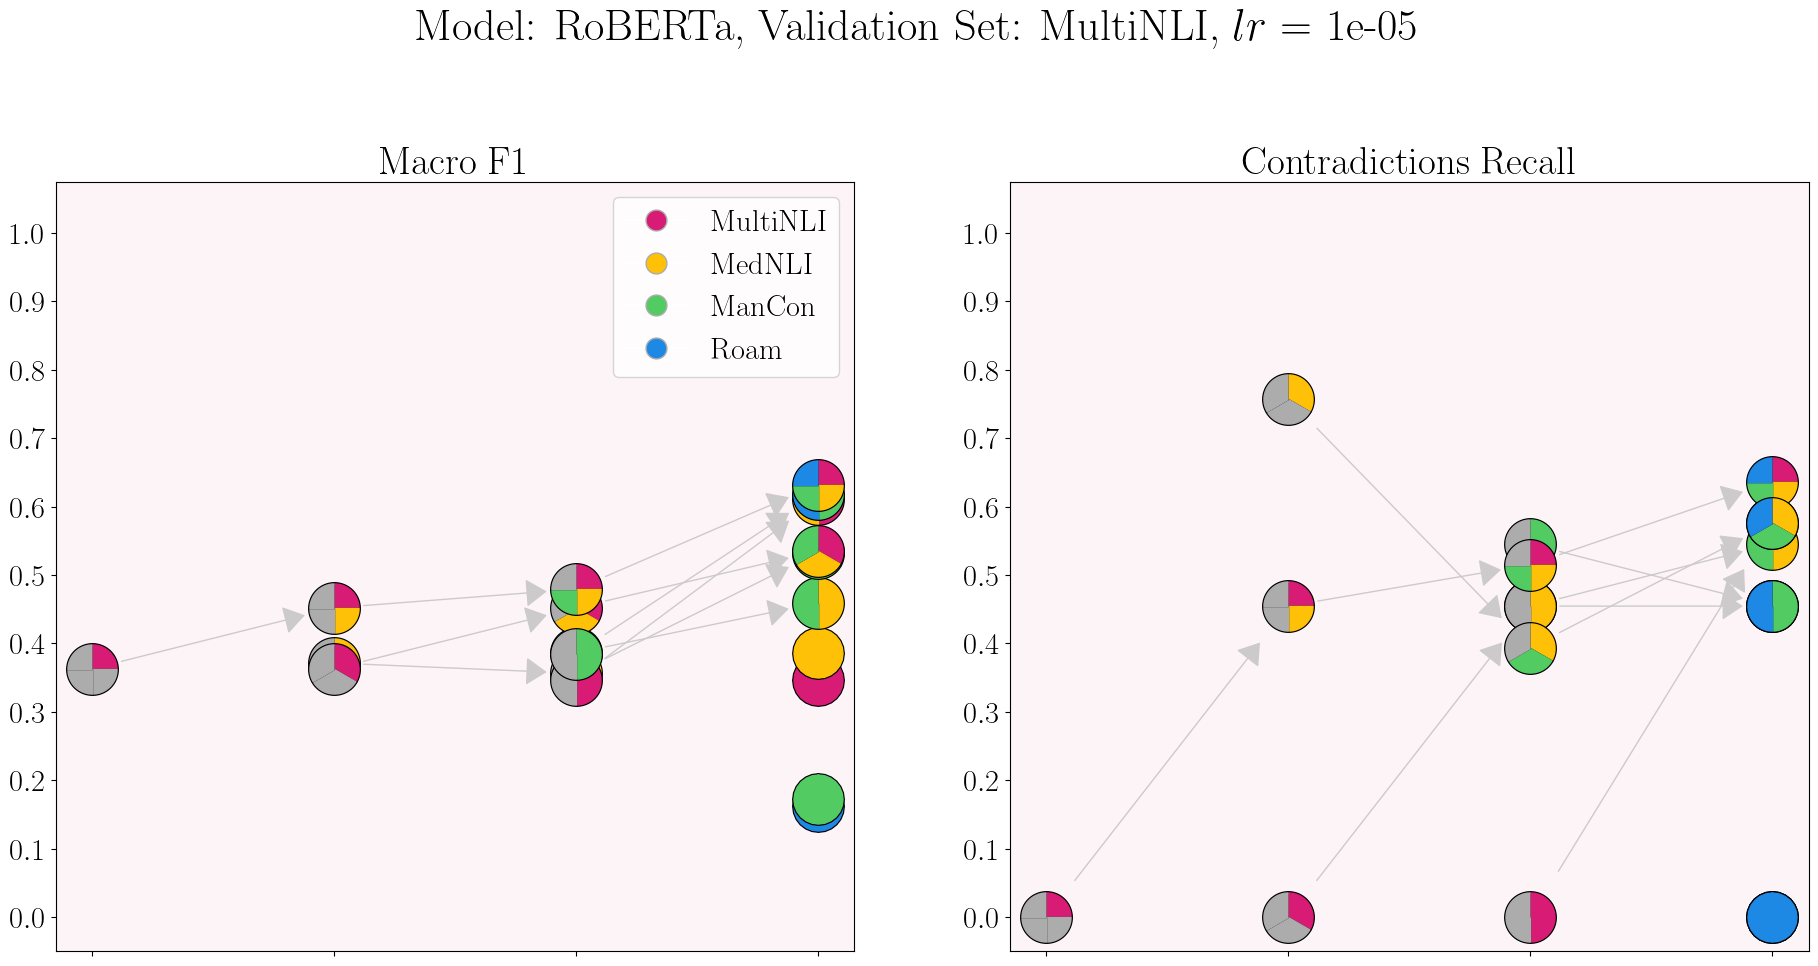

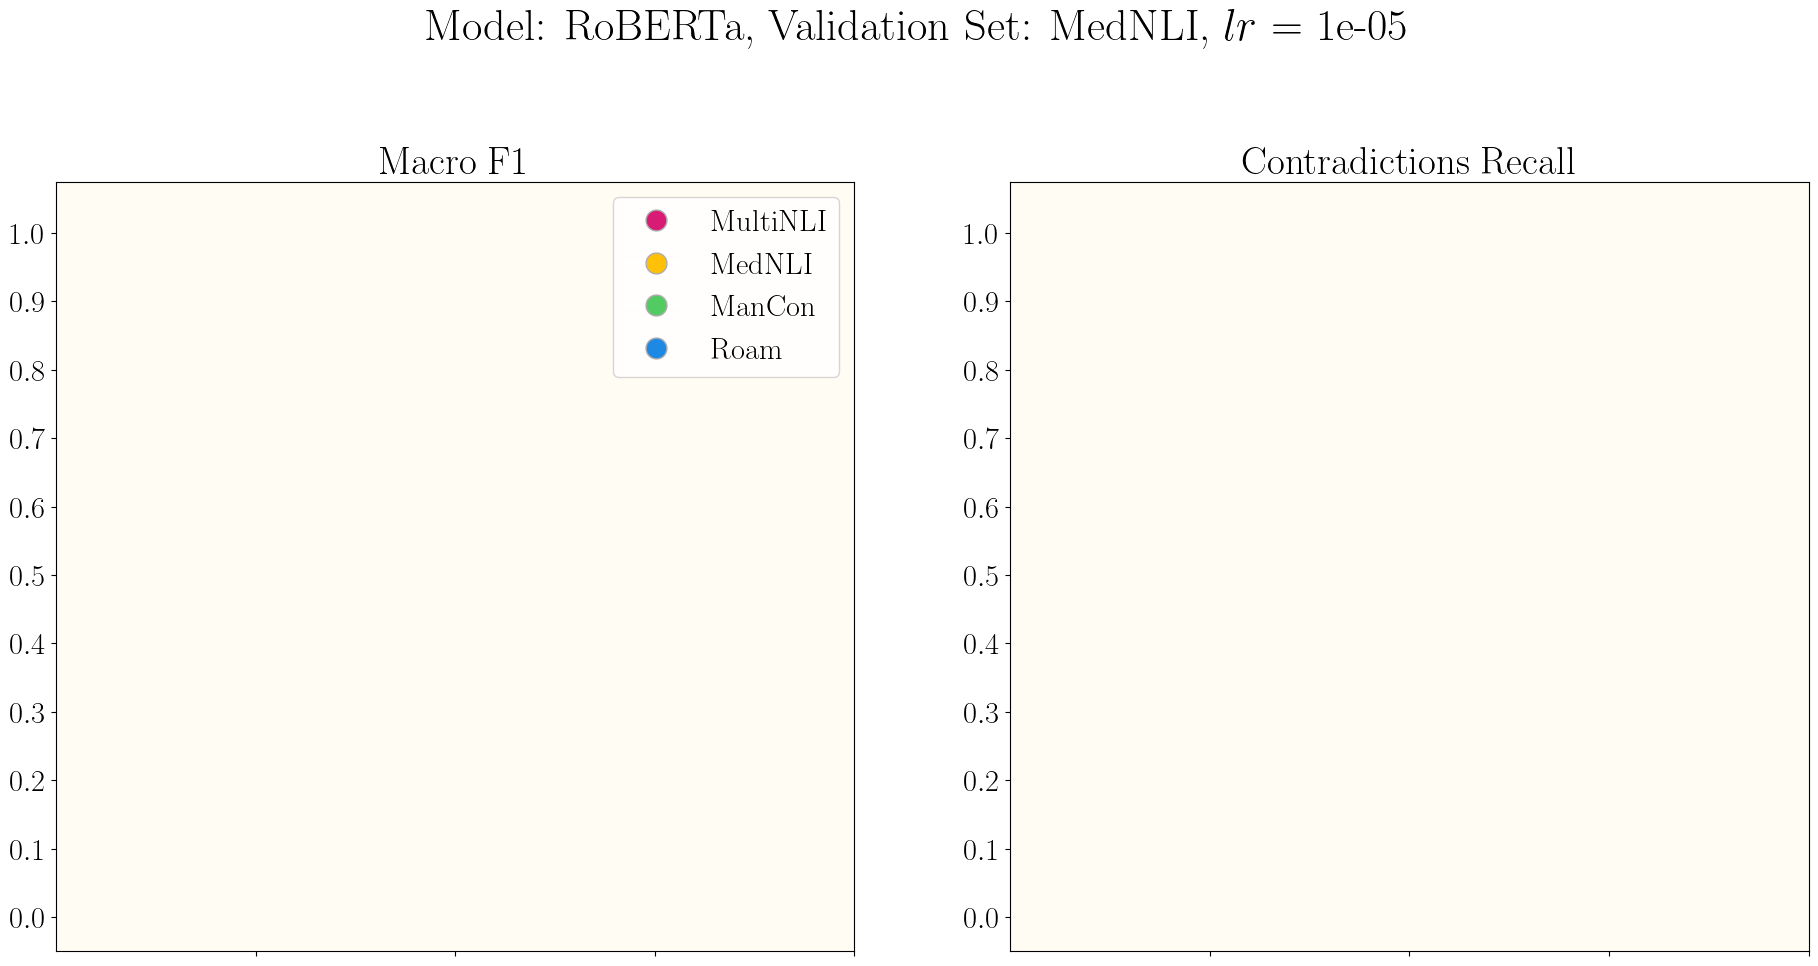

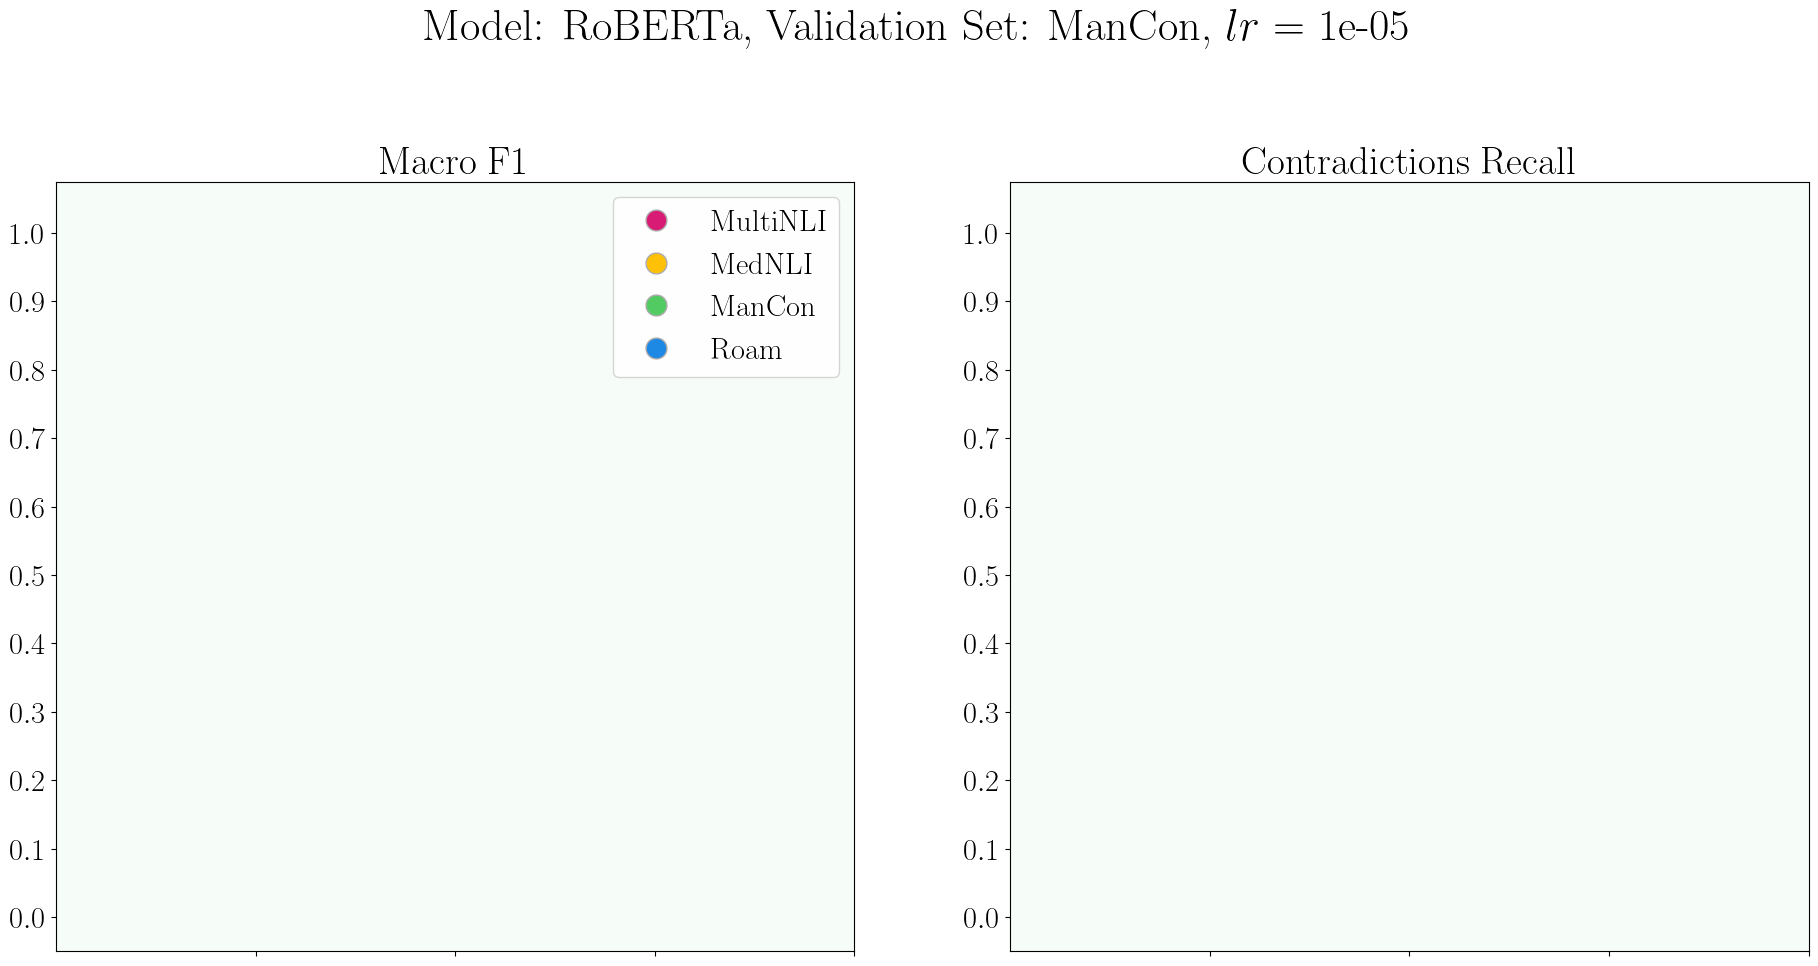

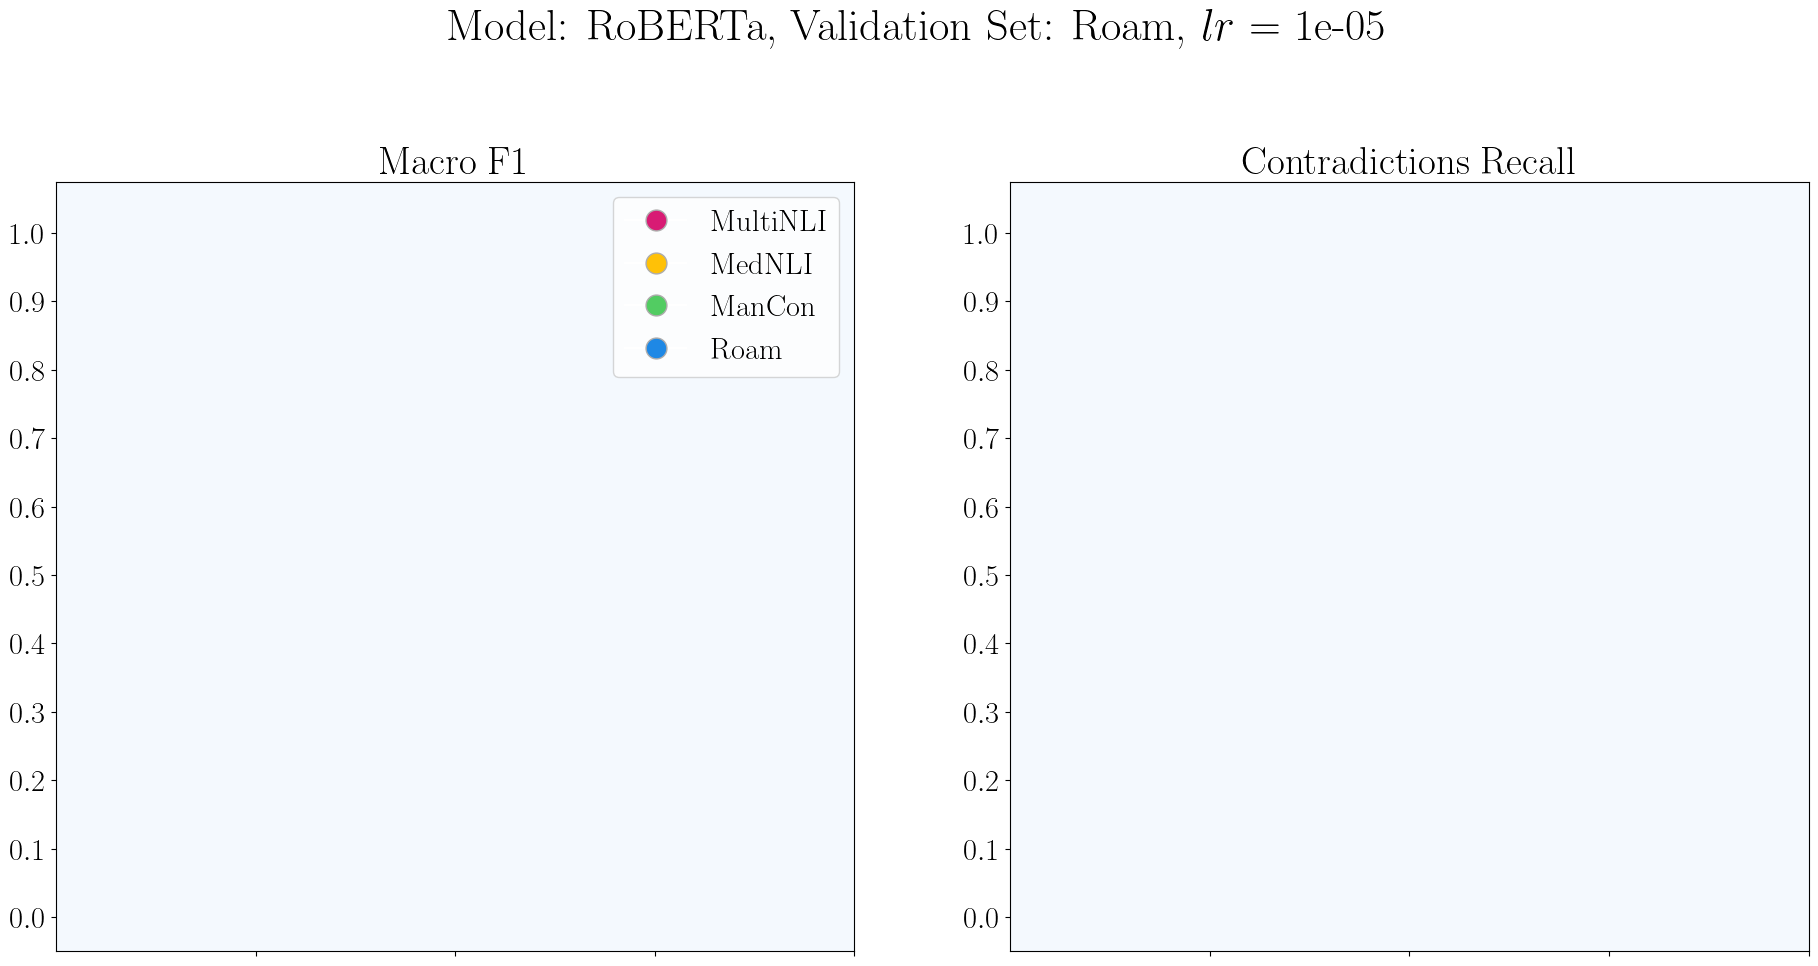

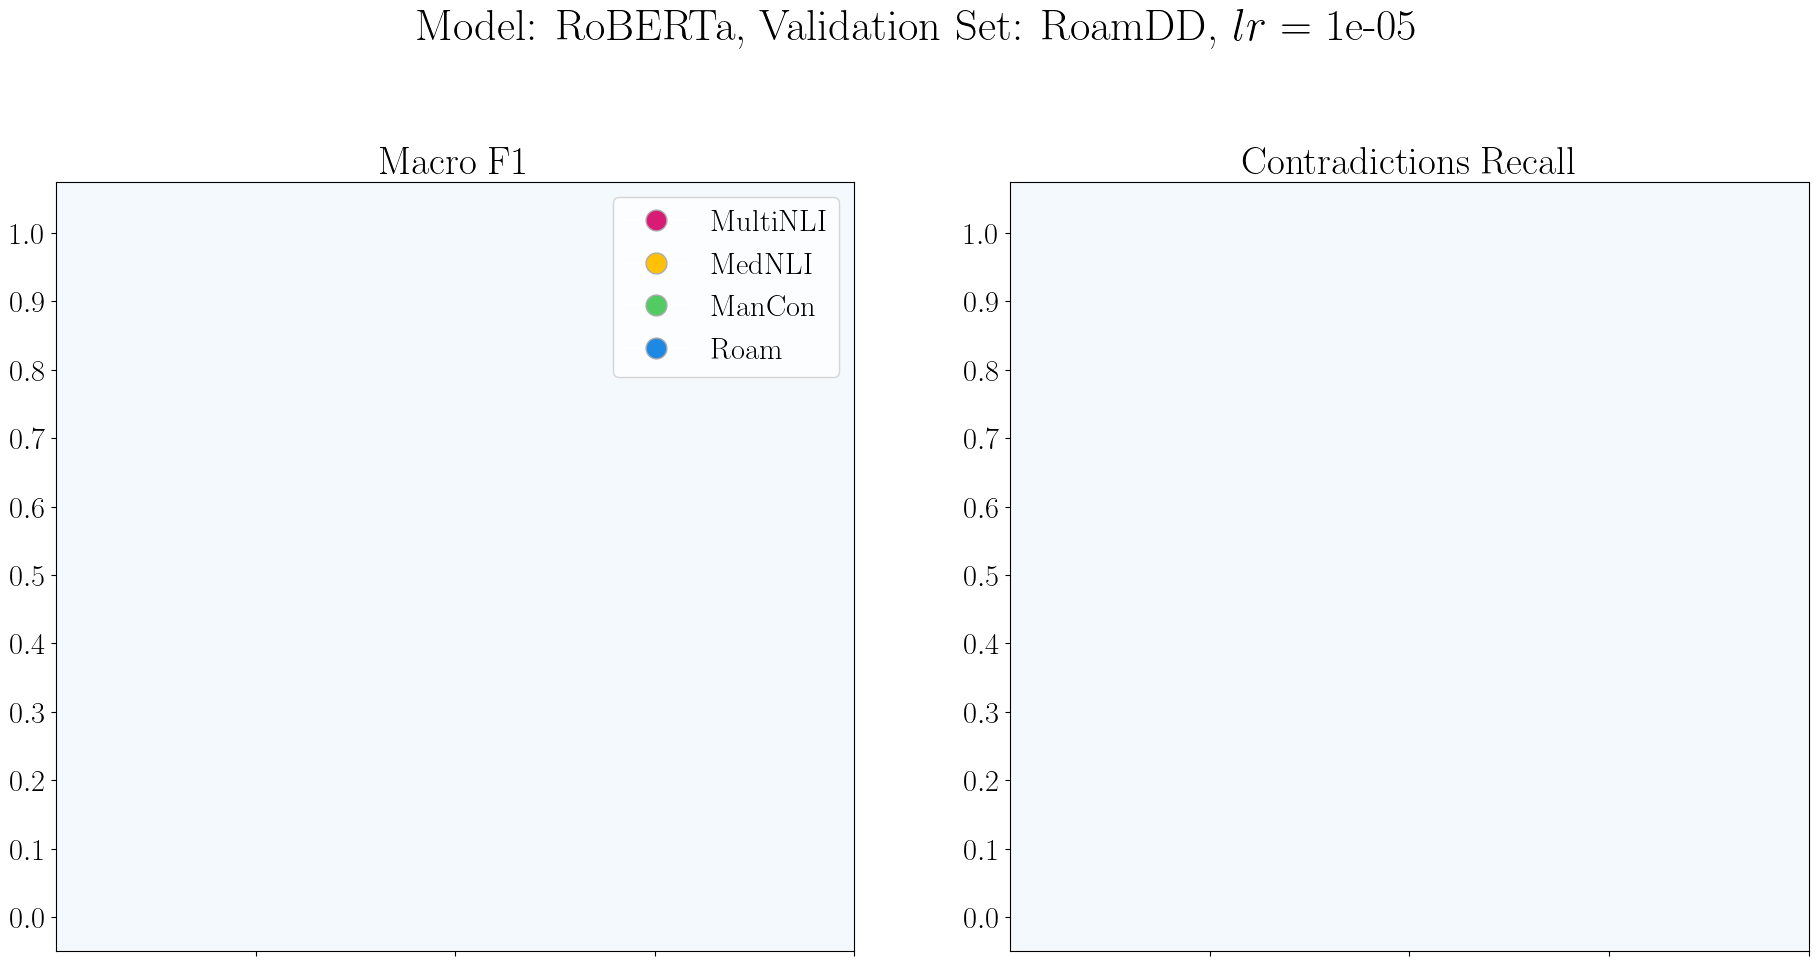

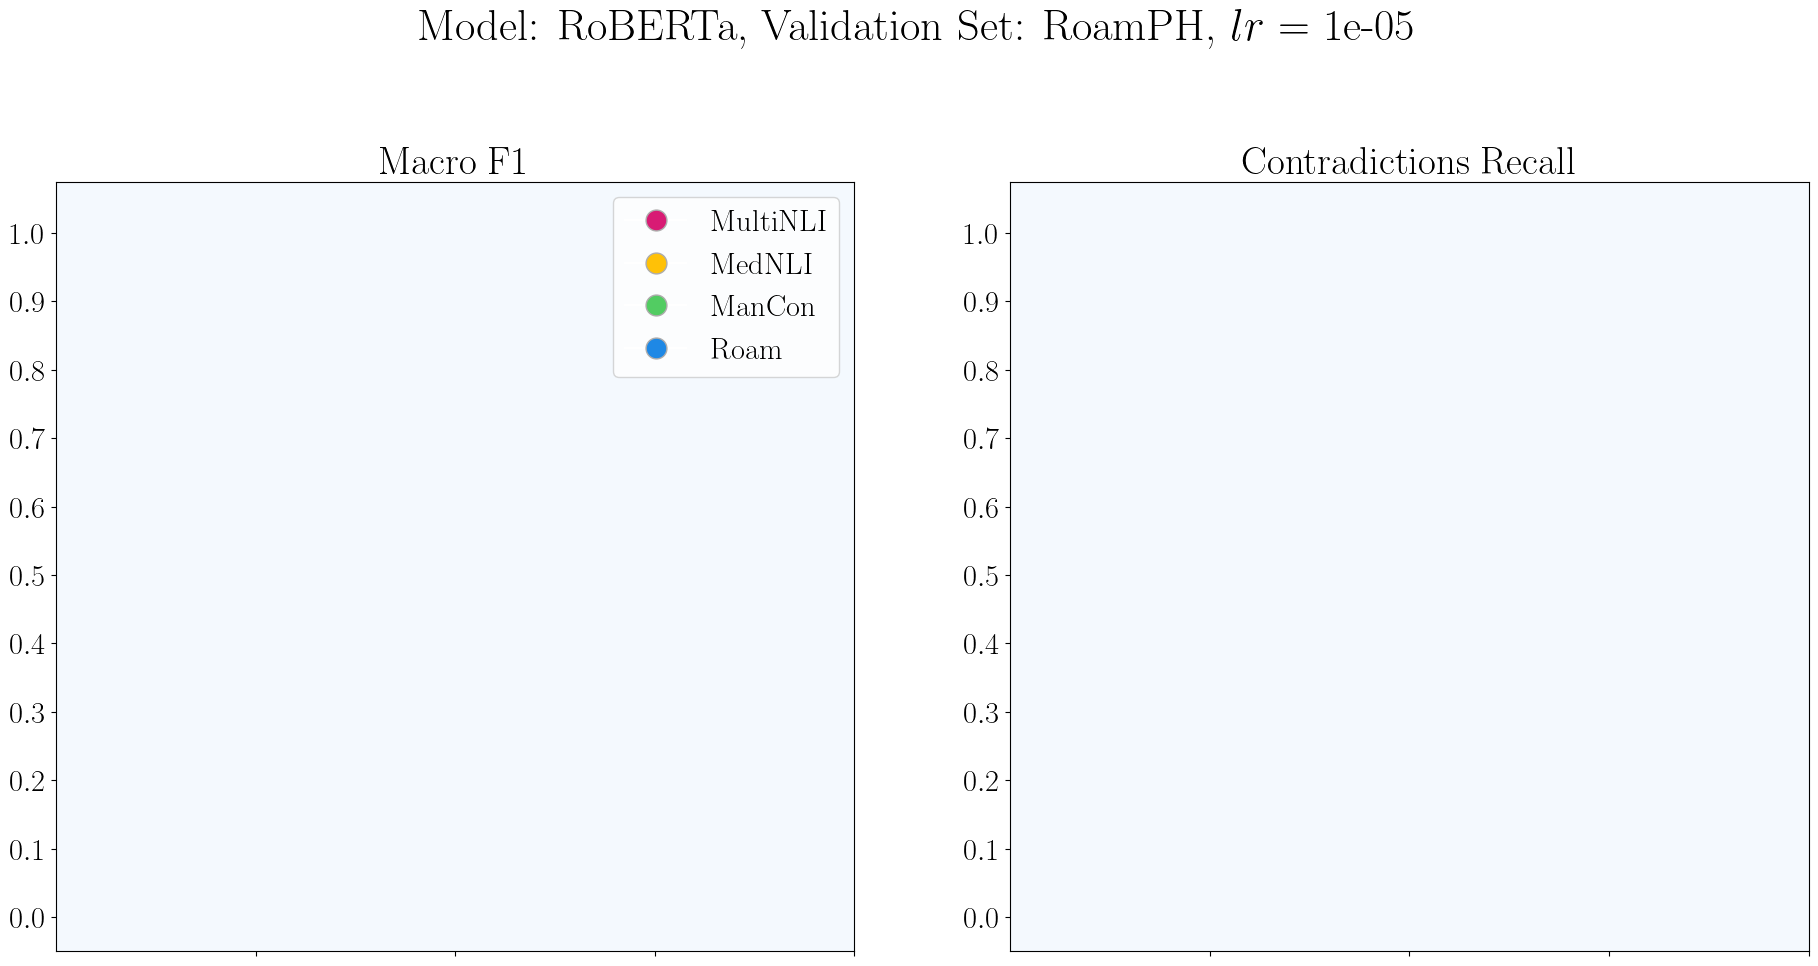

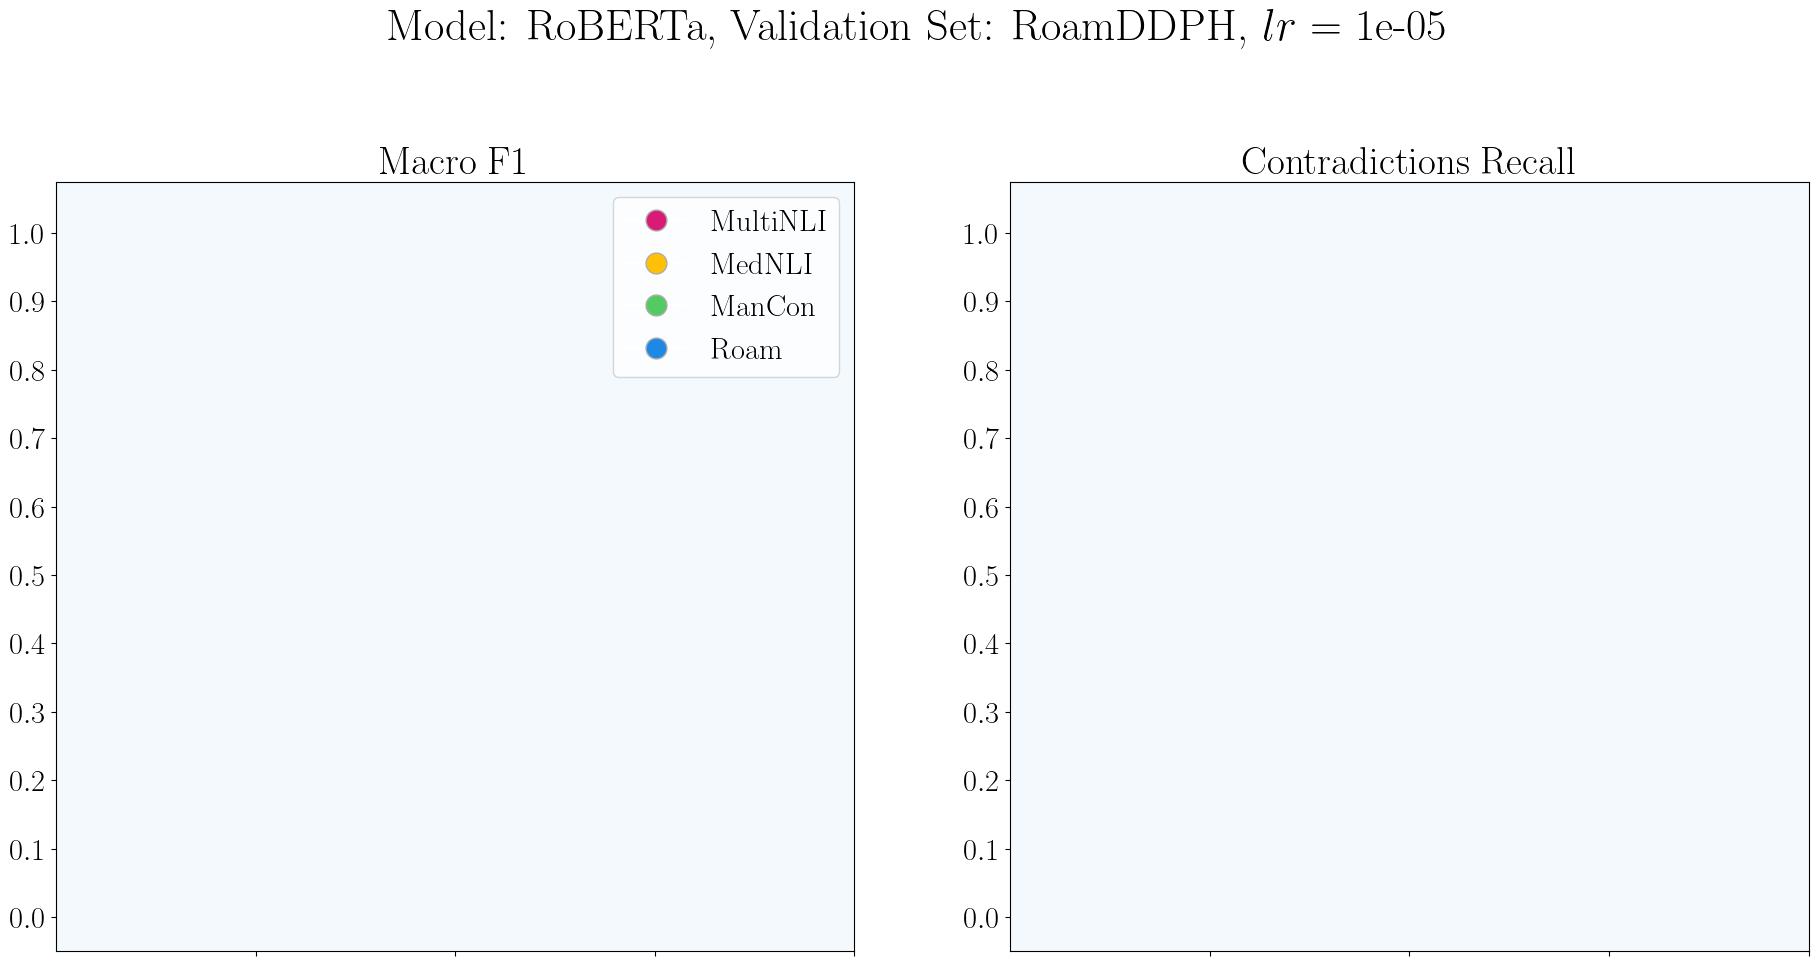

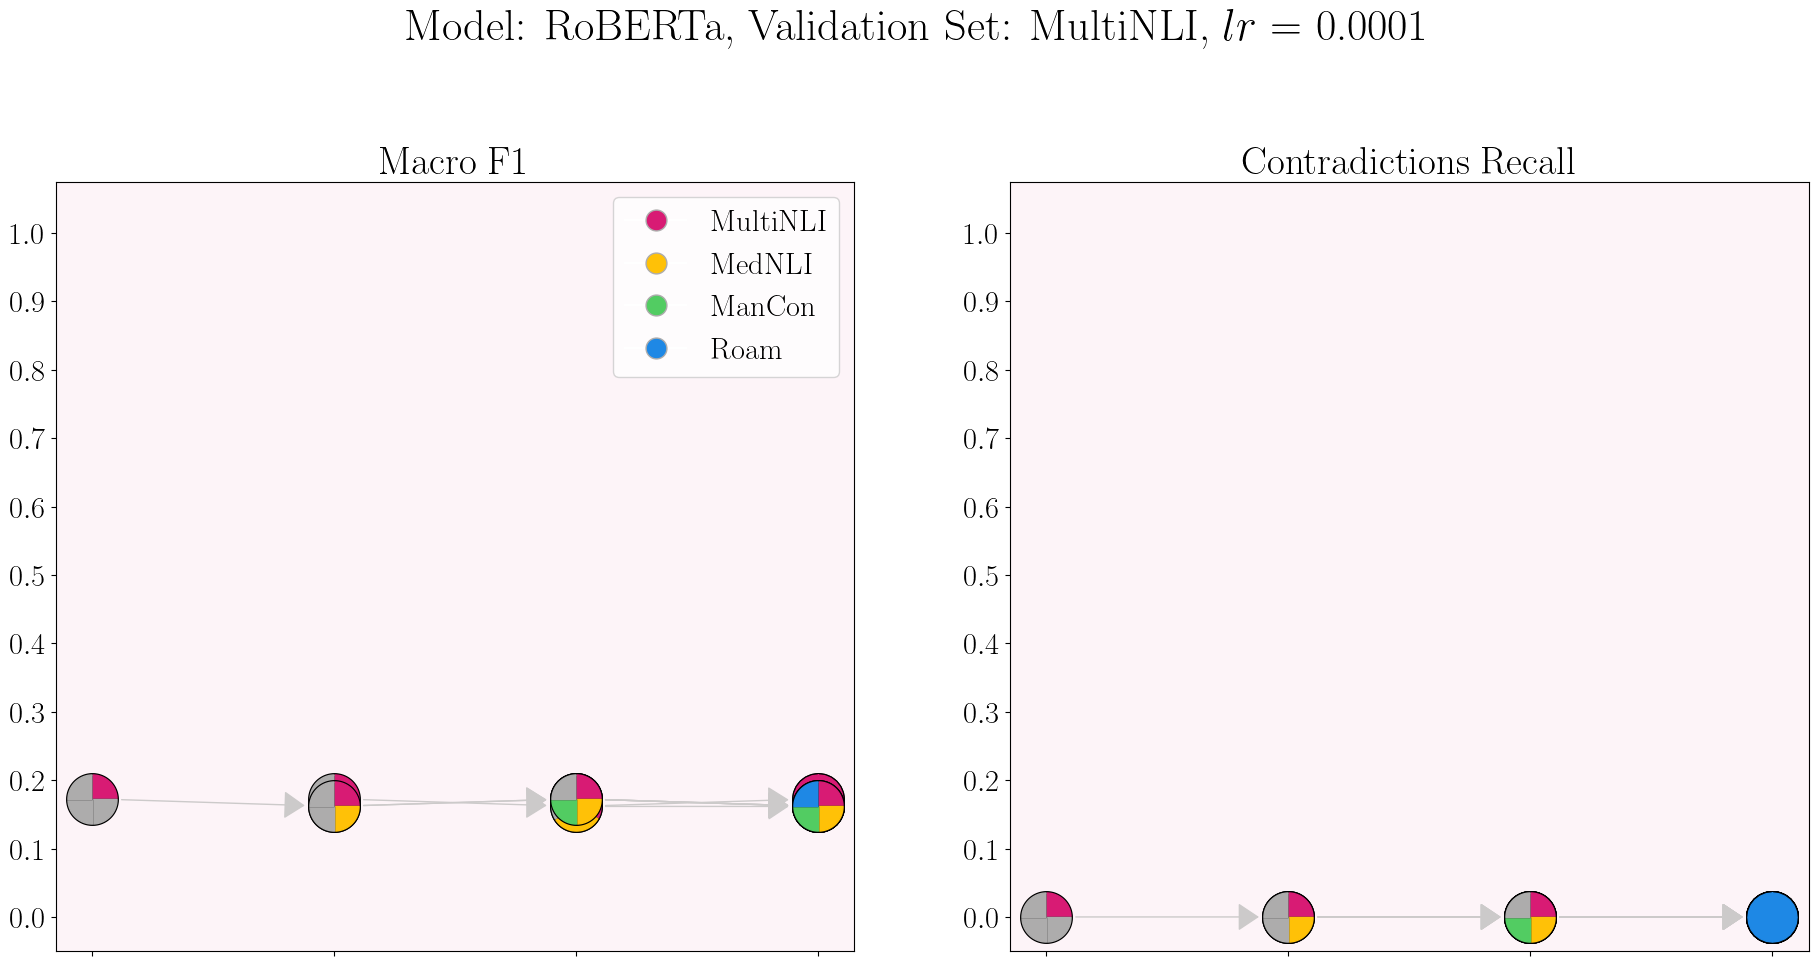

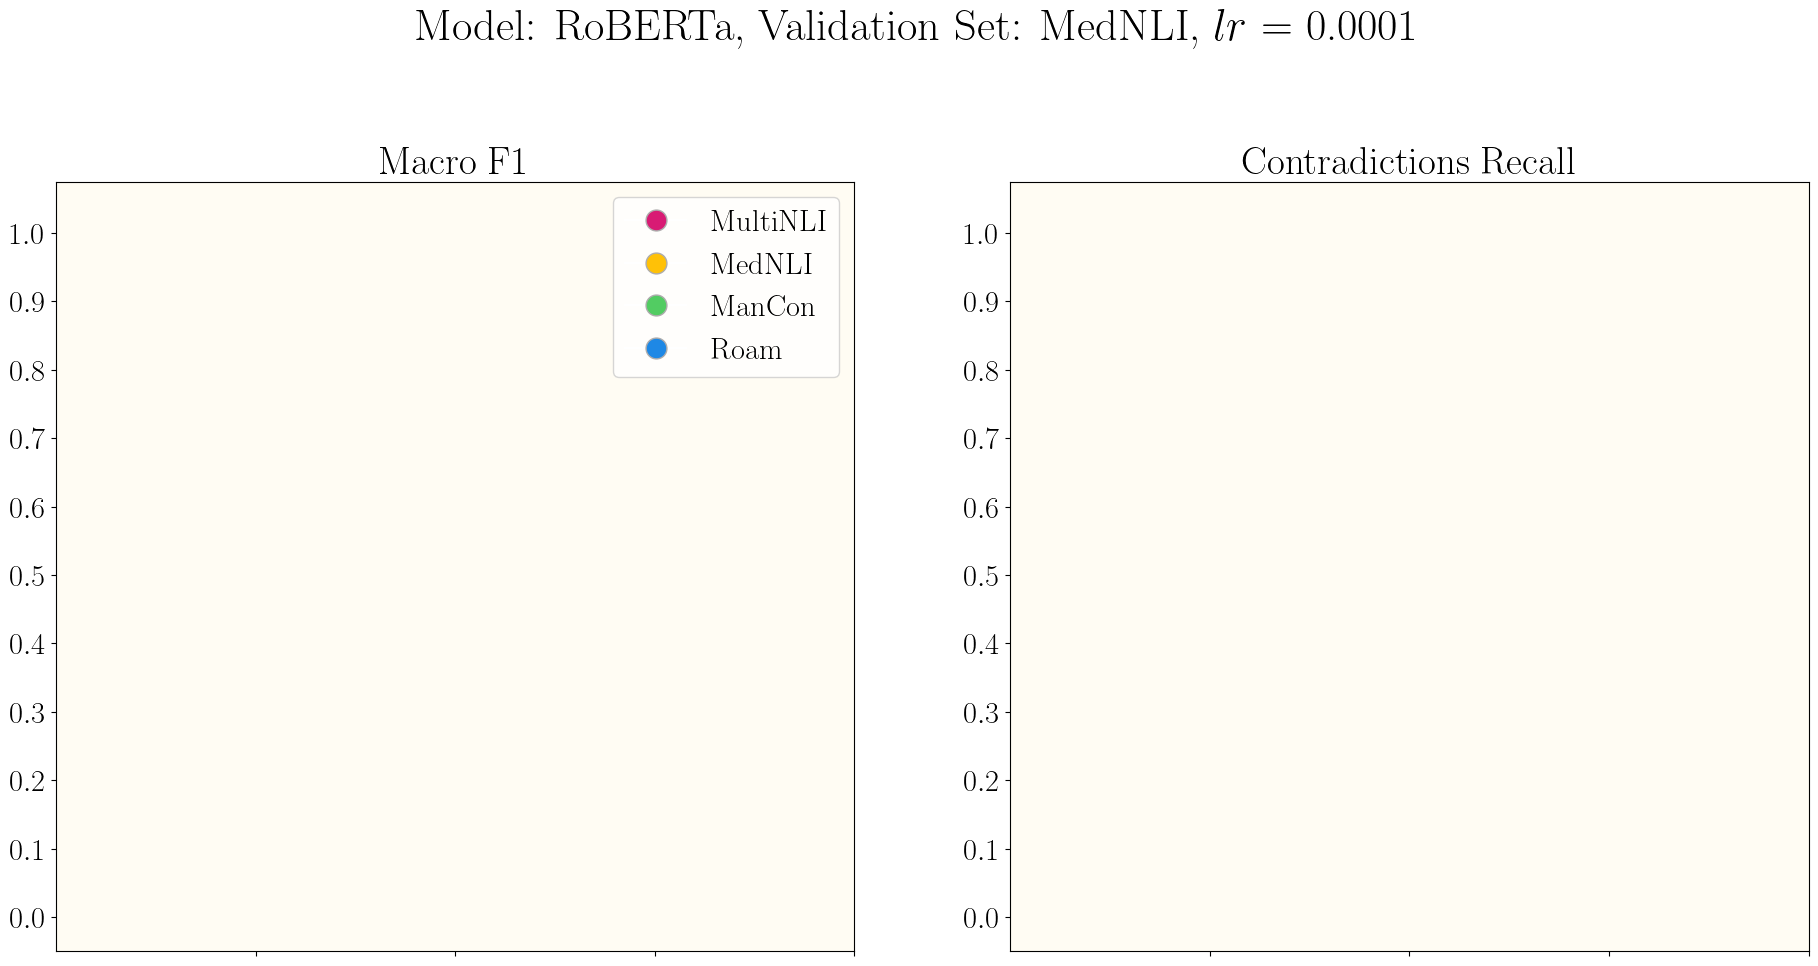

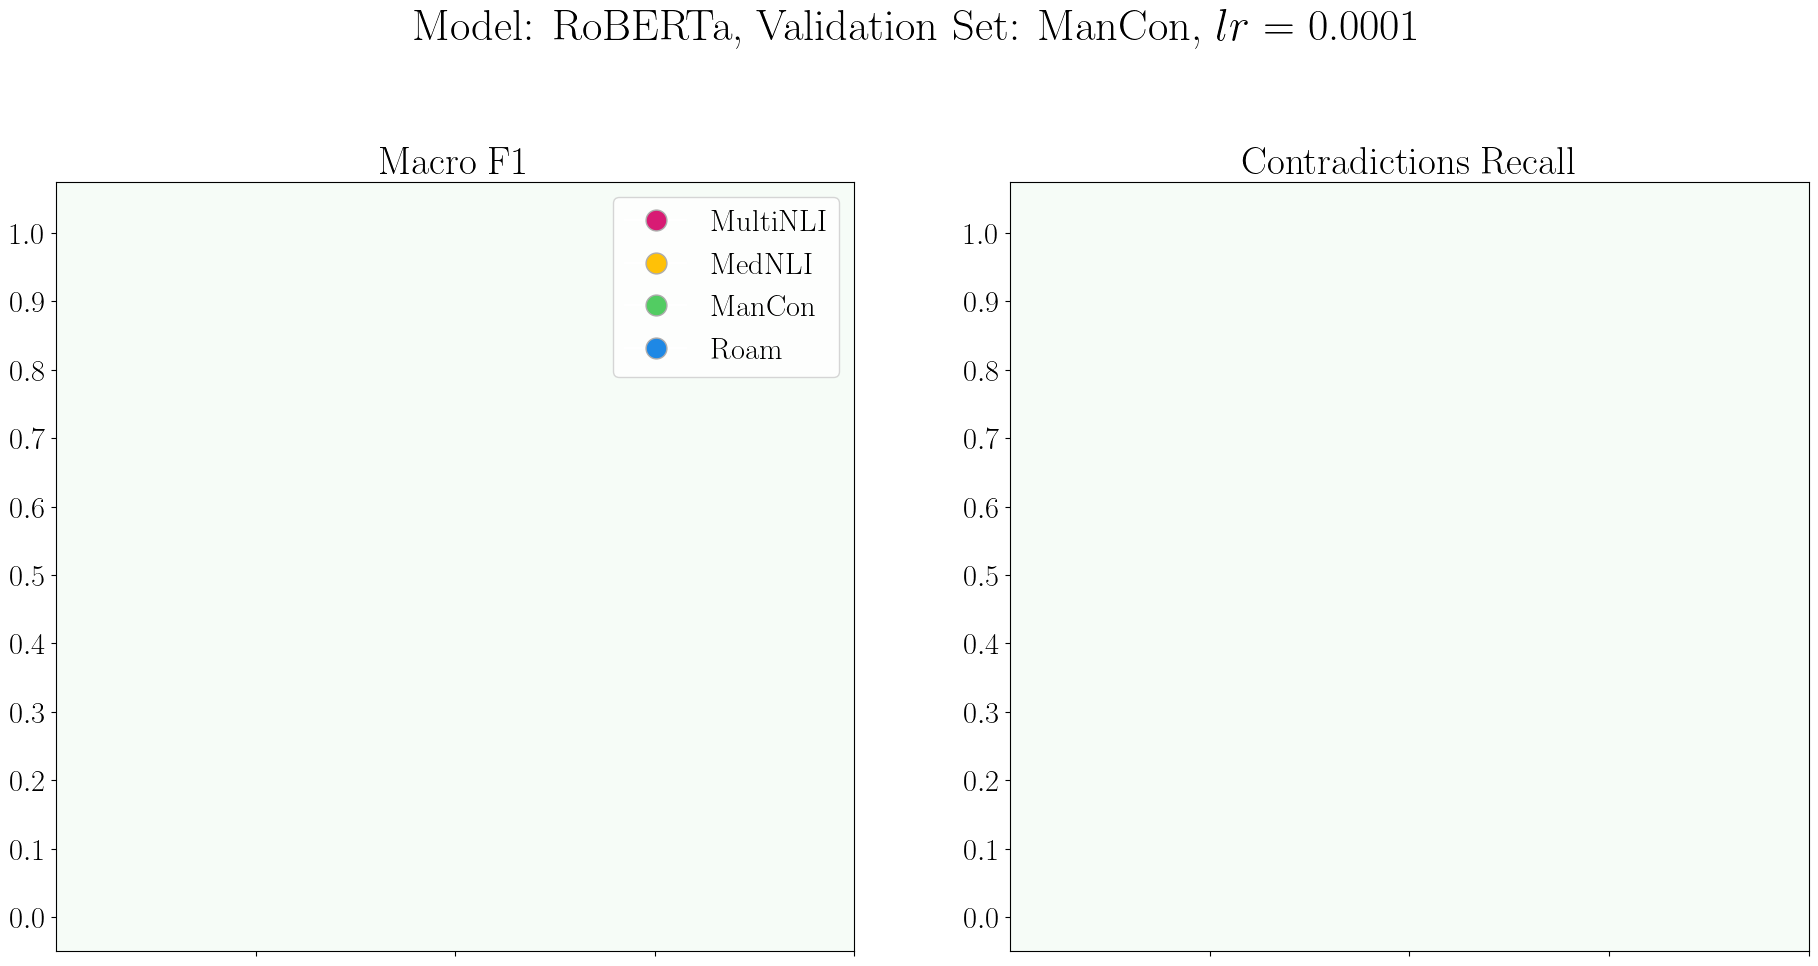

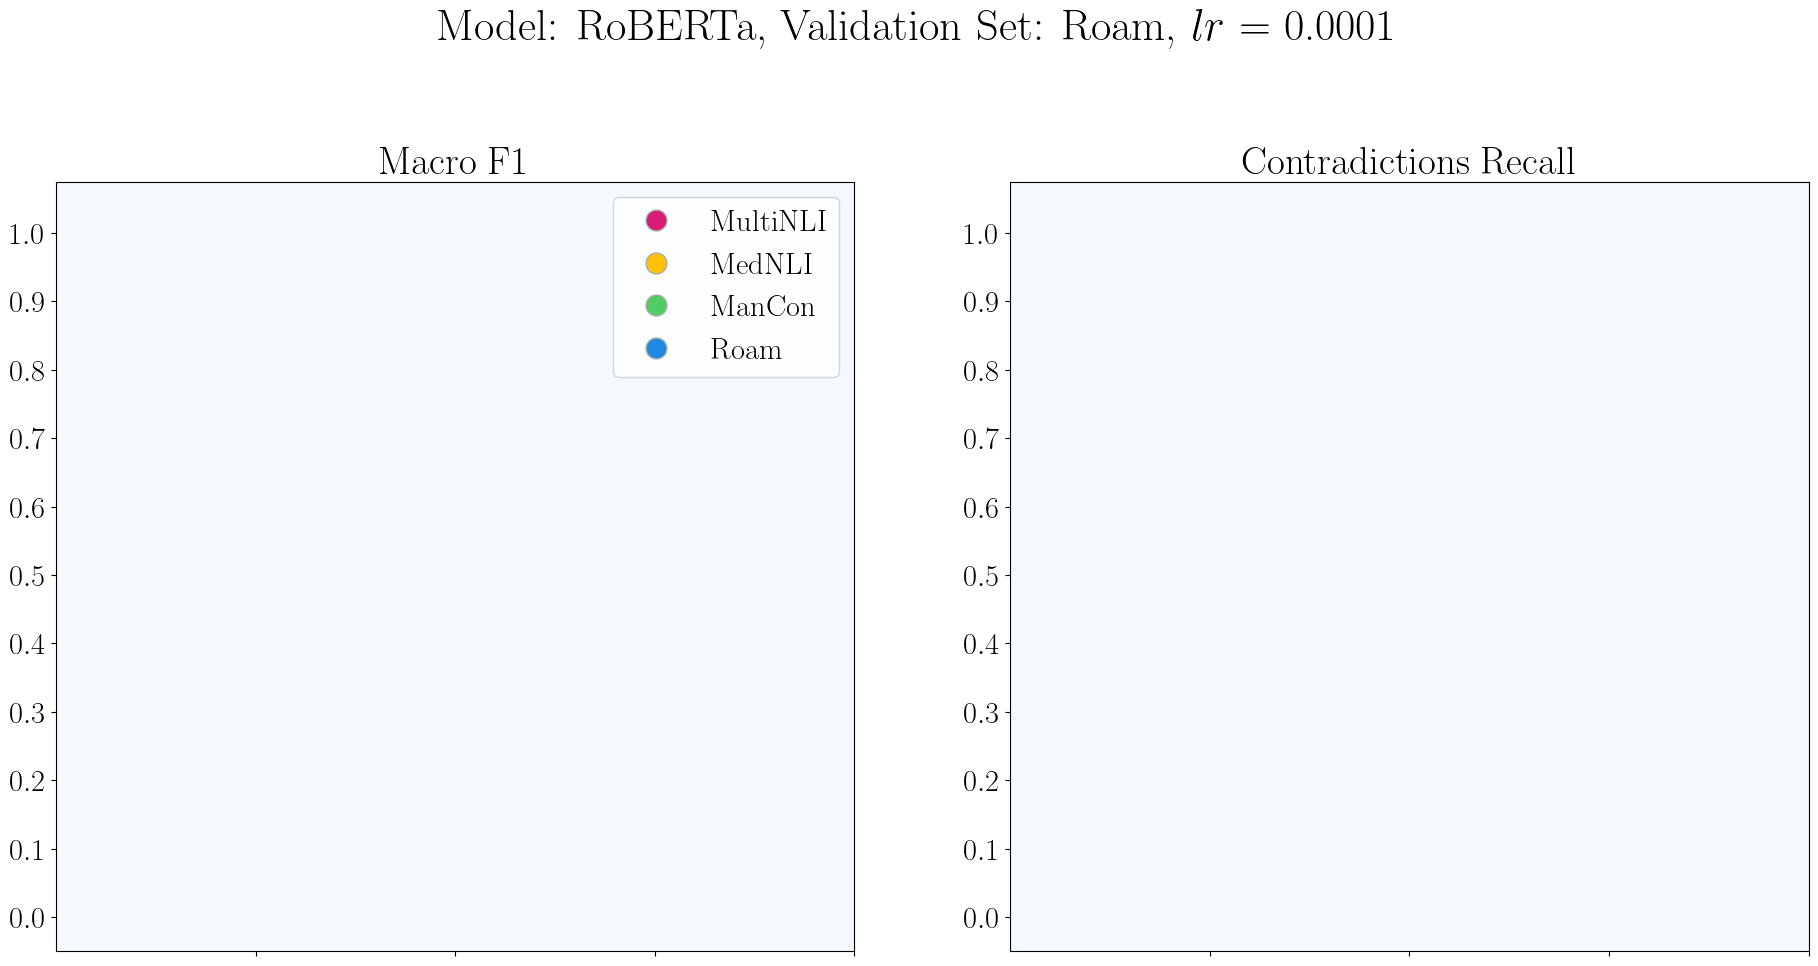

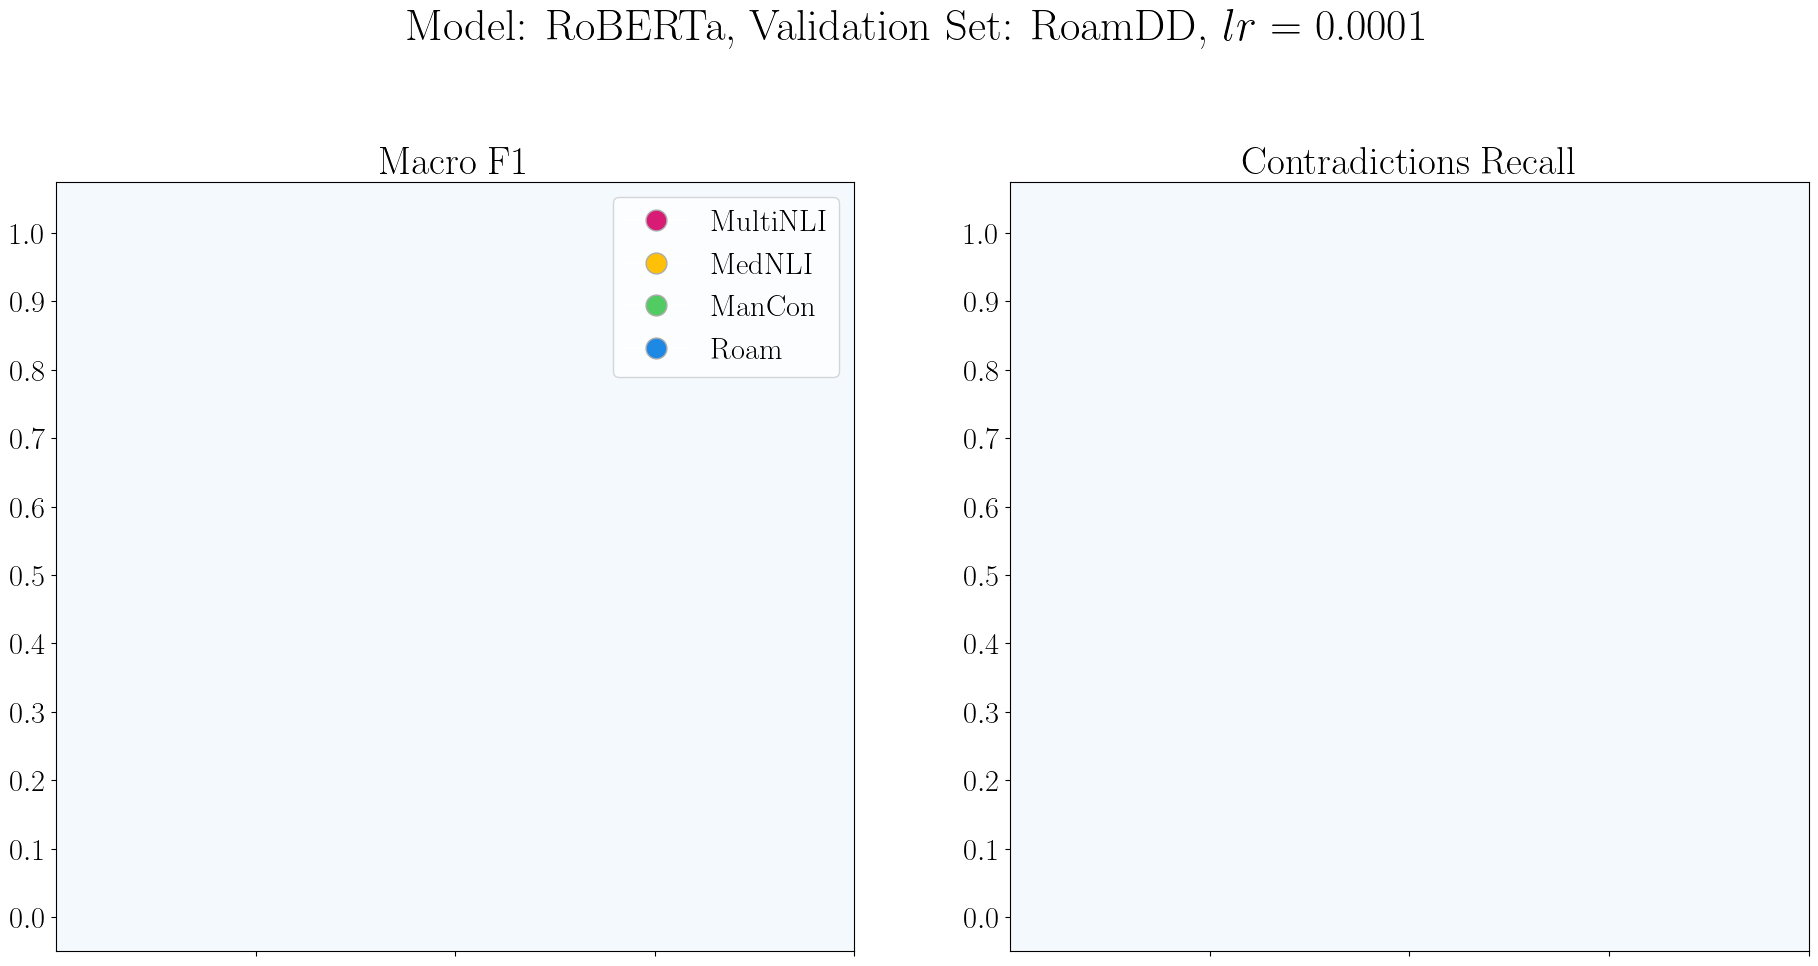

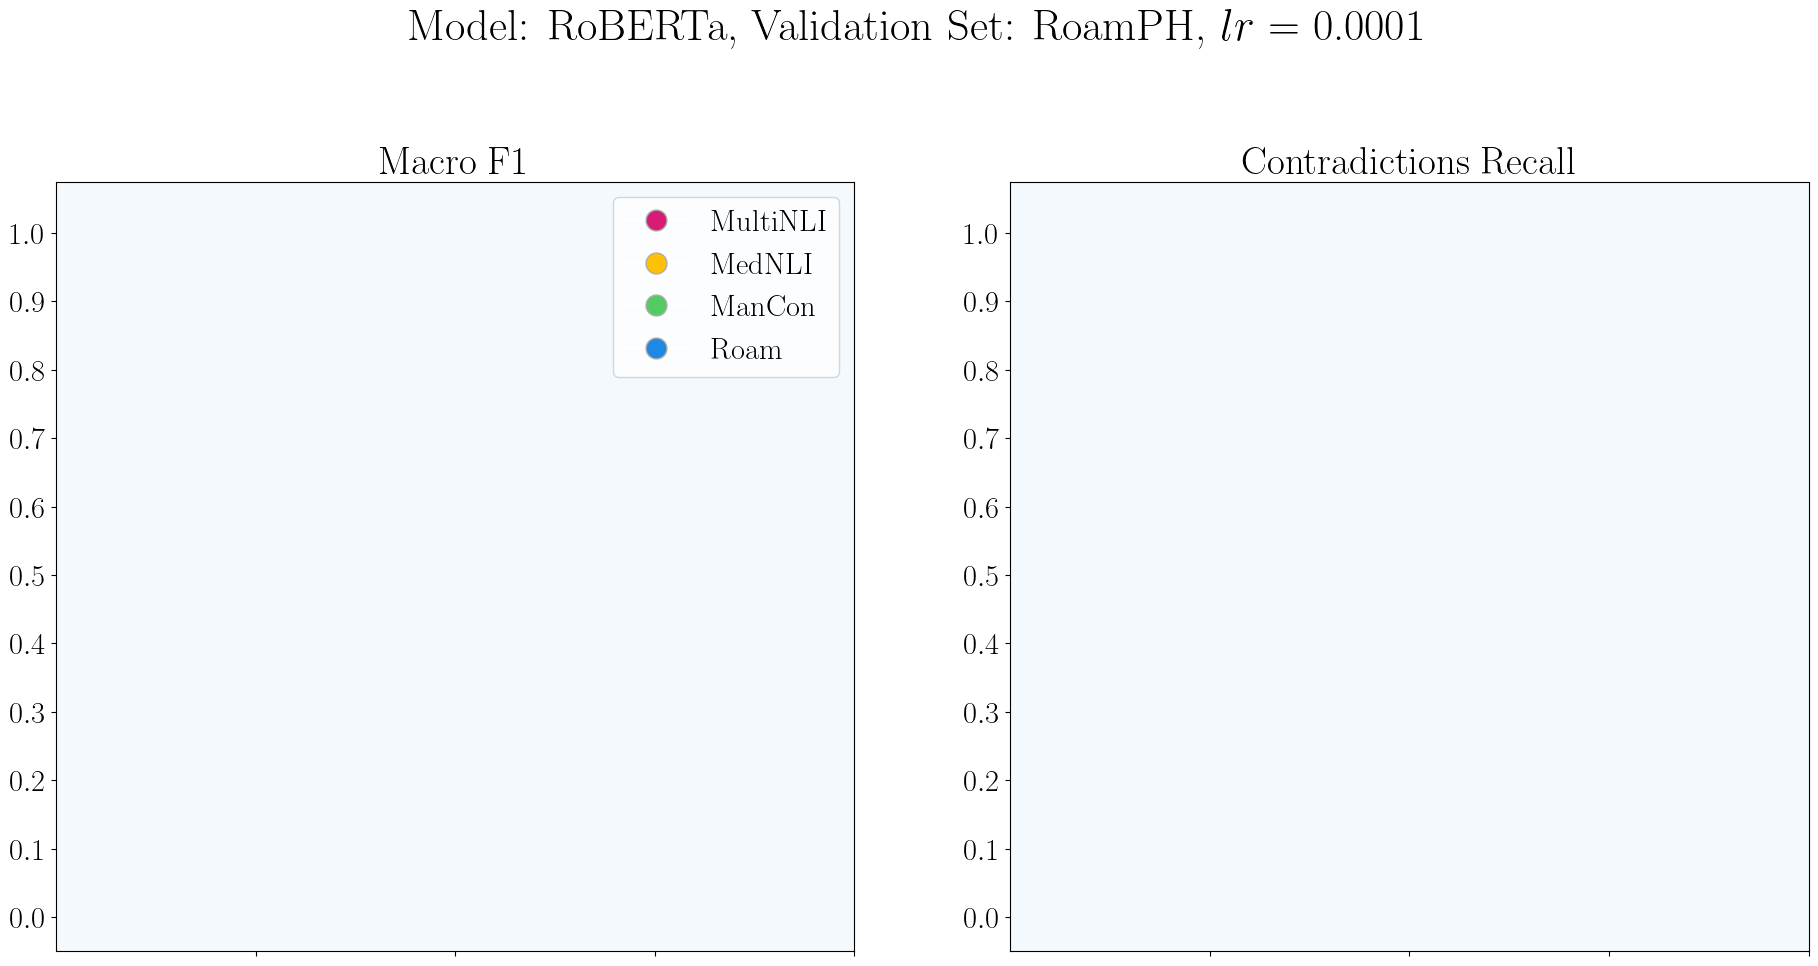

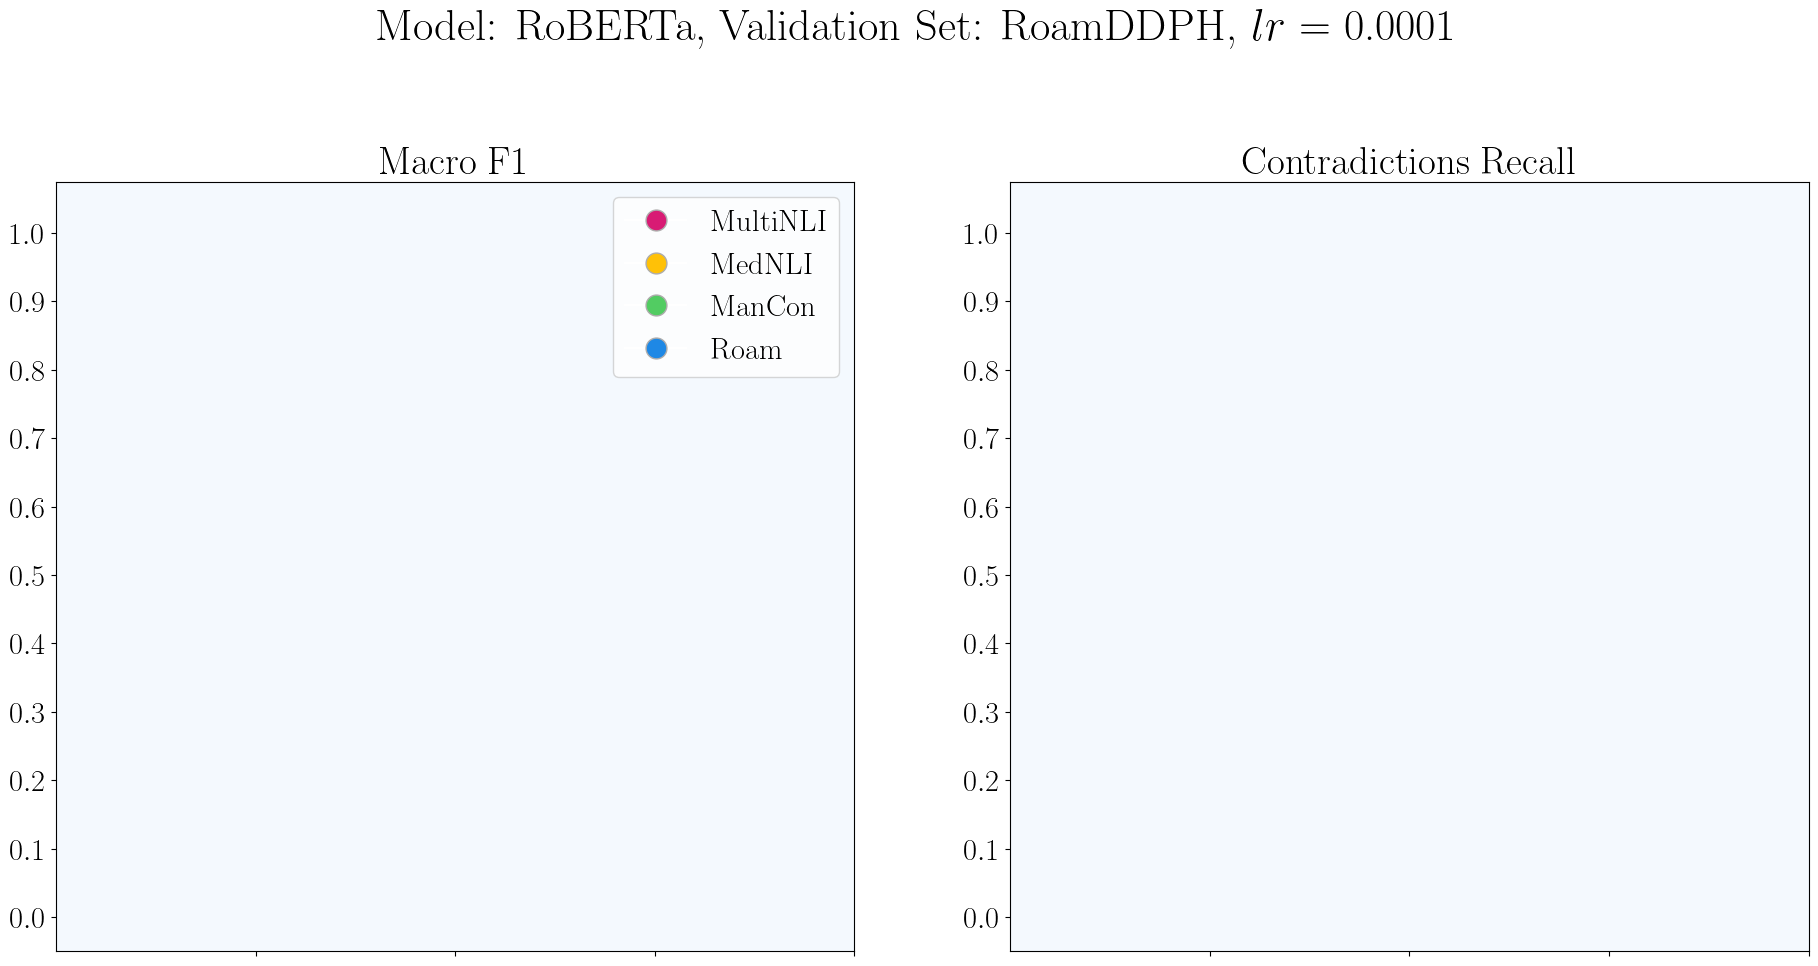

In [358]:
# Load the results
root = f"/Users/dnsosa/Desktop/AltmanLab/covid_lit_contra_claims/output/from_sherlock/"
experiment = "orderedSubseqCompare"
model = "roberta"
metrics_to_vis = ["f1", "recall_con"]

ordered_subseq_df, xx = draw_pie_seq_plot(root, experiment, model, metrics_to_vis)

IndexError: index 0 is out of bounds for axis 0 with size 0

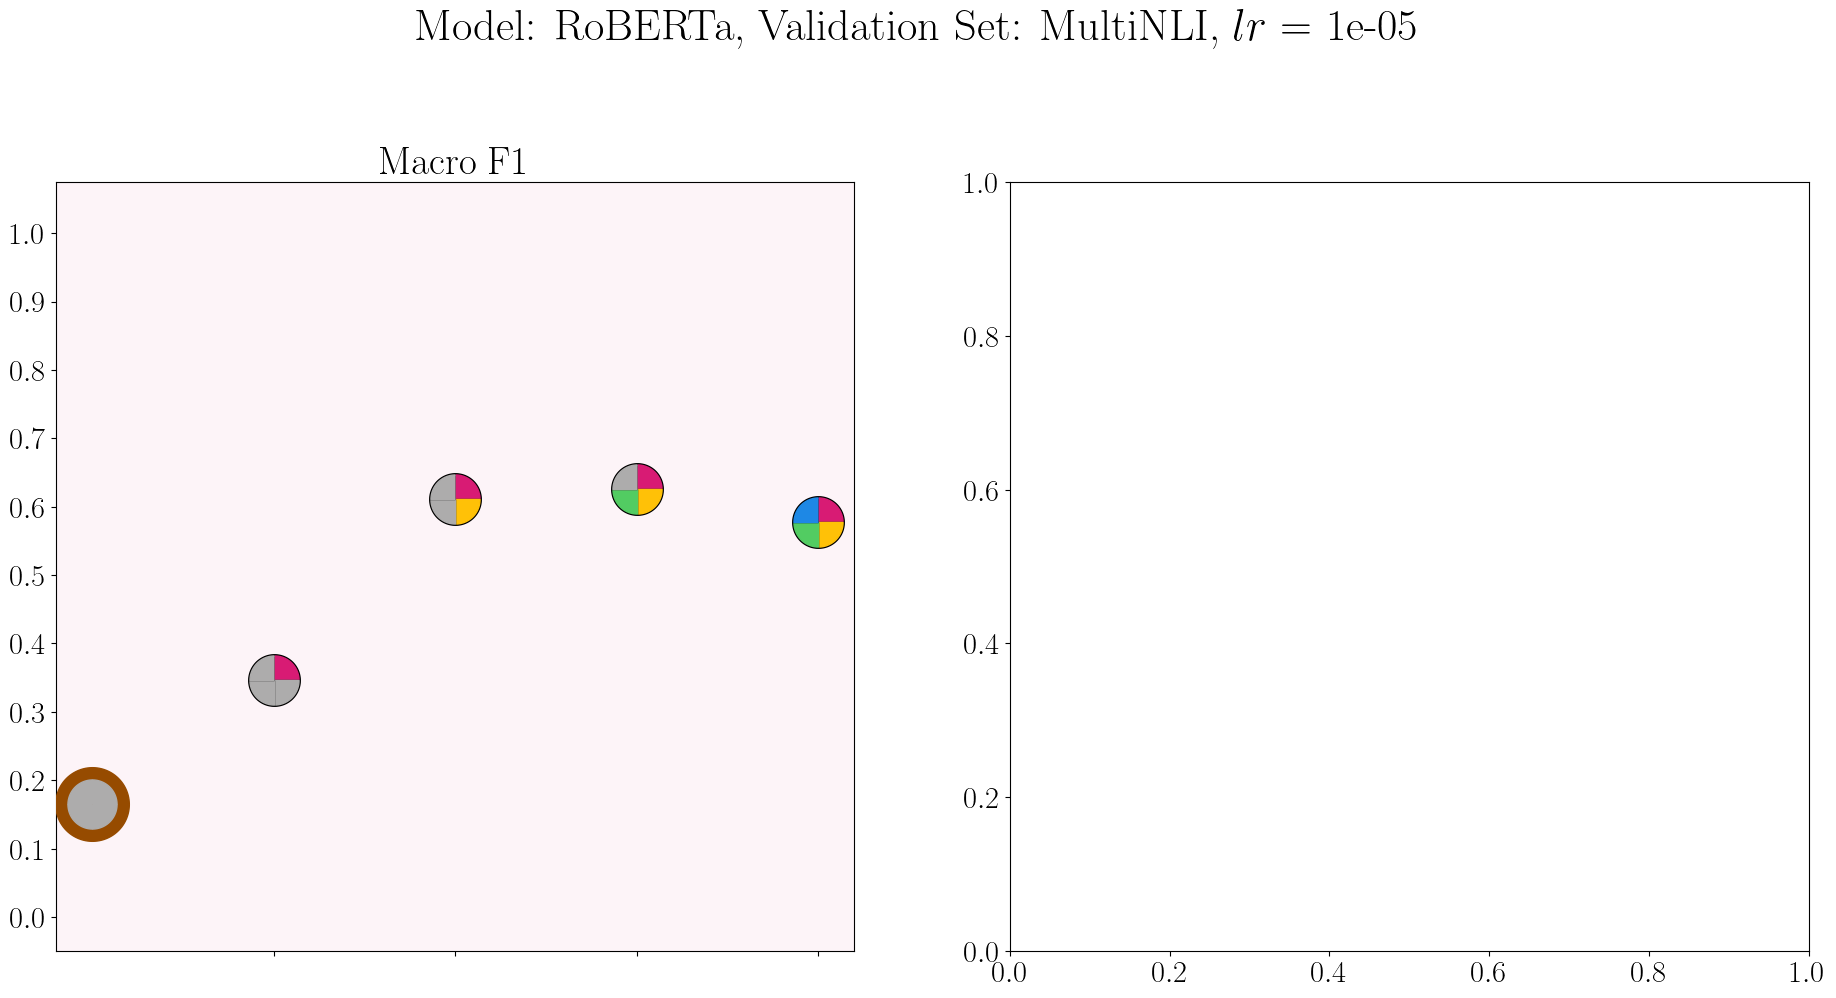

In [325]:
# Load the results
experiment = "longSeqCompare"
model = "roberta"
metrics_to_vis = ["f1", "recall_con"]

long_seq_df, xx = draw_pie_seq_plot(root, experiment, model, metrics_to_vis, highlight_forward_back=True)

#df[df.train_prep_experiment == "combined"]

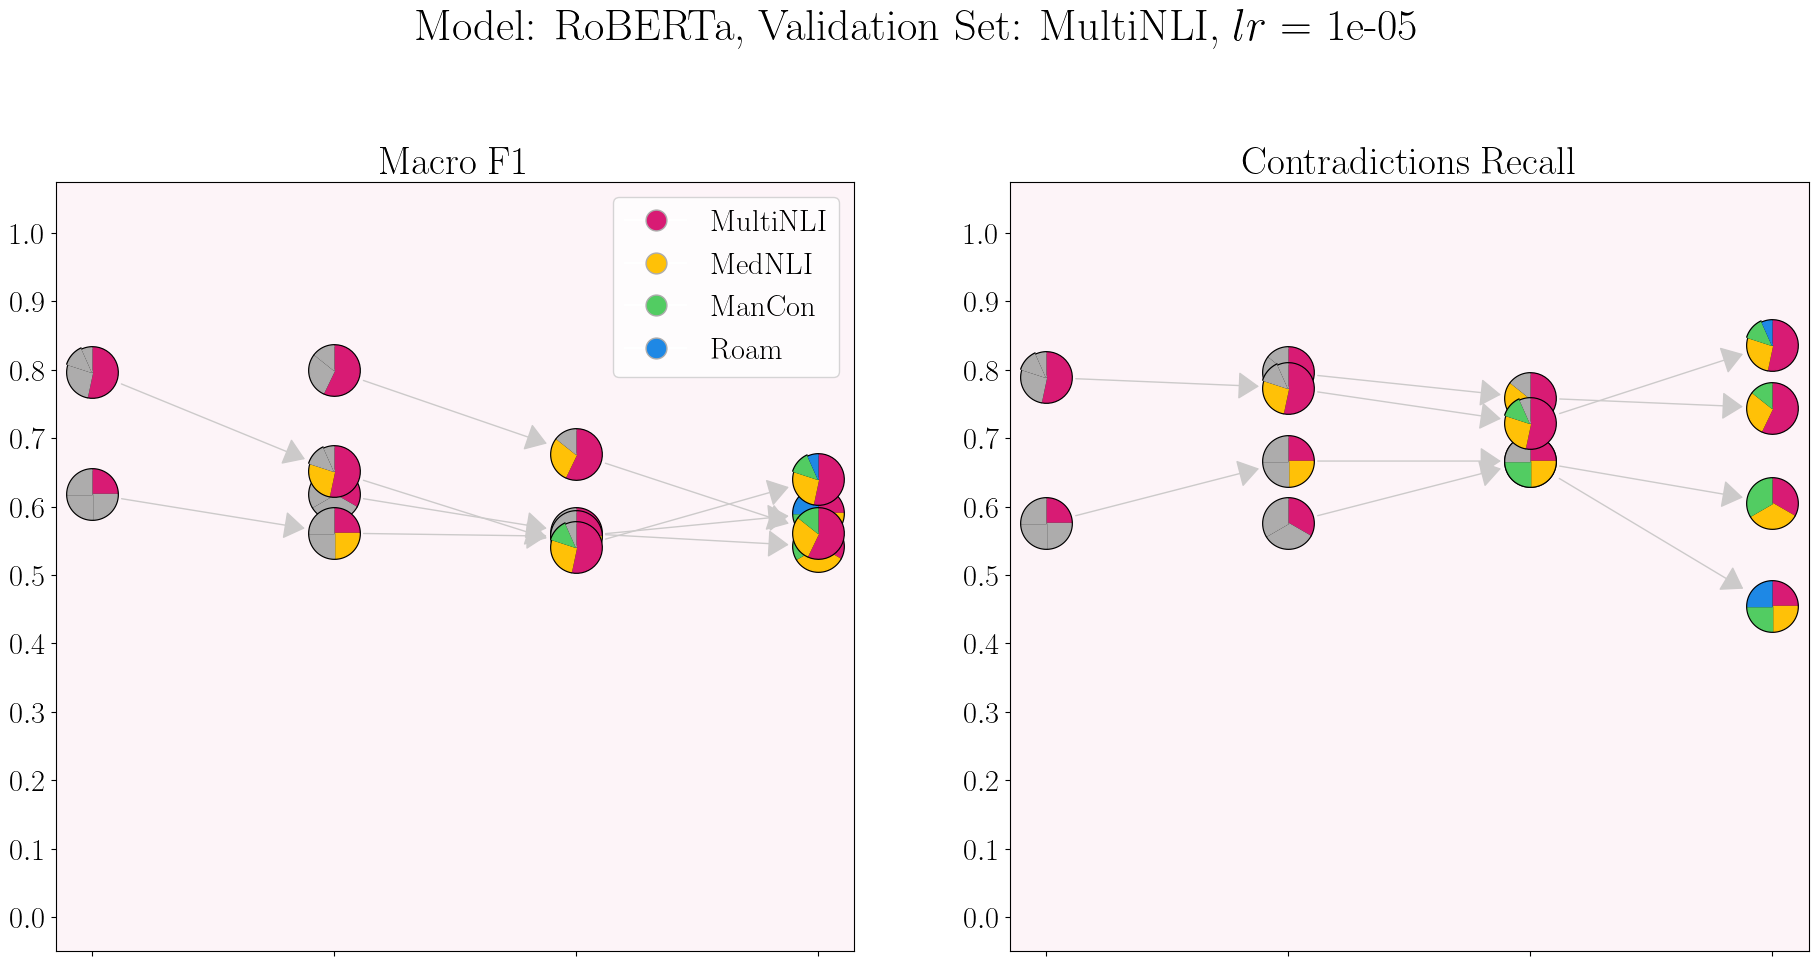

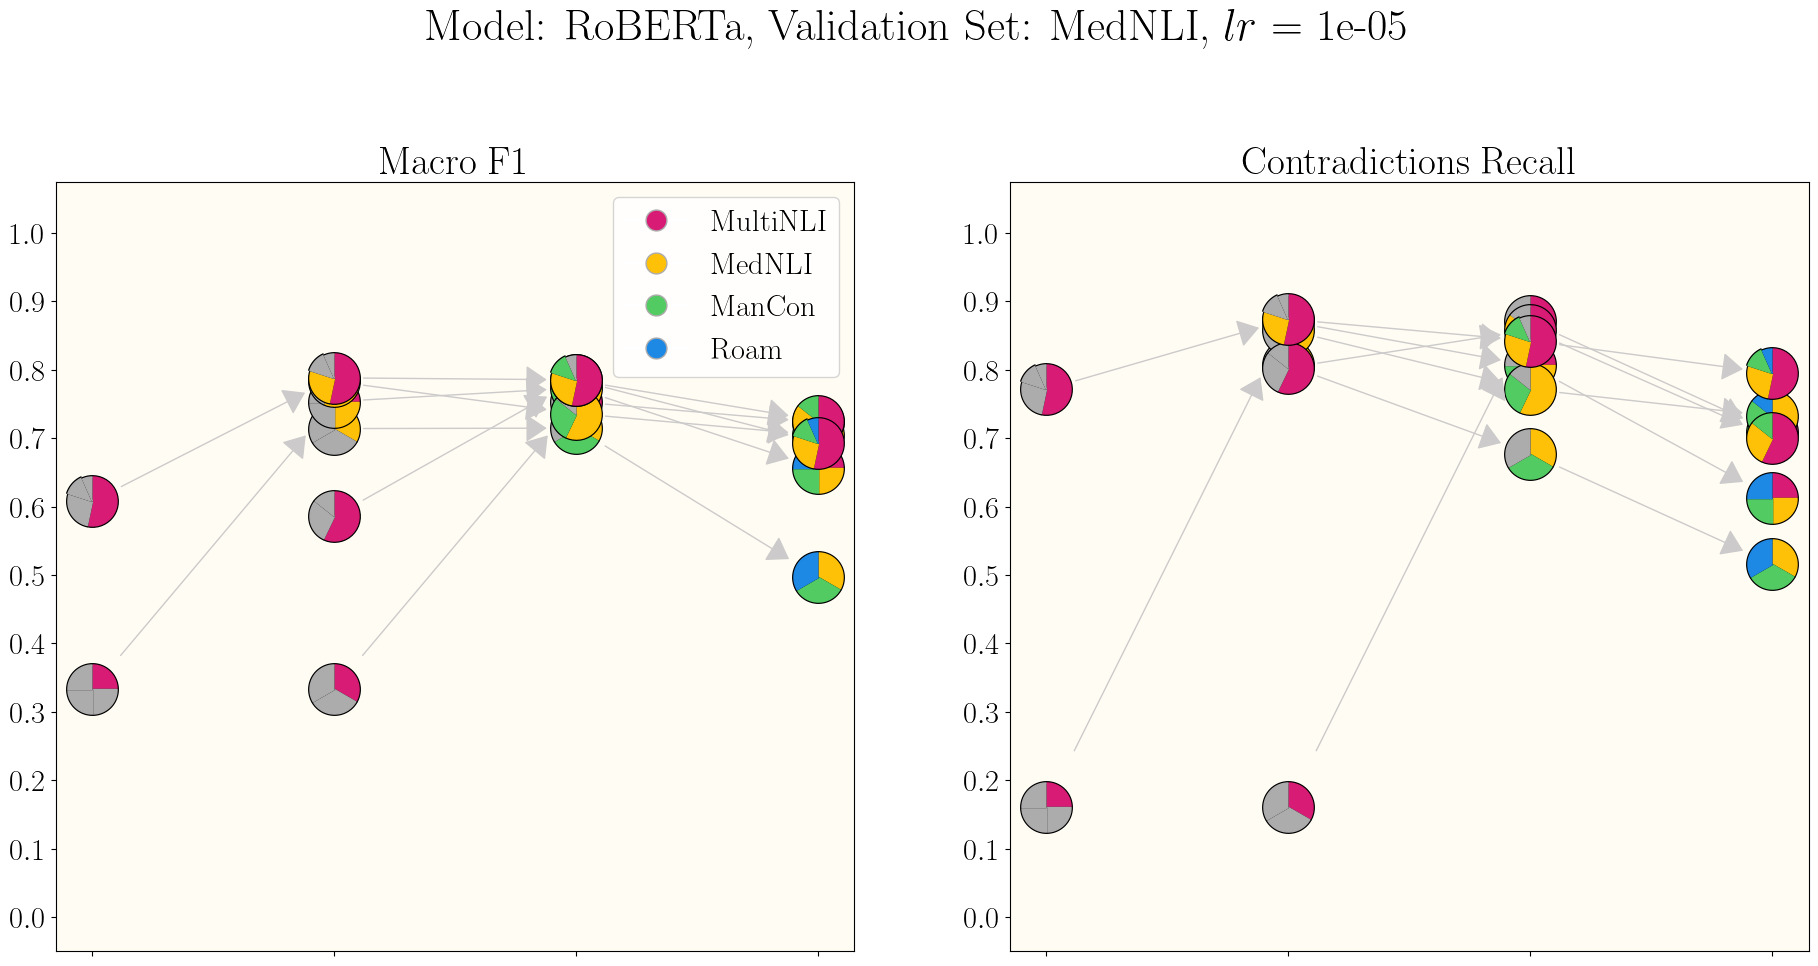

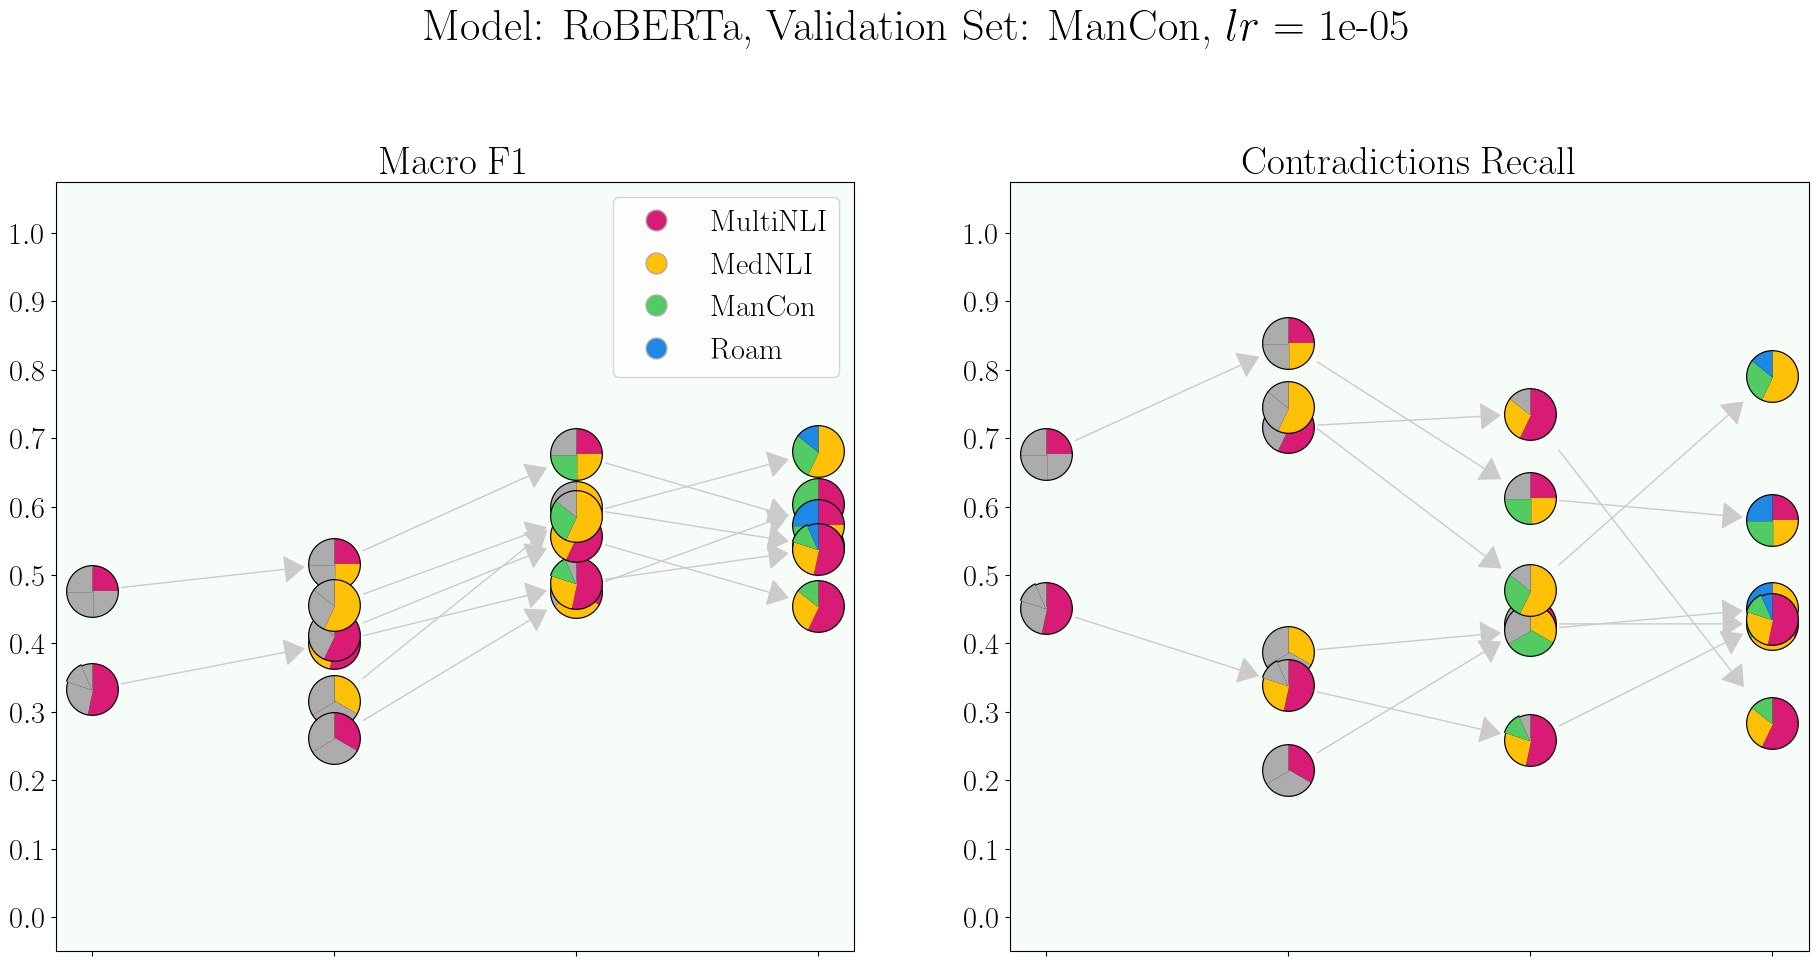

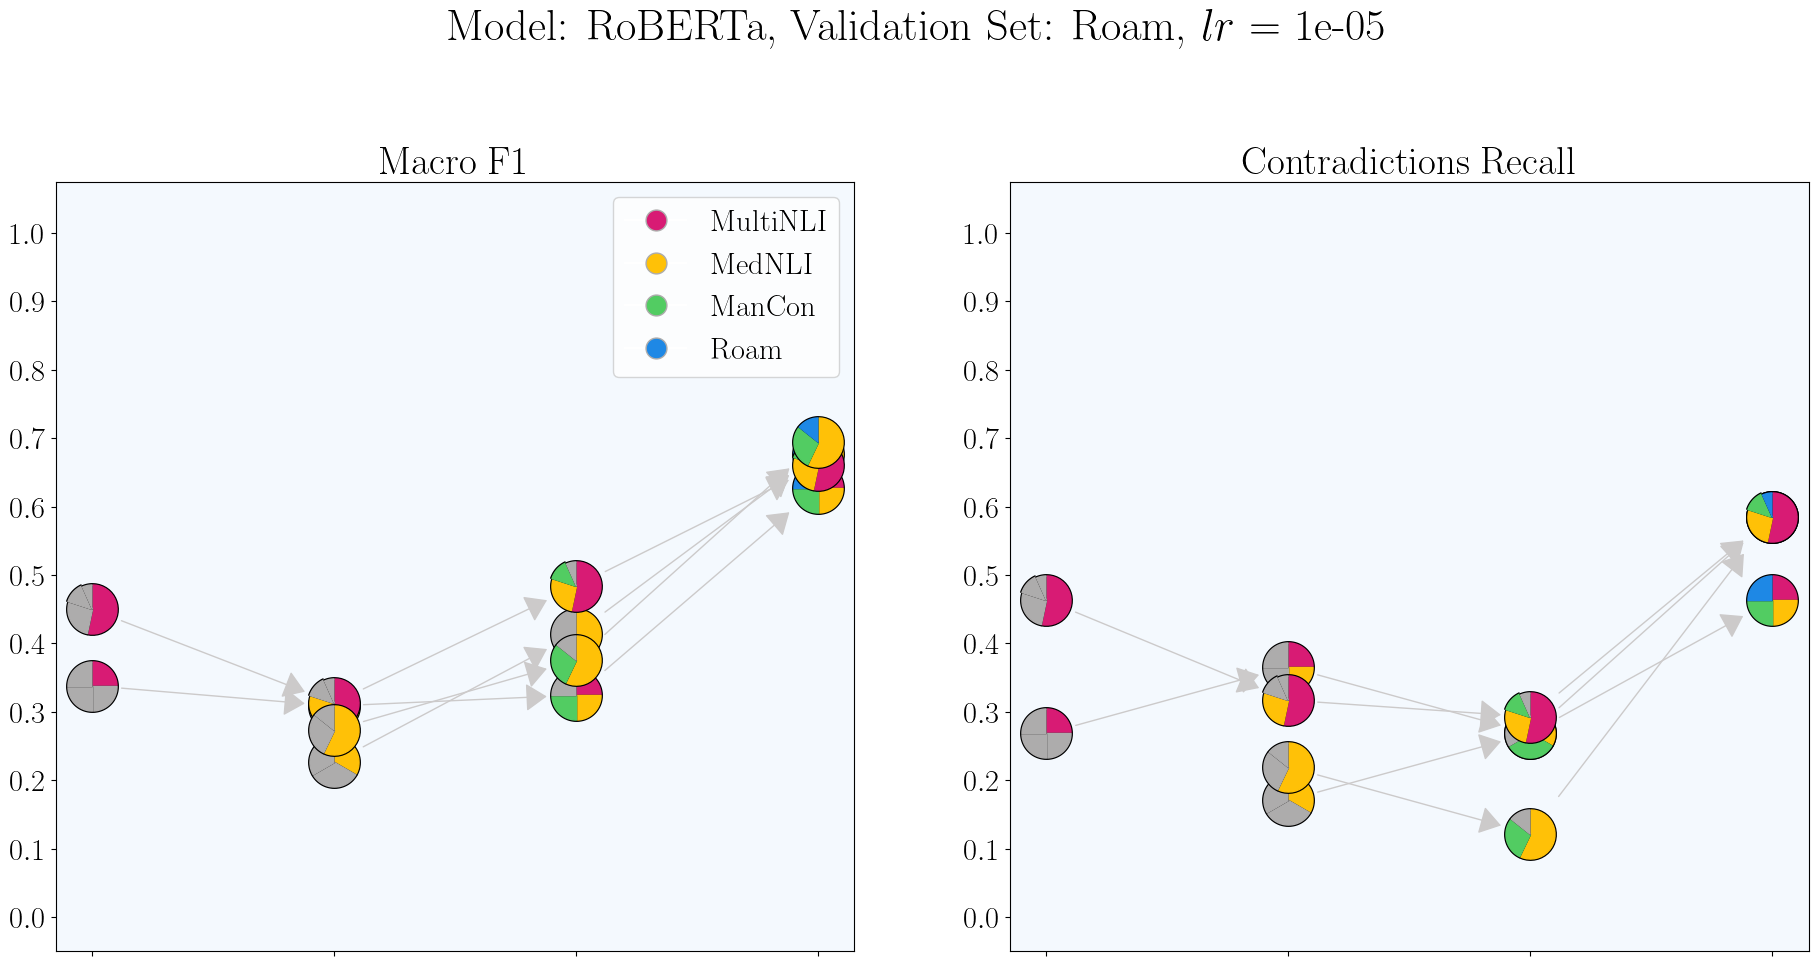

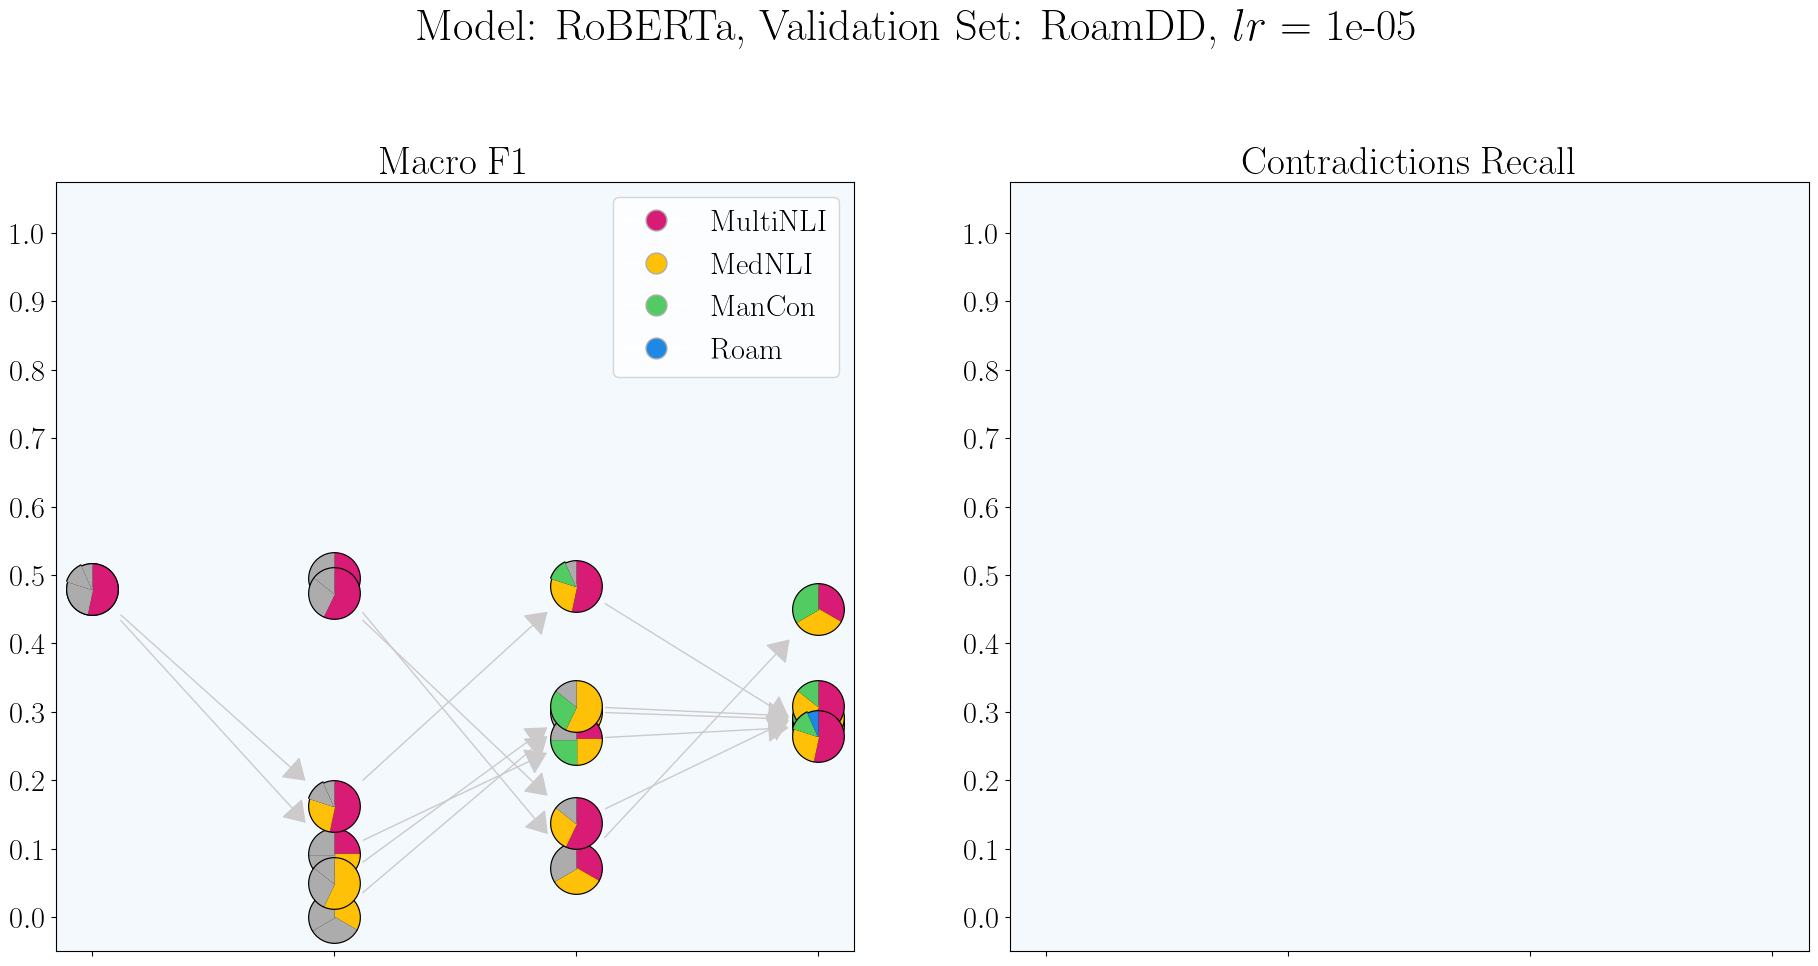

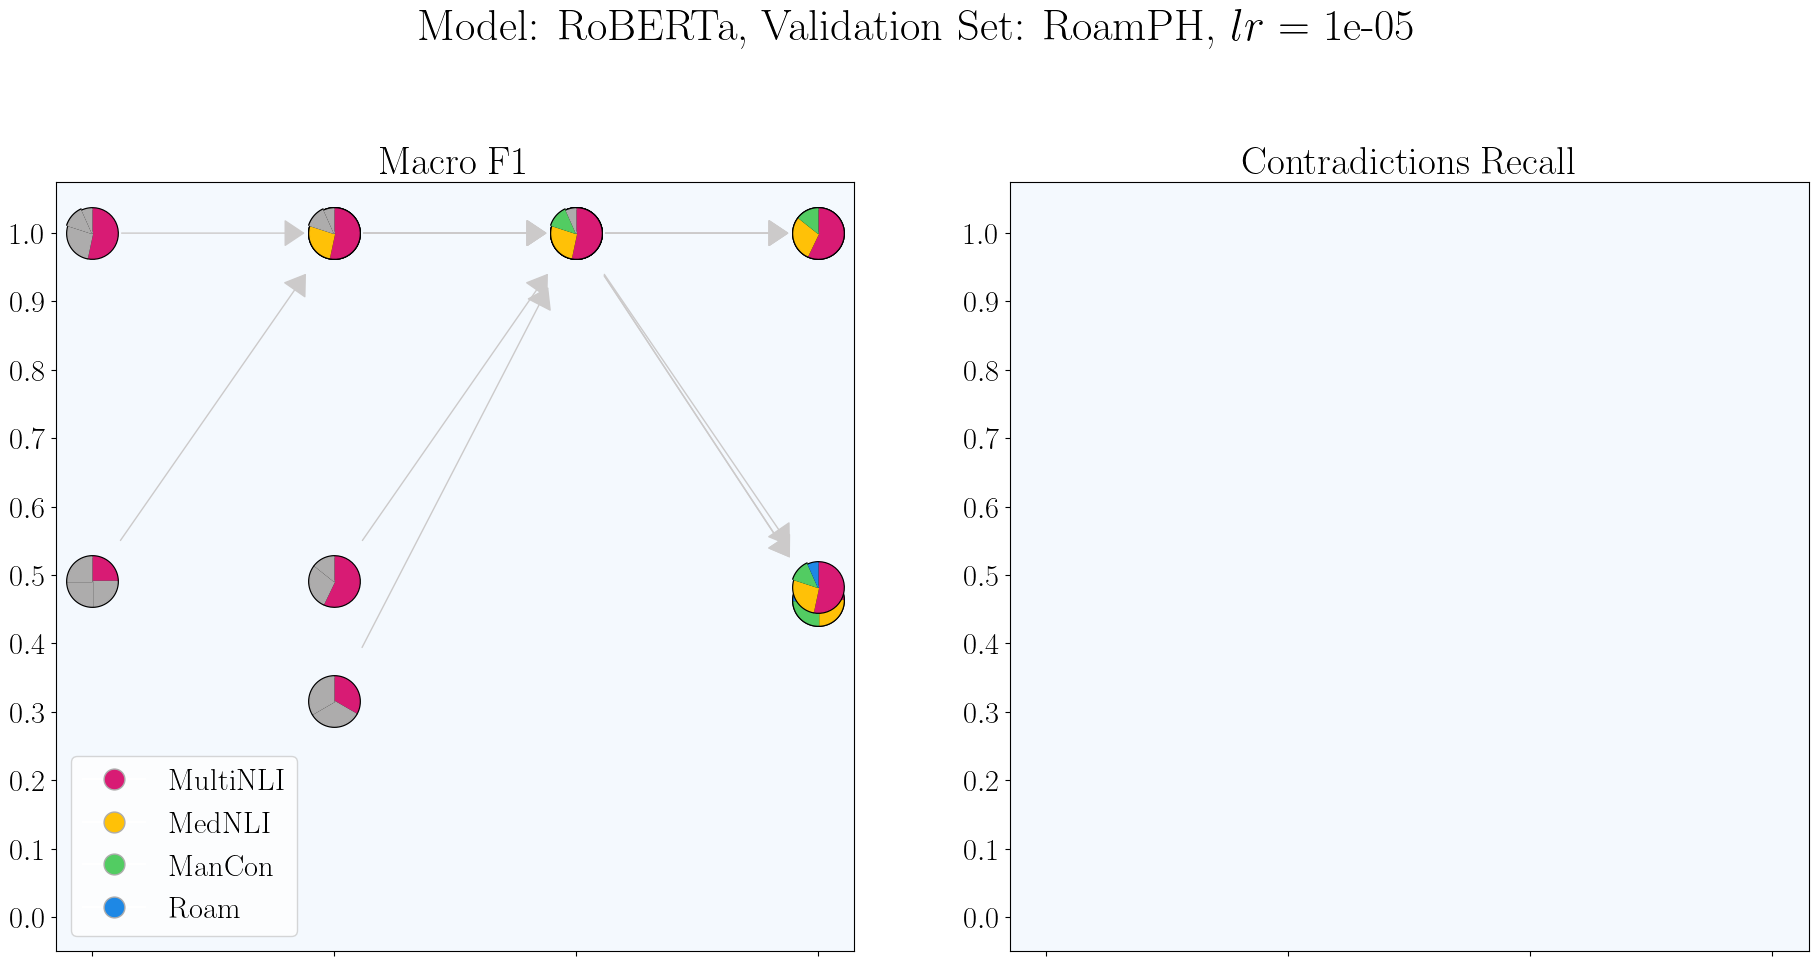

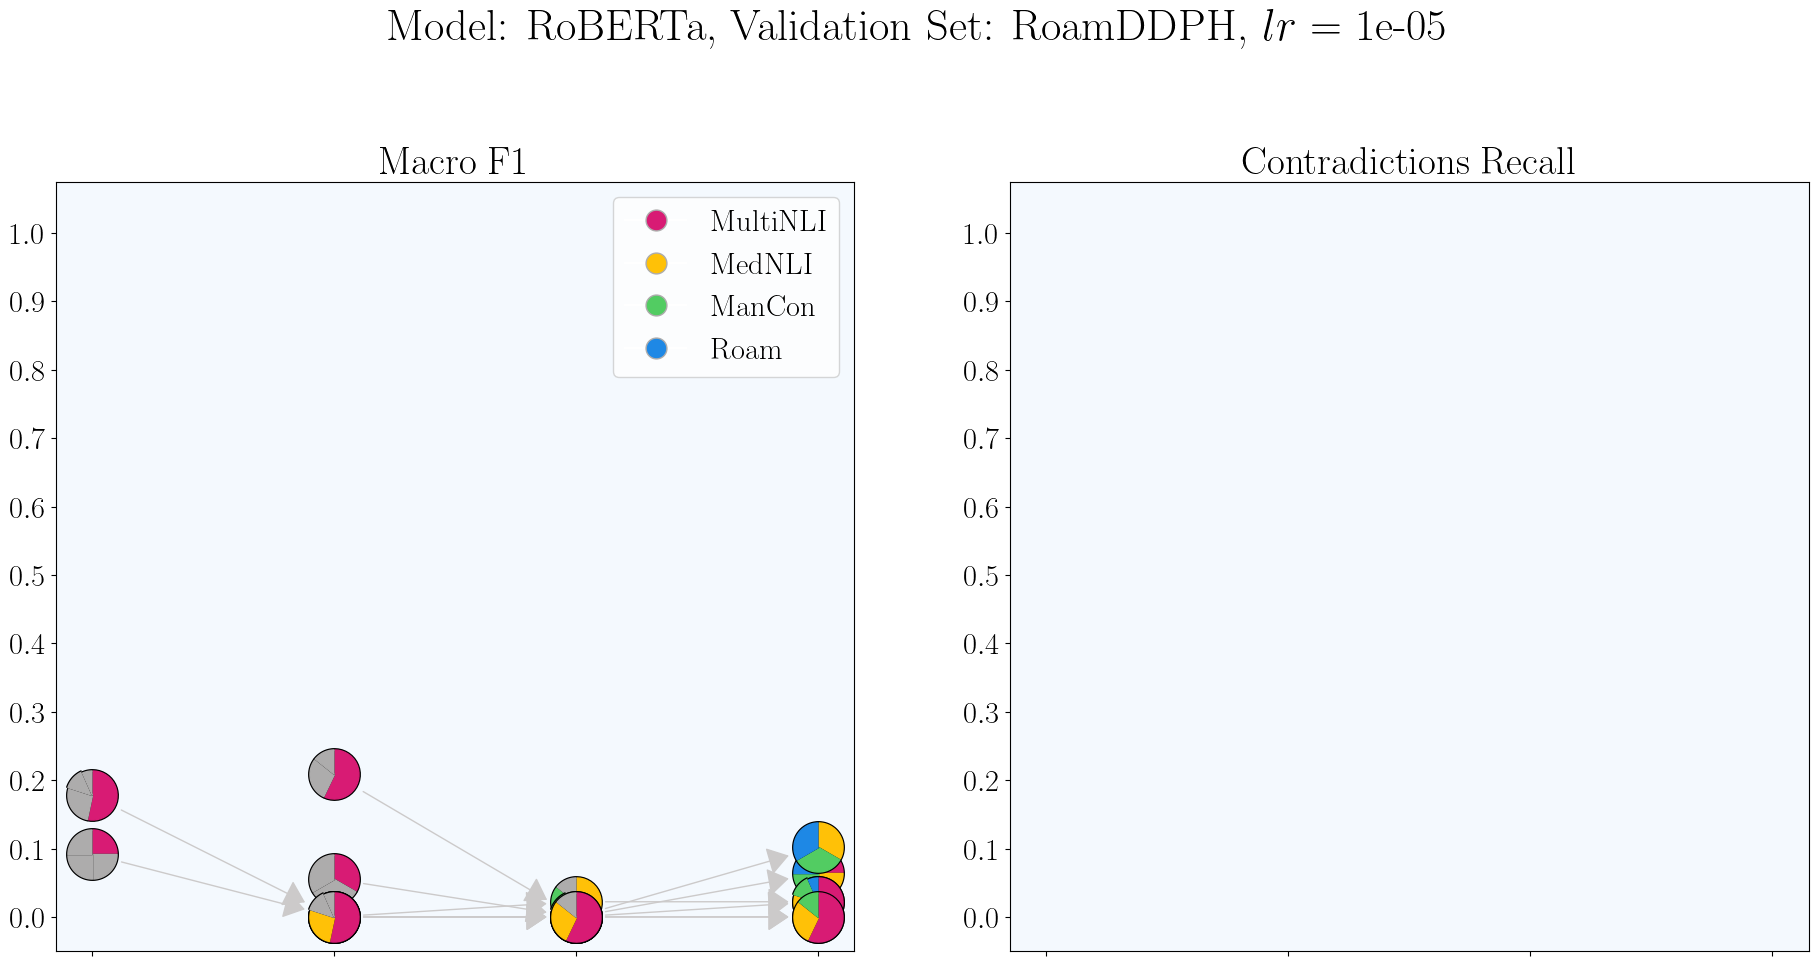

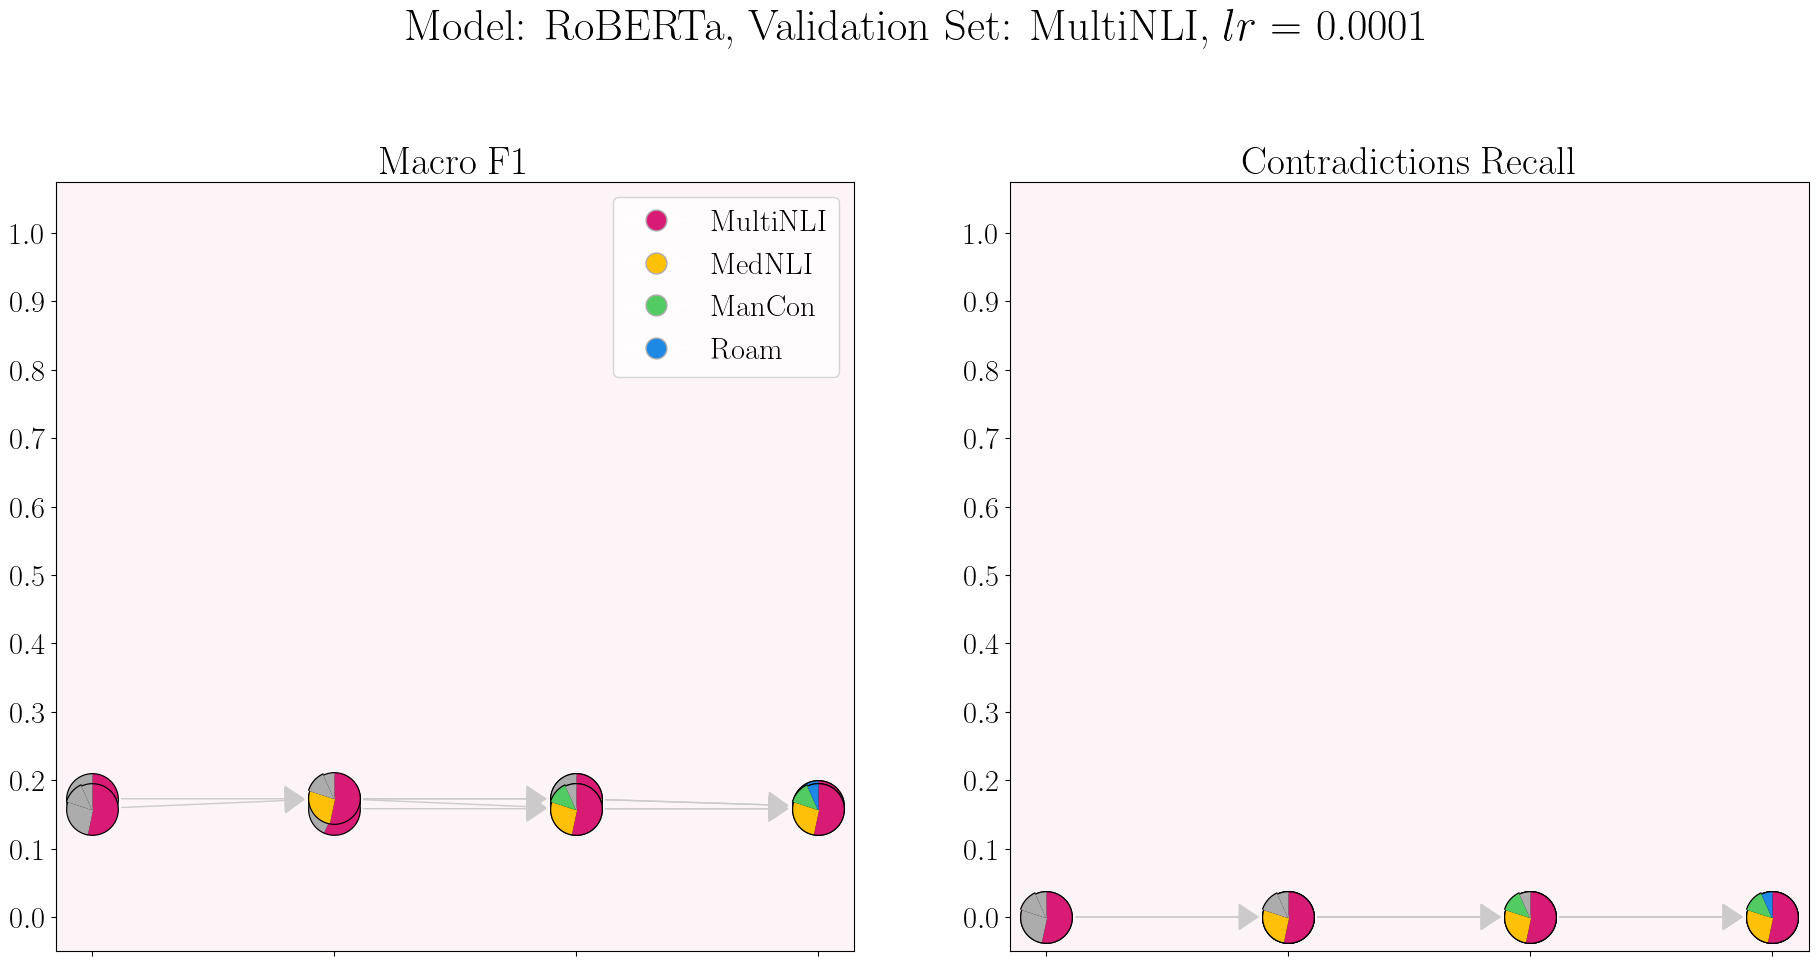

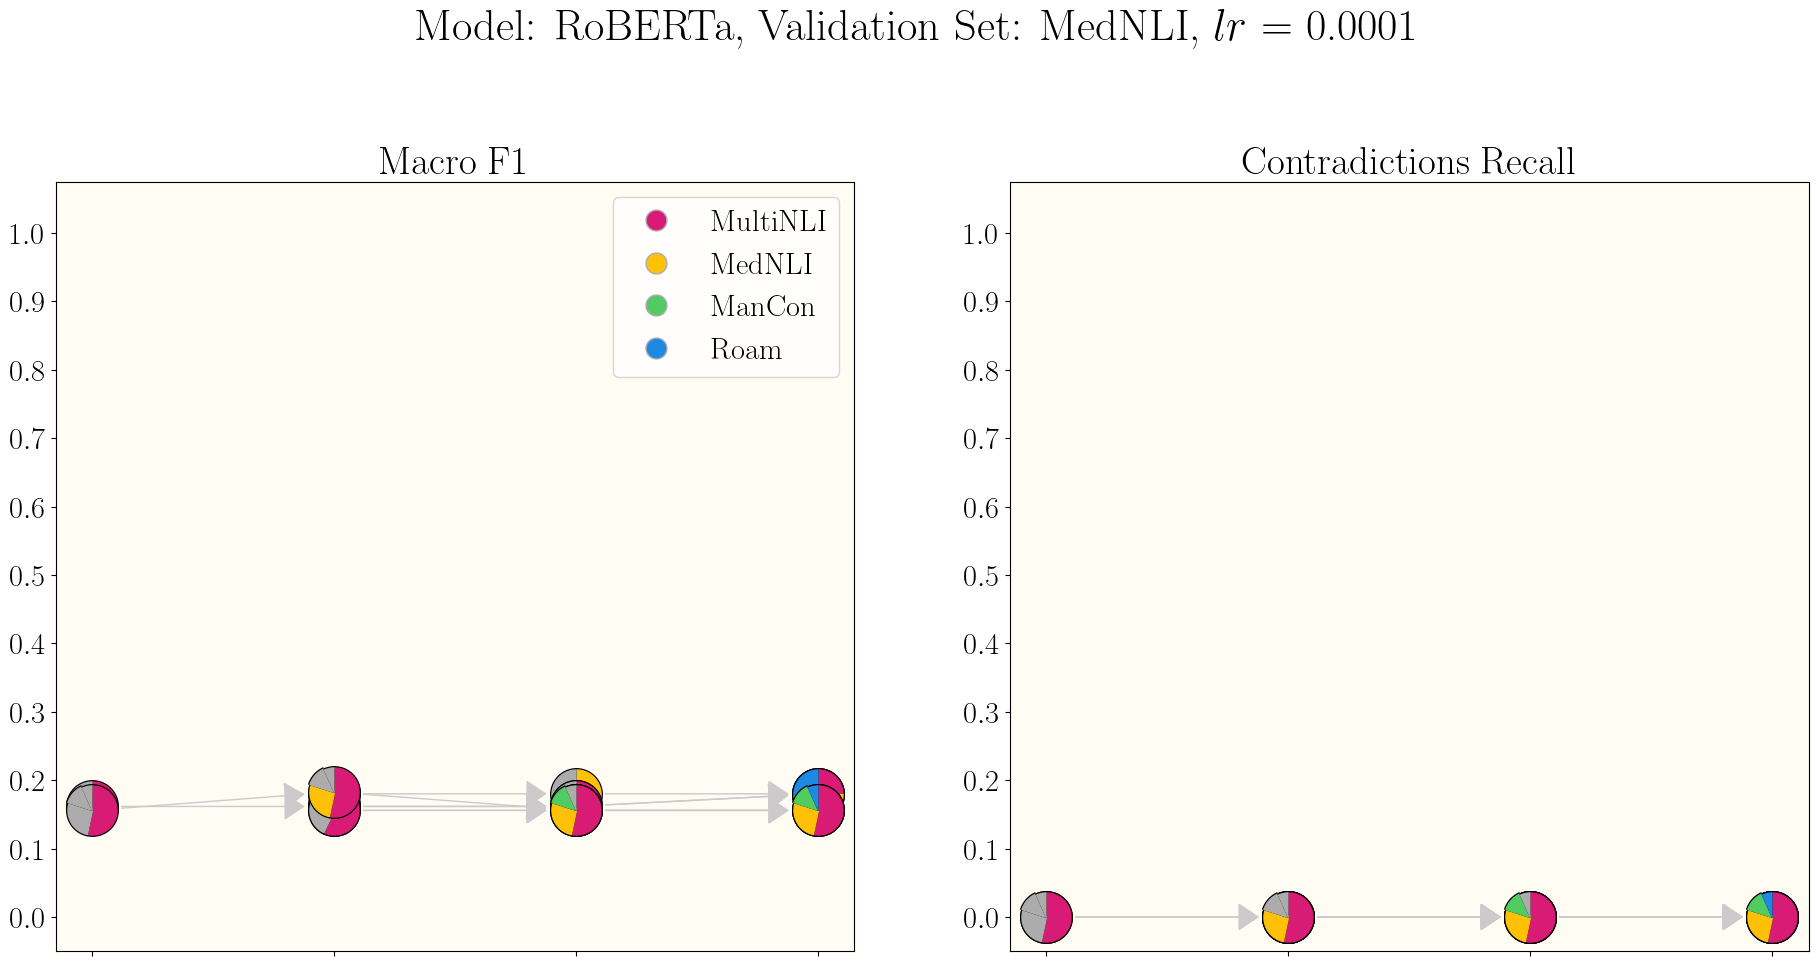

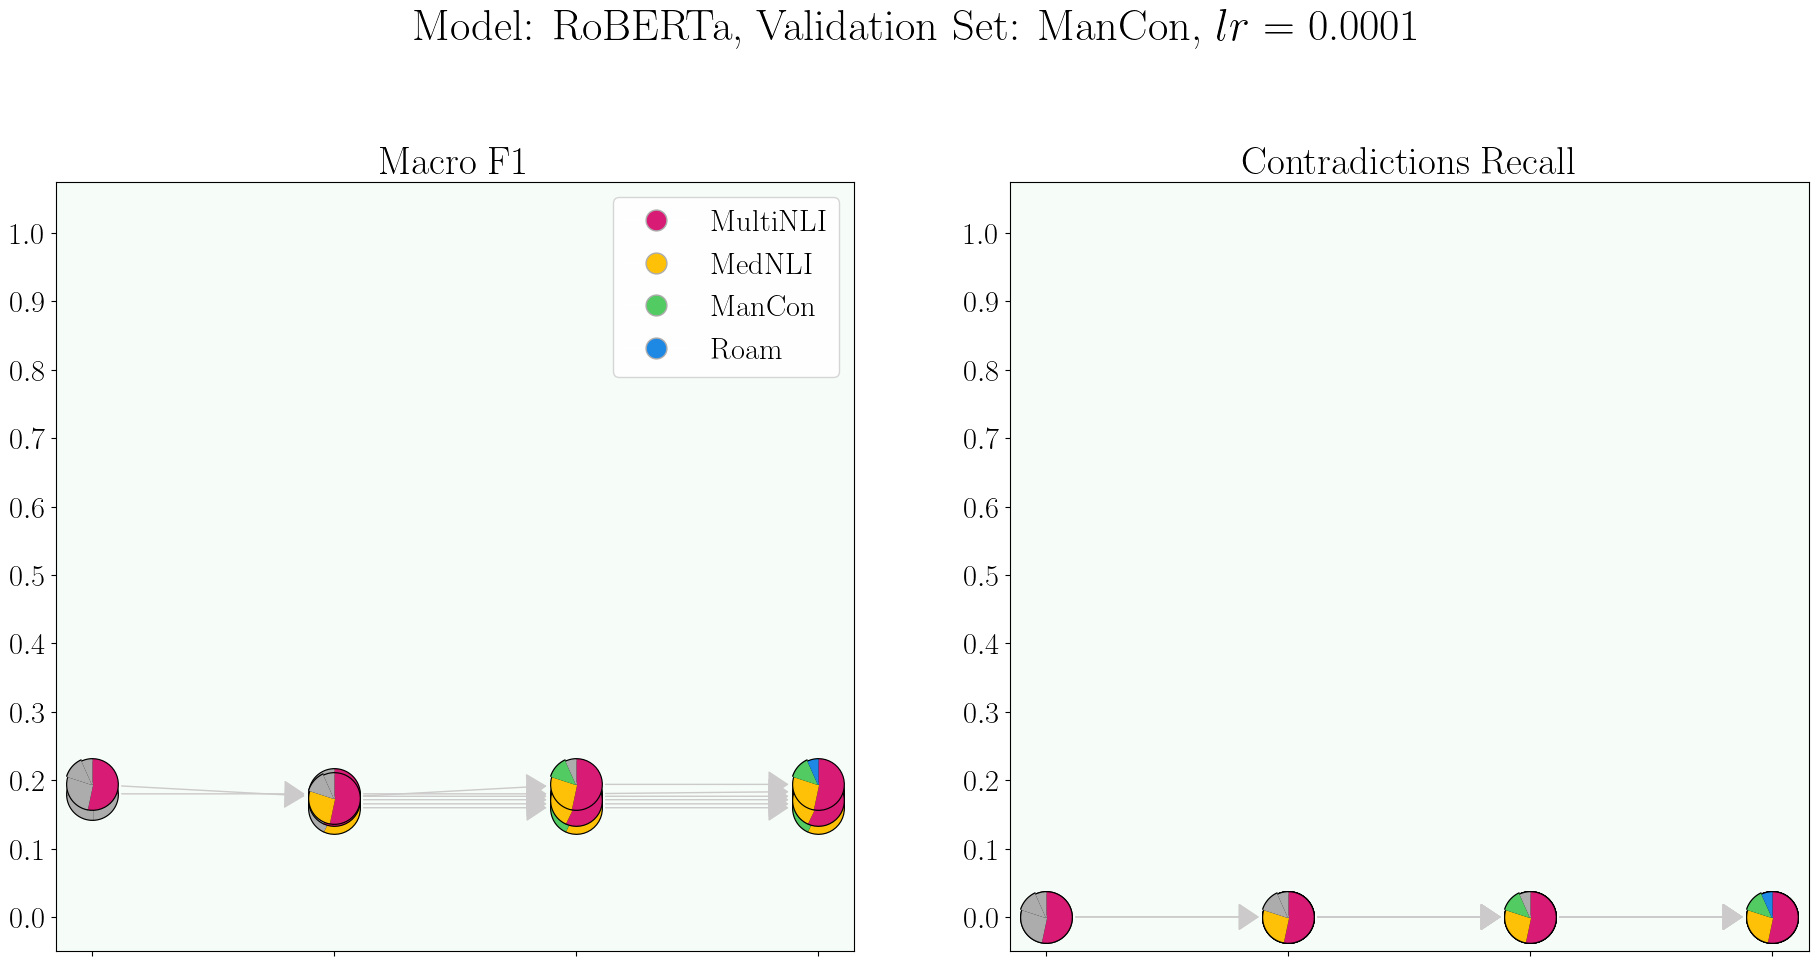

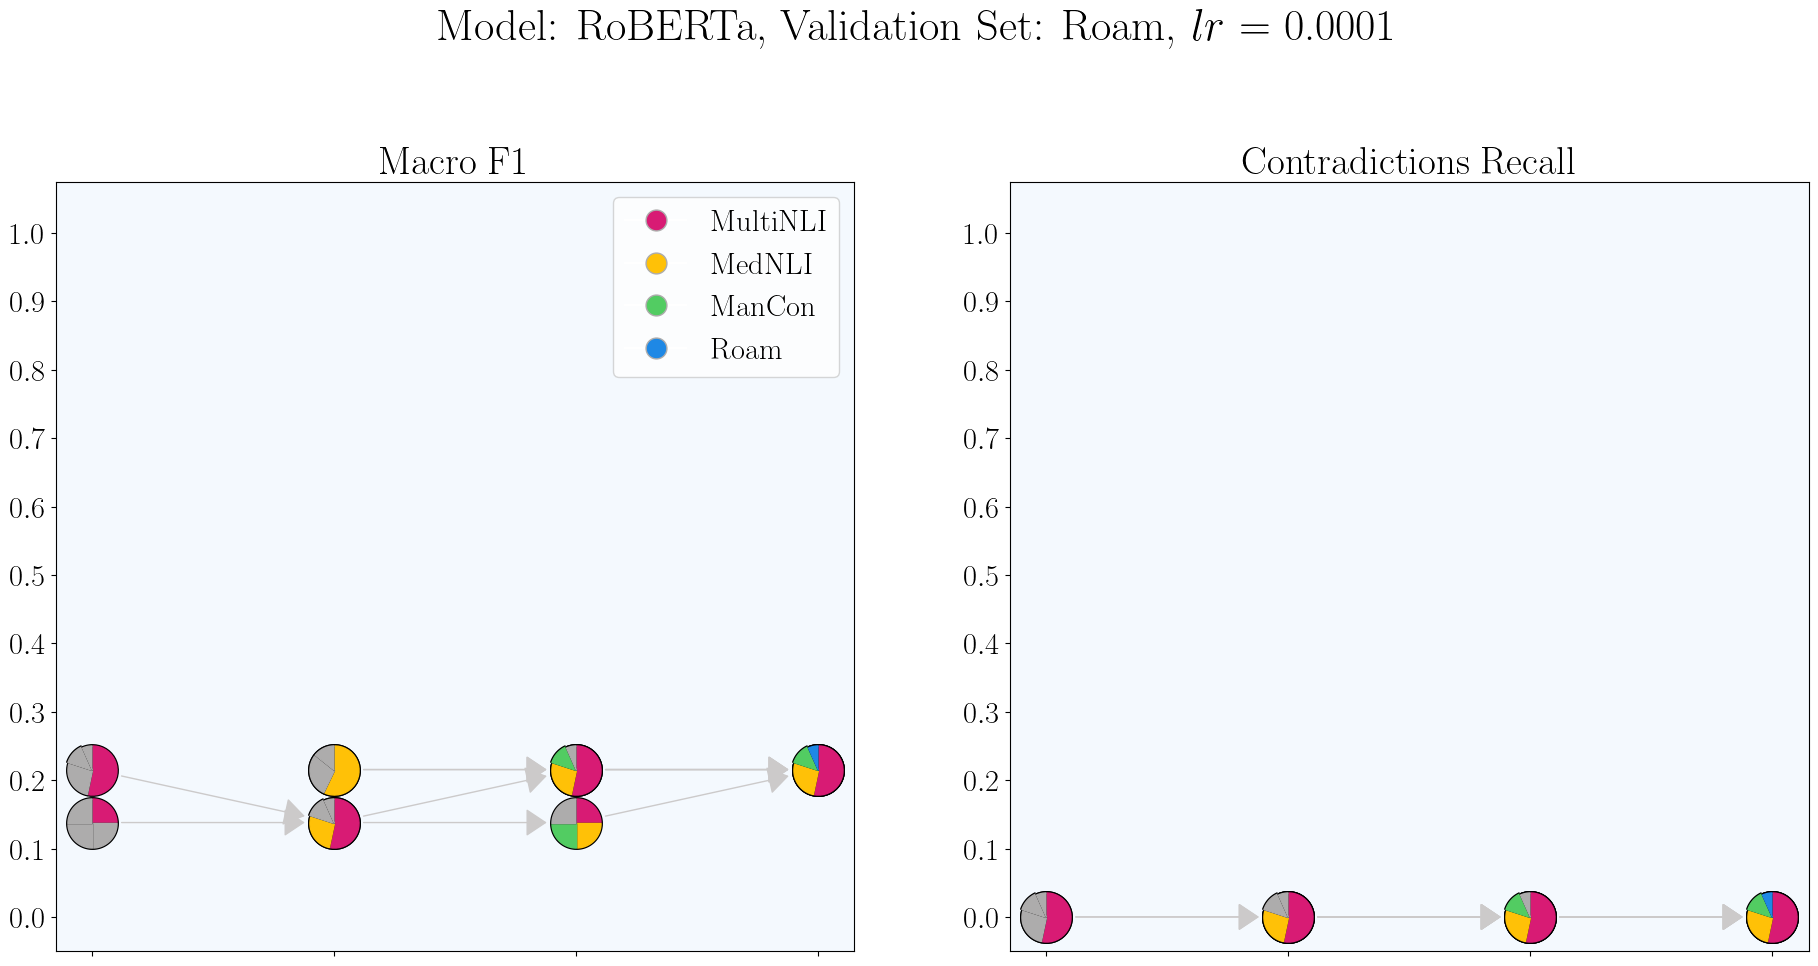

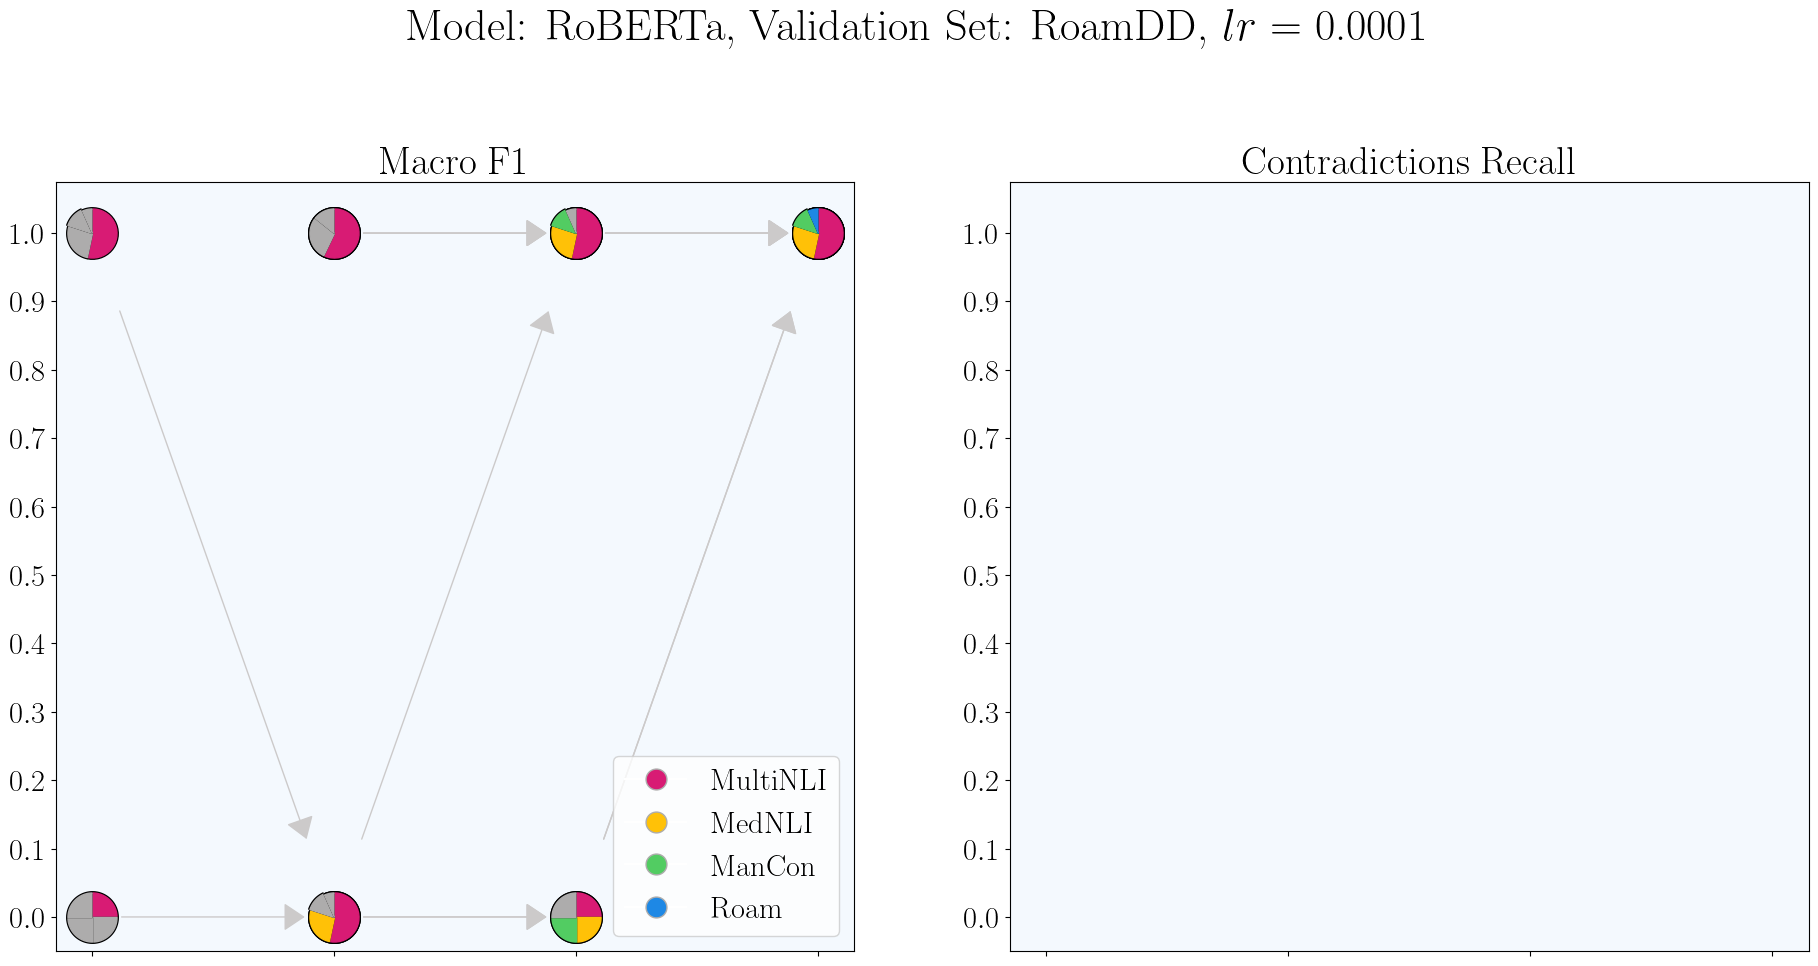

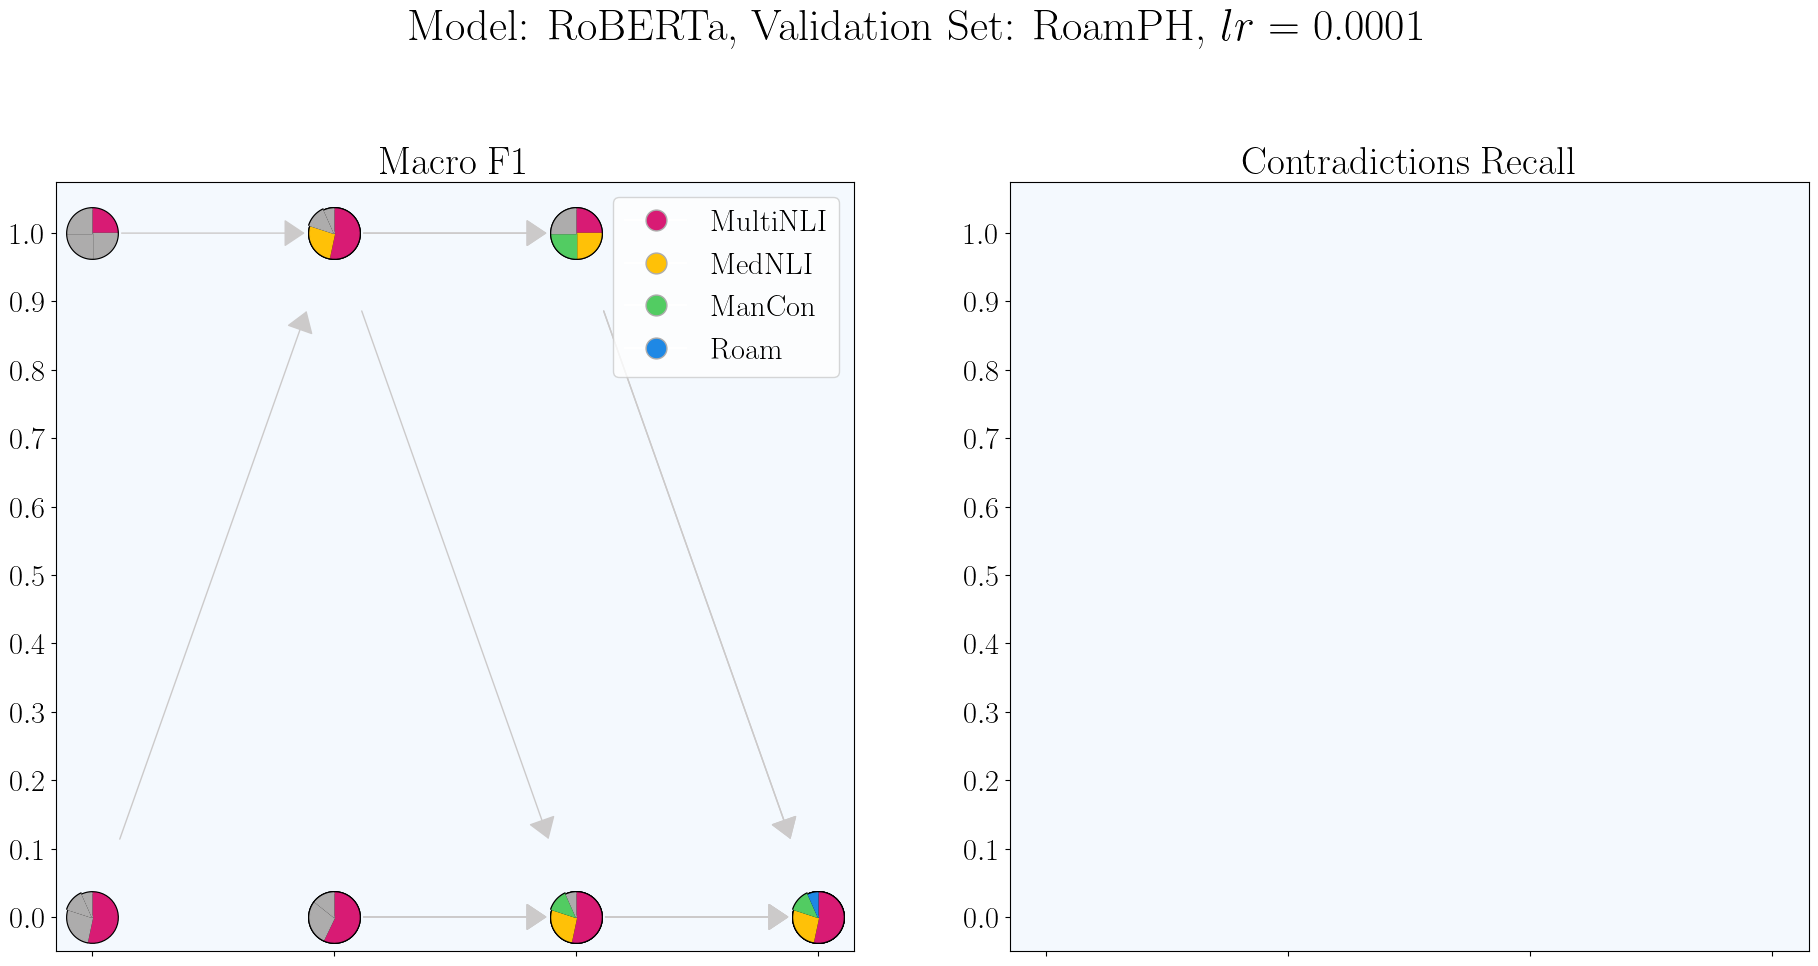

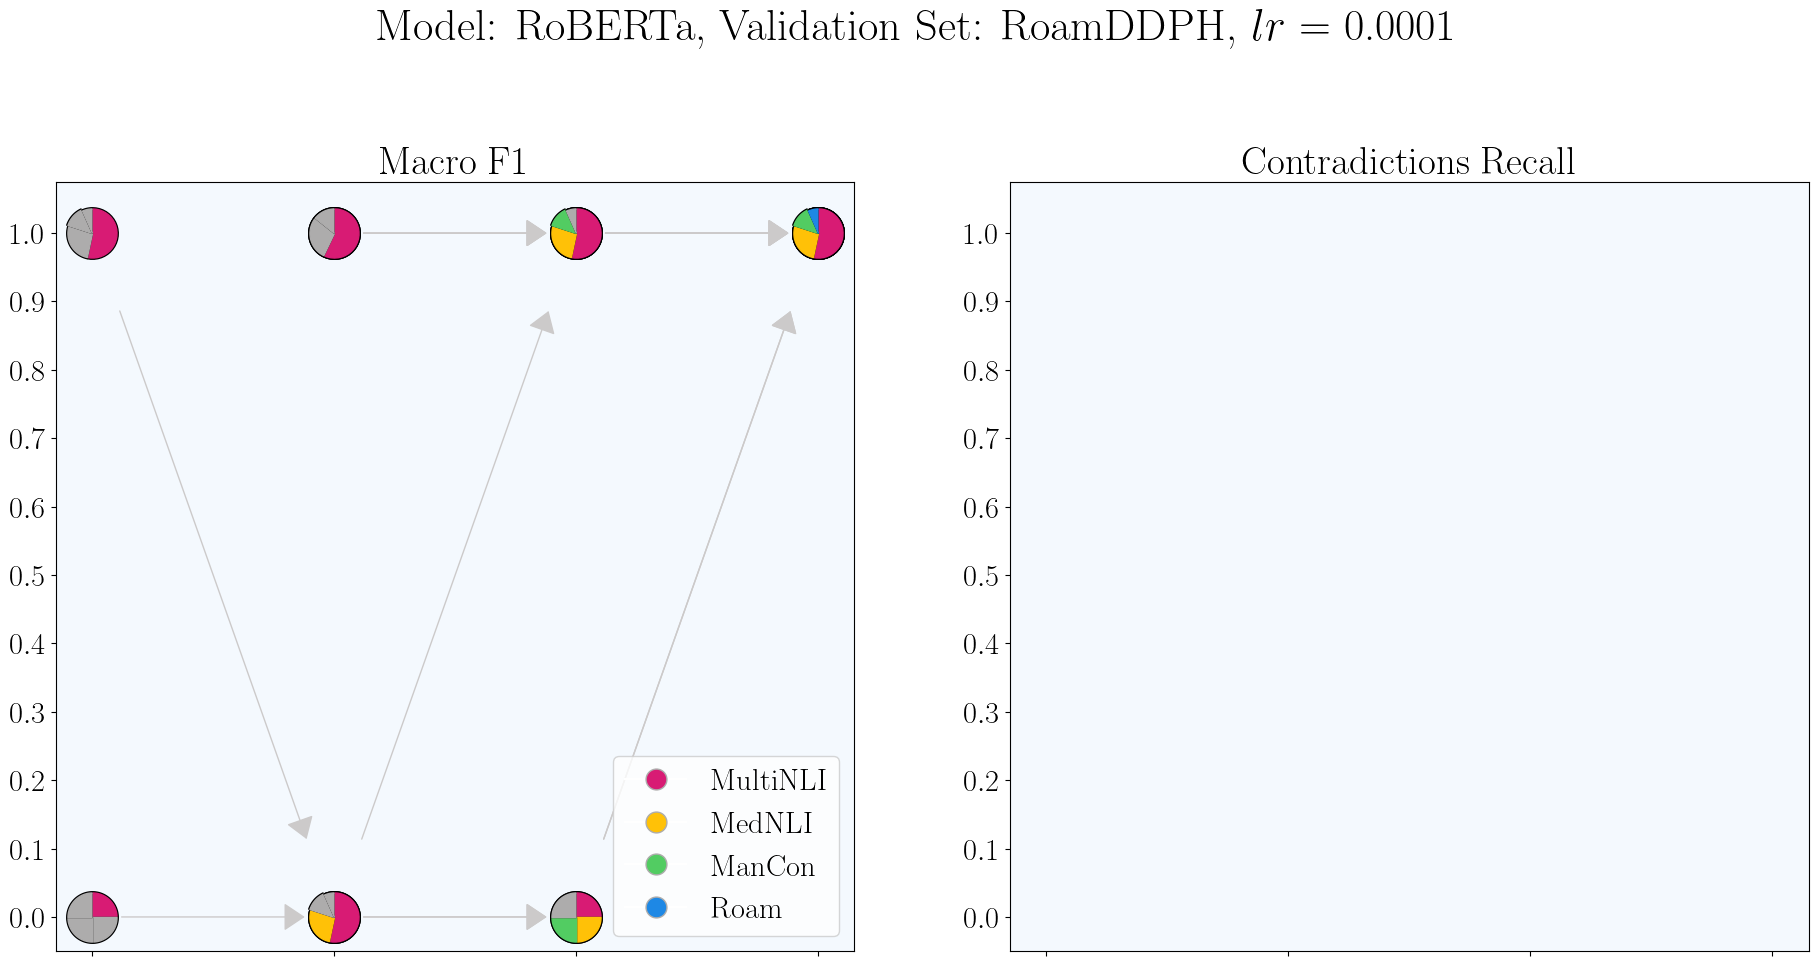

In [249]:
# Load the results
root = f"/Users/dnsosa/Desktop/AltmanLab/covid_lit_contra_claims/output/from_sherlock/"
experiment = "dataRatioSeqCompare"
model = "roberta"
metrics_to_vis = ["f1", "recall_con"]

data_ratio_df, test_in_df = draw_pie_seq_plot(root, experiment, model, metrics_to_vis)

,accuracy,f1,precision,recall,recall_con,Cumulative Training,Validation Set,train_datasets,eval_datasets,epochs,batch_size,learning_rate,truncation,train_prep_experiment,data_ratios,SEED,mancon_neutral_frac,mancon_train_frac,wandb_log_interval,cum_train_idx,Latest Training,tot_num_training_ds,model
14,0.560510,0.498209,0.567361,0.497995,0.268293,none_mednli_mancon_roam,roam,mednli_mancon_roam,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,3,pubmedbert
0,0.528662,0.449881,0.517723,0.472087,0.146341,none_roam,roam,roam,roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,1,pubmedbert
6,0.522293,0.448188,0.560058,0.449214,0.219512,none_mancon_roam,roam,mancon_roam,mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,2,pubmedbert
24,0.636943,0.555845,0.662247,0.555014,0.268293,none_multinli_mednli_mancon_roam,roam,multinli_mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,4,pubmedbert
14,0.541401,0.412745,0.658036,0.451491,0.073171,none_mednli_mancon_roam,roam,mednli_mancon_roam,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,3,scibert
0,0.496815,0.375705,0.471932,0.416694,0.048780,none_roam,roam,roam,roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,1,scibert
6,0.566879,0.469363,0.627995,0.491382,0.146341,none_mancon_roam,roam,mancon_roam,mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,2,scibert
24,0.566879,0.496091,0.614967,0.502439,0.219512,none_multinli_mednli_mancon_roam,roam,multinli_mednli_mancon_roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,4,scibert
14,0.509554,0.474806,0.529412,0.491924,0.243902,none_mednli_mancon_roam,roam,mednli_mancon_roam,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,3,biobert
0,0.471338,0.338608,0.294797,0.398916,0.000000,none_roam,roam,roam,roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roam,1,biobert


In [322]:
zz = ["hello"]
def perturb(x):
    x.append("bye")
    
print(zz)
perturb(zz)
print(zz)

['hello']
['hello', 'bye']


In [284]:
def draw_pie_scatter_model_comp(df, model_order, metric, ds_color_map, background_color, combined_color, size, in_ax, is_combined=False):
        
    num_ft_datasets = max(df.cum_train_idx)
    lowest_train_idx = min(df.cum_train_idx)
    for i, model in enumerate(model_order): 
        curr_df = df[df["model"]==model]
        #train_so_far = curr_df["Cumulative Training"].values[0]
        all_train_datasets = curr_df["train_datasets"].values[0].split("_")
        
        xpos, ypos = i, curr_df[metric].values[0]
    
        # for incremental pie slices
        data_ratio = curr_df["data_ratios"].values[0]
        dist = calculate_data_ratios_dist(all_train_datasets, data_ratio)
        cumsum = np.cumsum(dist)
        cumsum = cumsum/ cumsum[-1]
        pie = [0] + cumsum.tolist()

        for j, (r1, r2) in enumerate(zip(pie[:-1], pie[1:])):
                        
            train_j = all_train_datasets[j]
            color = ds_color_map[train_j]
            
            #if train_j in train_so_far:
            #    color = ds_color_map[train_j]
            #else:
            #    color = background_color
            
            angles = np.pi / 2 - np.linspace(2 * np.pi * r1, 2 * np.pi * r2, num=25)
            
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()
            
            xy = np.column_stack([x, y])
            
            if is_combined:
                in_ax.scatter([xpos], [ypos], marker=xy, s=size*2.25, color=combined_color, zorder=9)  # Drawing the border
                in_ax.scatter([xpos], [ypos], marker=xy, s=size, color=color, zorder=10)

            else:
                in_ax.scatter([xpos], [ypos], marker=xy, s=size*1.1, color="black")  # Drawing the border
                in_ax.scatter([xpos], [ypos], marker=xy, s=size, color=color)
                
    return None

In [307]:
from collections import OrderedDict


def draw_pie_seq_plot_model_comp(df, model_order, metrics_to_vis, highlight_forward_back=False):
    
    # Color and name parameters
    dataset_color_map = OrderedDict({"multinli": "#D81B74", "mednli": "#FFC107", "mancon": "#52CC62", "roam": "#1E88E5", "roamDD": "#1E88E5", "roamPH": "#1E88E5", "roamDDPH": "#1E88E5"})
    dataset_name_map = OrderedDict({"multinli": "MultiNLI", "mednli": "MedNLI", "mancon": "ManCon", "roam": "Roam", "roamDD": "RoamDD", "roamPH": "RoamPH", "roamDDPH": "RoamDDPH"})
    model_name_map = OrderedDict({"roberta": "RoBERTa", "pubmedbert": "PubMedBERT", "biobert": "BioBERT", "scibert": "SciBERT", "bioclinbert": "BioClinBERT"})
    background_color = "#adacac"
    combined_color = "#964B00"
    arrow_color = '#cccaca'

    # Nice names for metrics, model
    metrics = OrderedDict({"accuracy": "Accuracy",
                           "f1": "Macro F1",
                           "precision": "Precision",
                           "recall": "Recall",
                           "recall_con": "Contradictions Recall"})

    # Set of metrics to visualize
    #metrics_to_vis = metrics.keys()

    for lr in set(df["learning_rate"]):
        # Get the dataframe for each learning rate
        sub_df = df[df["learning_rate"] == lr]

        # Plot a row of figures, one per val set
        ##for val_set, val_set_official in dataset_name_map.items():
        for val_set, val_set_official in [("roam", "Roam")]:

            # Create a row of figures, one per metric
            if len(metrics_to_vis) == 5:
                fig, axs = plt.subplots(1, len(metrics_to_vis), figsize=(28,6))
            else:
                fig, axs = plt.subplots(1, len(metrics_to_vis), figsize=(20, 13))
            fig.tight_layout(pad=3.0)
            fig.suptitle(f'Validation Set: {val_set_official}, $lr$ = {lr}', y=1.07)

            # Create the subset of the DF for this val set
            in_df = sub_df[sub_df["Validation Set"] == val_set]
            val_color = lighten_color(dataset_color_map[val_set], 0.95)

            # Create a panel for each metric
            for i, metric in enumerate(metrics_to_vis):

                # Some parameters for each panel
                axs[i].set_title(metrics[metric])
                axs[i].set_facecolor(val_color)
                axs[i].xaxis.set_ticks(np.arange(5))
                axs[i].set_xticklabels(list(map(model_name_map.get, model_order)))
                #axs[i].yaxis.set_ticks(np.arange(.2,.8,.1))
                #axs[i].set_ylim([.25,.75])
                axs[i].yaxis.set_ticks(np.arange(0,1.1,.1))
                axs[i].set_ylim([-.05,1.075])
                #axs[i].set_xlim([-.25, 5.25])
                
                # If there are multiple data ratios present, need to iterate through both
                for data_ratio in set(in_df.data_ratios):
                    
                    in_df_ratio = in_df[in_df.data_ratios == data_ratio]

                    # Plot individual sequences on each panel
                    for seq in get_seq_plot_order(in_df_ratio, metric):          

                        # Filter in the subset of results relevant for this sequence
                        seq_df_all = in_df_ratio[in_df_ratio["train_datasets"] == seq]
                        seq_df_combined = seq_df_all[seq_df_all['train_prep_experiment'] == "combined"]
                        found_combined = len(seq_df_combined) > 0
                        seq_df = seq_df_all[seq_df_all['train_prep_experiment'] == "sequential"]

                        # Draw my custom pie scatter plot
                        draw_pie_scatter_model_comp(seq_df, model_order=model_order, metric=metric, ds_color_map=dataset_color_map, background_color=background_color, combined_color=combined_color, size=1250, in_ax=axs[i])
                        if found_combined:
                            draw_pie_scatter_model_comp(seq_df_combined, model_order=model_order, metric=metric, ds_color_map=dataset_color_map, background_color=background_color, combined_color=combined_color, size=1250, is_combined=found_combined, in_ax=axs[i])
                        # Draw arrows between pies
                        #draw_arrows(seq_df, metric=metric, x_pad=0, arrow_prox=.89, arrow_color=arrow_color, y_text_pad=.05, highlight_forward_back=highlight_forward_back, in_ax=axs[i])
                        # Draw legend for the left-most panel

                combined_in_panel = "combined" in set(in_df.train_prep_experiment)
                draw_custom_legends(in_df, ds_color_map=dataset_color_map, ds_name_map=dataset_name_map, background_color=background_color, combined_color=combined_color, val_ds=val_set, val_color=val_color, show_combined=combined_in_panel, in_ax=axs[i])

            # Display this row of figs
            plt.show()

            #break
        #break
    return df, in_df # DELETE SECOND RETURN


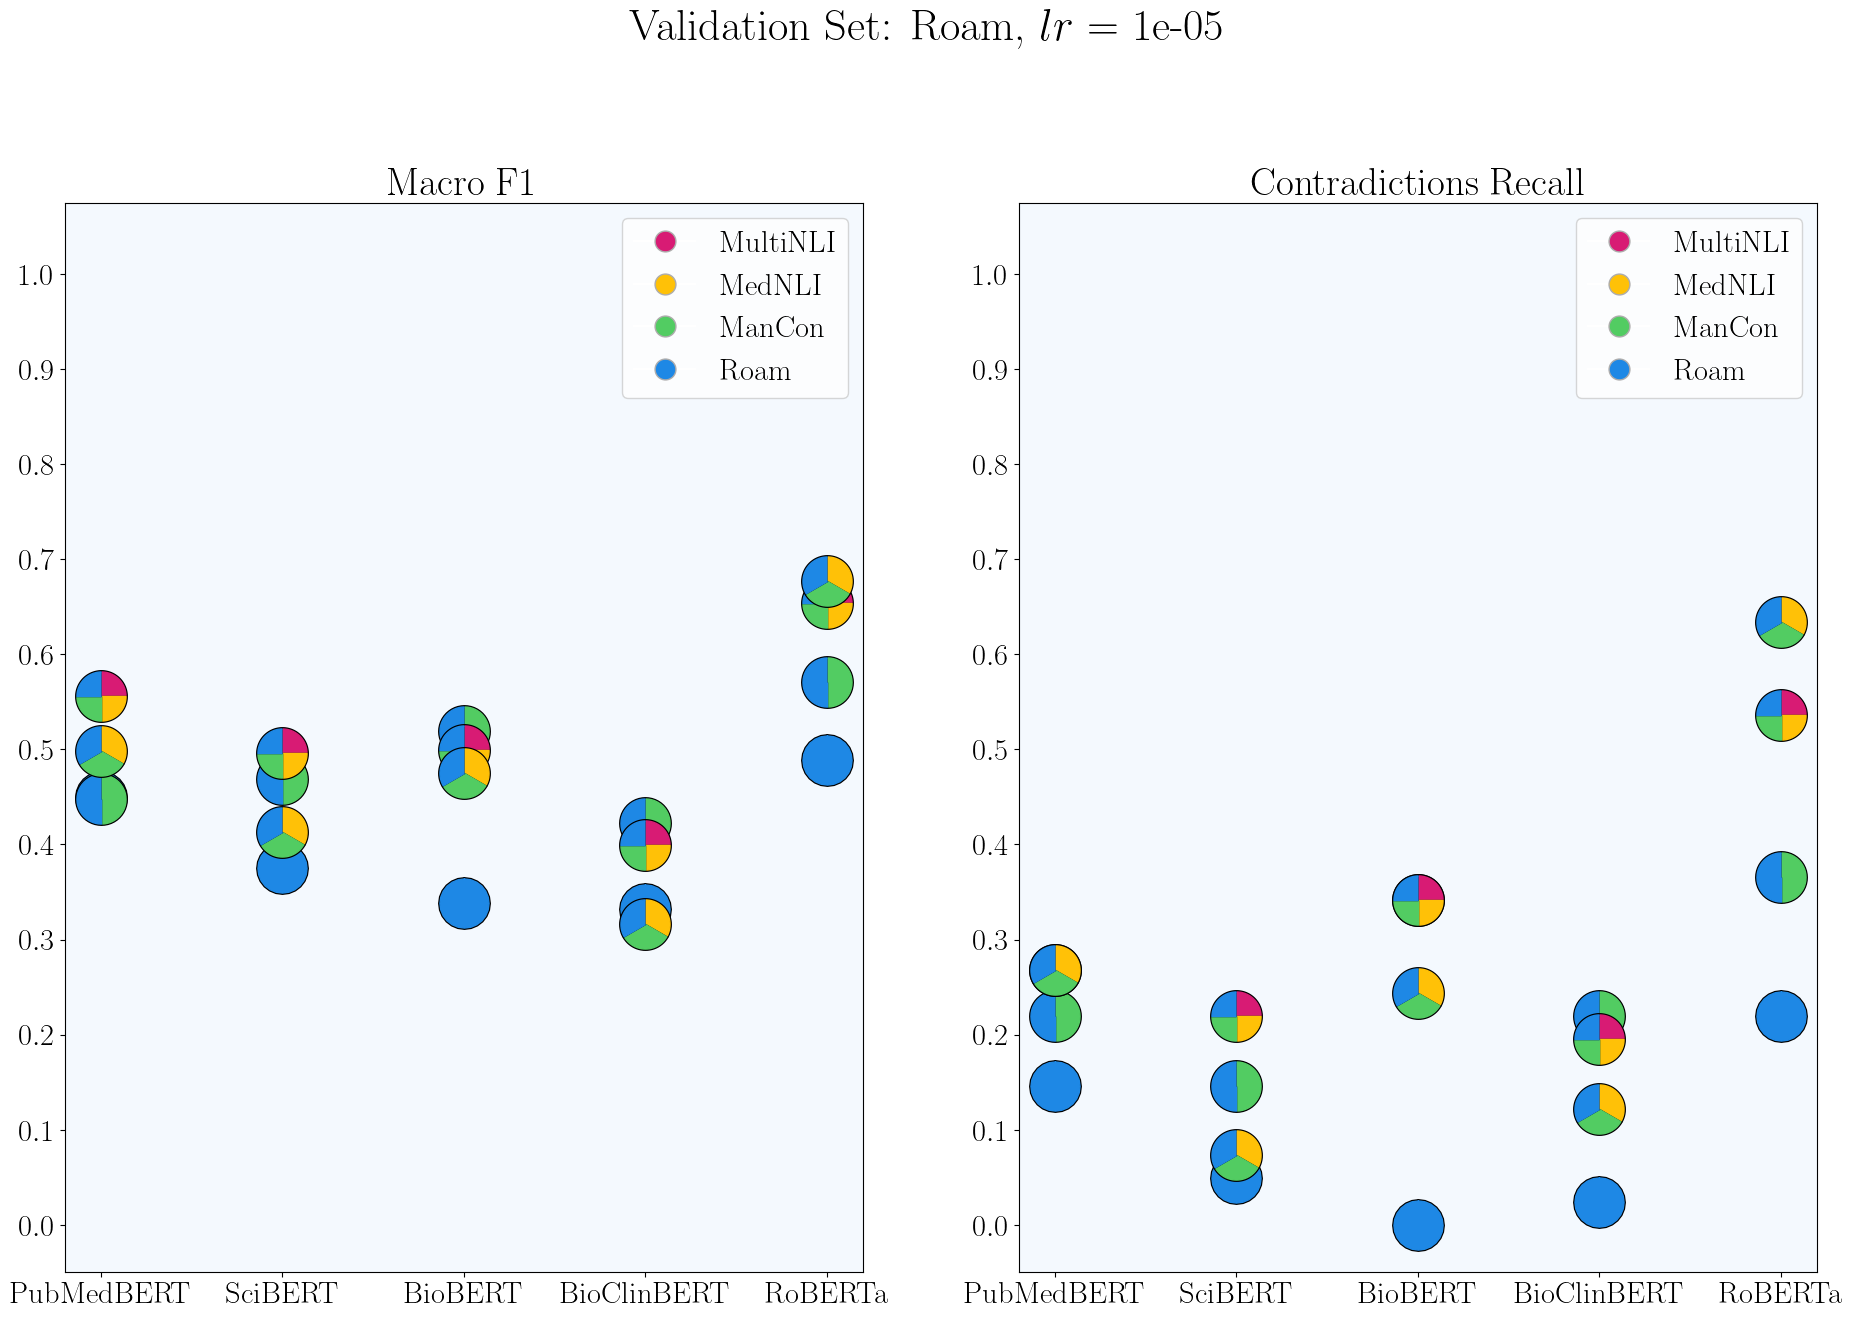

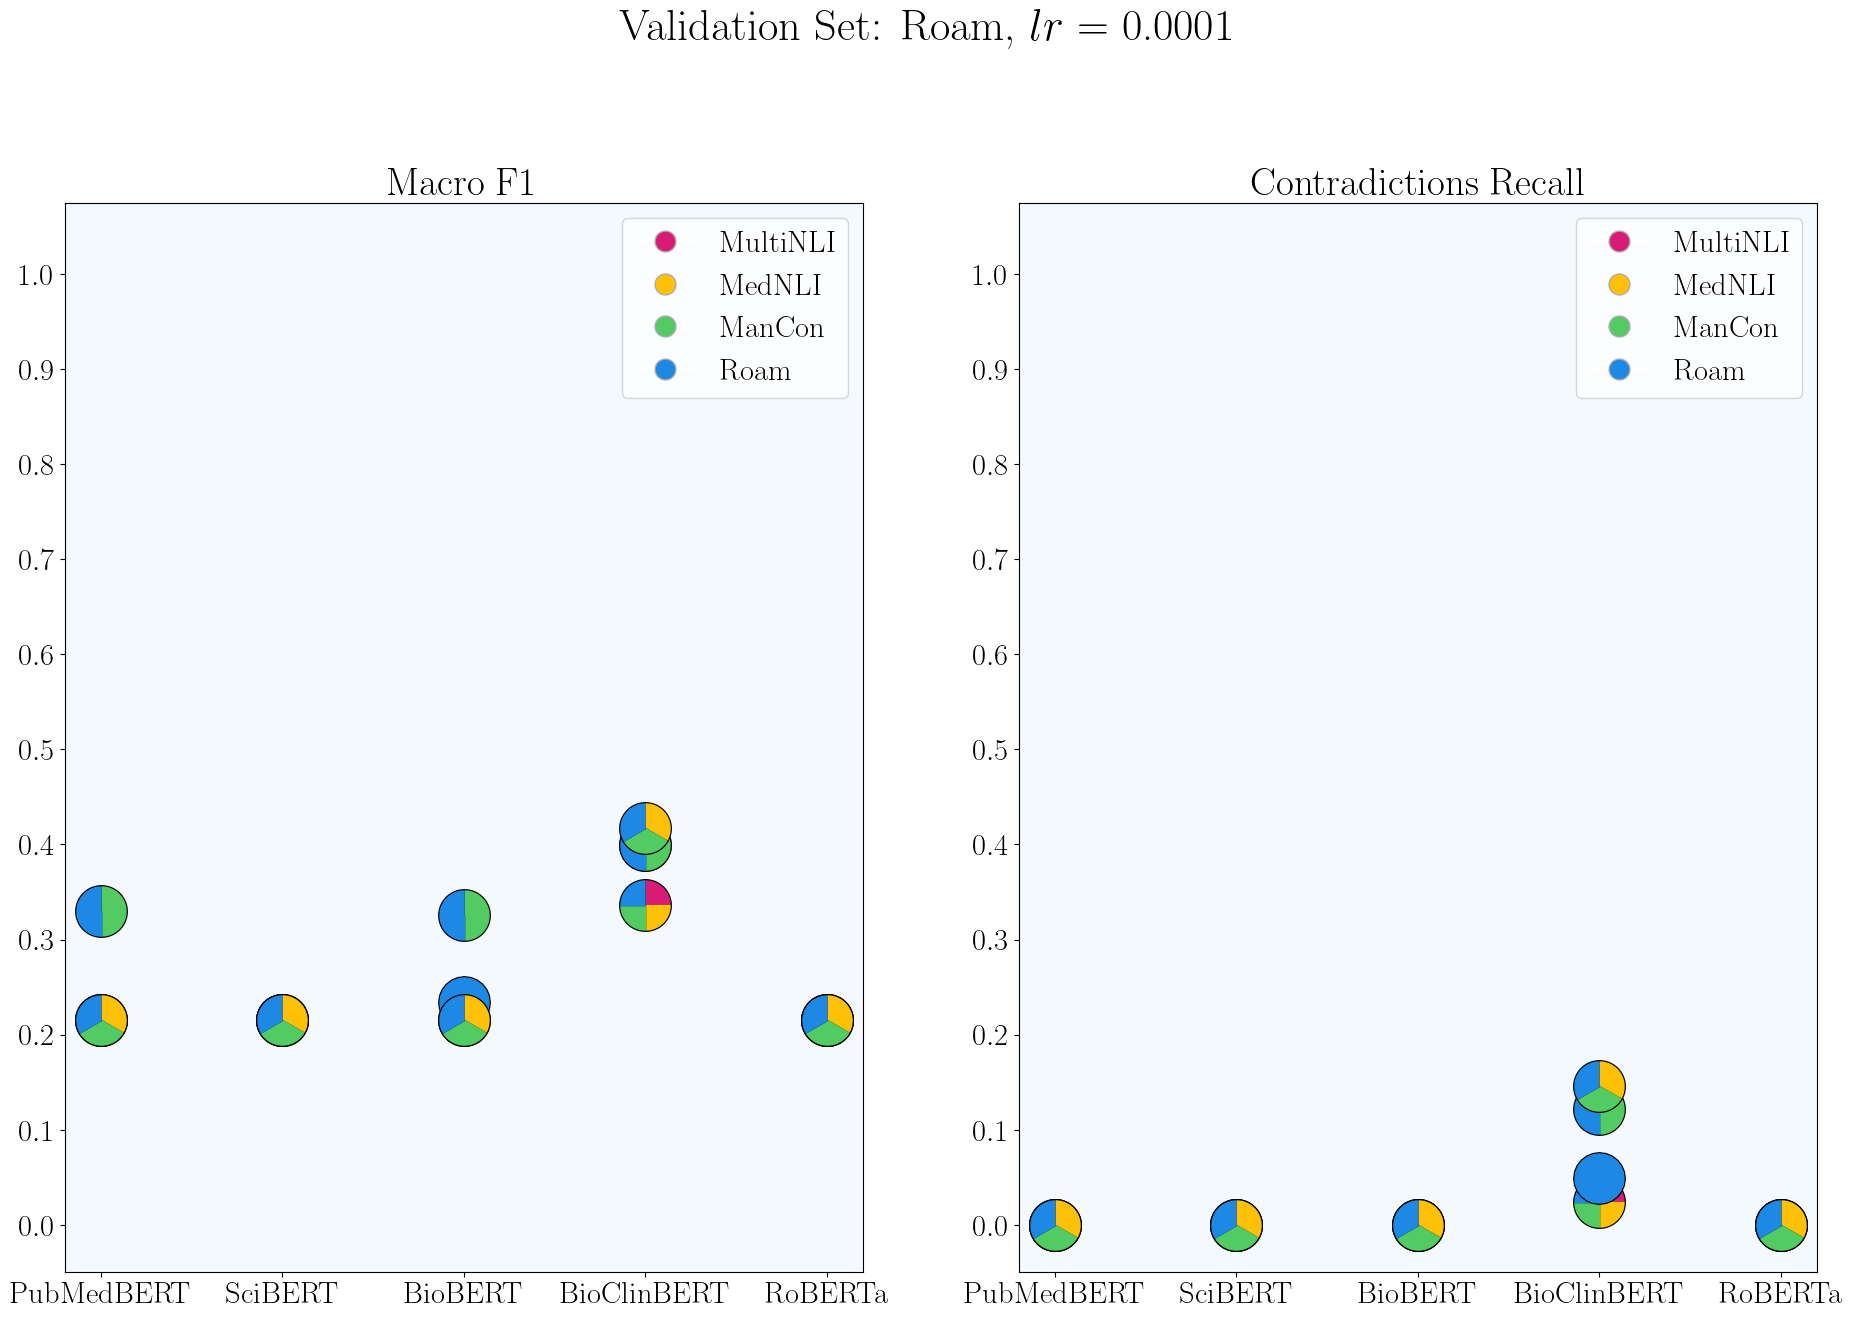

In [308]:
model_name_map = OrderedDict({"roberta": "RoBERTa", "pubmedbert": "PubMedBERT", "biobert": "BioBERT", "scibert": "SciBERT", "bioclinbert": "BioClinBERT"})
model_order = ["pubmedbert", "scibert", "biobert", "bioclinbert", "roberta"]
experiment = "orderedSubseqCompare"
metrics_to_vis = ["f1", "recall_con"]

model_df_list = []
for model in model_order:
    df = create_df_from_dir(root, experiment, model)
    df["model"] = model
    df = df[df["cum_train_idx"] == 4] #fully trained
    df = df[df["Validation Set"] == "roam"] #validate on Roam
    #df = df[df["learning_rate"] == 1e-05] #learning rate
    model_df_list.append(df)
    
#print(model_df_list)
all_models_df = pd.concat(model_df_list)
all_models_df

_, _ = draw_pie_seq_plot_model_comp(all_models_df, model_order, metrics_to_vis)


In [320]:
model_name_map = OrderedDict({"roberta": "RoBERTa", "pubmedbert": "PubMedBERT", "biobert": "BioBERT", "scibert": "SciBERT", "bioclinbert": "BioClinBERT"})
experiment = "addingPHDDtrainCompare"
metrics_to_vis = ["f1", "recall_con"]

#model_df_list = []
#for model in model_order:
model = "roberta"
df = create_df_from_dir(root, experiment, model)
df["model"] = model
df = df[df["cum_train_idx"] == 4] #fully trained
df = df[df["Validation Set"].isin(["roam", "roamDD"])] #validate on Roam
#df = df[df["learning_rate"] == 1e-05] #learning rate
#model_df_list.append(df)
    
#print(model_df_list)
#all_models_df = pd.concat(model_df_list)
#all_models_df

#_, _ = draw_pie_seq_plot_model_comp(all_models_df, model_order, metrics_to_vis)


In [321]:
df[(df.cum_train_idx.isin([1,4])) & (df.learning_rate==0.00001)].sort_values("Validation Set")

,accuracy,f1,precision,recall,recall_con,Cumulative Training,Validation Set,train_datasets,eval_datasets,epochs,batch_size,learning_rate,truncation,train_prep_experiment,data_ratios,SEED,mancon_neutral_frac,mancon_train_frac,wandb_log_interval,cum_train_idx,Latest Training,tot_num_training_ds,model
32,0.477707,0.215517,0.159236,0.333333,0.0,none_mednli_mancon_roam_roamPH_roamDD_roamDDPH,roam,mednli_mancon_roam_roamPH_roamDD_roamDDPH,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,6,roberta
12,0.477707,0.215517,0.159236,0.333333,0.0,none_roam_roamPH_roamDD_roamDDPH,roam,roam_roamPH_roamDD_roamDDPH,roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,4,roberta
21,0.477707,0.215517,0.159236,0.333333,0.0,none_mancon_roam_roamPH_roamDD_roamDDPH,roam,mancon_roam_roamPH_roamDD_roamDDPH,mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,5,roberta
45,0.477707,0.215517,0.159236,0.333333,0.0,none_multinli_mednli_mancon_roam_roamPH_roamDD...,roam,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,multinli_mednli_mancon_roam_roamPH_roamDD_roam...,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,7,roberta
14,1.000000,1.000000,1.000000,1.000000,-1.0,none_multinli_roamPH_roamDD_roamDDPH,roamDD,multinli_roamPH_roamDD_roamDDPH,multinli_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,4,roberta
23,1.000000,1.000000,1.000000,1.000000,-1.0,none_multinli_mednli_roamPH_roamDD_roamDDPH,roamDD,multinli_mednli_roamPH_roamDD_roamDDPH,multinli_mednli_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,5,roberta
14,1.000000,1.000000,1.000000,1.000000,-1.0,none_mancon_roamPH_roamDD_roamDDPH,roamDD,mancon_roamPH_roamDD_roamDDPH,mancon_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,4,roberta
34,1.000000,1.000000,1.000000,1.000000,-1.0,none_mednli_mancon_roam_roamPH_roamDD_roamDDPH,roamDD,mednli_mancon_roam_roamPH_roamDD_roamDDPH,mednli_mancon_roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,6,roberta
14,1.000000,1.000000,1.000000,1.000000,-1.0,none_roam_roamPH_roamDD_roamDDPH,roamDD,roam_roamPH_roamDD_roamDDPH,roam_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,4,roberta
23,1.000000,1.000000,1.000000,1.000000,-1.0,none_mednli_mancon_roamPH_roamDD_roamDDPH,roamDD,mednli_mancon_roamPH_roamDD_roamDDPH,mednli_mancon_roamPH_roamDD_roamDDPH,10,8,0.00001,True,sequential,1,42,1,0.67,10,4,roamDDPH,5,roberta


### HP Tune Heatmap

In [ ]:
import pandas as pd
import seaborn as sns % matplotlib inline

model_name_map = OrderedDict({"roberta": "RoBERTa", "pubmedbert": "PubMedBERT", "biobert": "BioBERT", "scibert": "SciBERT", "bioclinbert": "BioClinBERT"})
experiment = "HPTune"
metrics_to_vis = ["f1", "recall_con", "recall_ent"]
model = "pubmedbert"

for metric in metrics_to_vis:
    df = create_df_from_dir(root, experiment, model)
    wide_df = pd.pivot(df, index="batch_size", columns="learning_rate", values=metric)
    #Re-arange the new columns in the correct order
    #cols = #TODO: Learning rate order
    #wide_df=wide_df[cols]
    sns.heatmap(wide_df, cmap ='RdYlGn', linewidths = 0.7, annot = True)


### Final Metrics Calculation

In [330]:
model = "pubmedbert"
best_model_hp_metrics = {"f1": 0.5, "con. recall": 0.8}
best_model_metrics = {"f1": 0.5, "con. recall": 0.8}
best_model_metrics_hyp_only = {"f1": 0.5, "con. recall": 0.8}
sim_pol_metrics = {"f1": 0.5, "con. recall": 0.8}
word_overlap_metrics = {"f1": 0.5, "con. recall": 0.8}
word_cp_metrics = {"f1": 0.5, "con. recall": 0.8}
hyp_only_metrics = {"f1": 0.5, "con. recall": 0.8}
prem_only_metrics = {"f1": 0.5, "con. recall": 0.8}

benchmark_names = [f'{model} + HP Tune', 
                   f'{model}',
                   f'{model} + HP Tune -- Hyp only',
                   'Similarity + polarity',
                   'Word overlap',
                   'Word cross-product',
                   'Hypothesis only unigrams',
                   'Premise only unigrams']

final_results = dict(zip(model_names, [best_model_hp_metrics, best_model_metrics, best_model_metrics_hyp_only, sim_pol_metrics, word_overlap_metrics, word_cp_metrics, hyp_only_metrics, prem_only_metrics]))

final_results_df = pd.DataFrame(final_results).T
    
    

In [356]:
from matplotlib.patches import Patch

def plot_benchmark_fig(df,
                       out_dir=None,
                       filename="",
                       dpi=300):


    # Overall metric values
    fig = plt.figure(figsize=(26, 15))
    width = 0.3
    v_space = .015
    h_space = 0
    x = np.arange(len(df))
    f1_name = "f1"
    f1_color = "blue"
    con_rec_name = "con. recall"
    con_rec_color = "red"
    edge_color = "black"

    # F1
    plt.bar(x - width/2, df[f1_name], width, color=f1_color, edgecolor=edge_color, hatch='/', alpha=.3, label=f1_name)
    for i, v in enumerate(df[f1_name]):
        t2 = plt.text(i - width/2 - h_space, v + v_space, str(round(v, 3)), color="black", ha='center', fontsize=25)  # 3 digits!!
        t2.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
        # Precision

    # Recall
    plt.bar(x + width/2, df[con_rec_name], width, color=con_rec_color, edgecolor=edge_color, hatch='/', alpha=.3, label=con_rec_name)
    for i, v in enumerate(df[con_rec_name]):
        t1 = plt.text(i + width/2 + h_space, v + v_space, str(round(v, 3)), color="black", ha='center', fontsize=25)
        t1.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    # Main results
    plt.bar(x[0] - width/2, df[f1_name][0], width, color=f1_color)
    plt.bar(x[0] + width/2, df[con_rec_name][0], width, color=con_rec_color)

    plt.xticks(x, benchmark_names, rotation=20, ha='right')    

    f1_patch = Patch(facecolor=f1_color, edgecolor='black')
    con_rec_patch = Patch(facecolor=con_rec_color, edgecolor='black')
    
    plt.legend([f1_patch, con_rec_patch], [f1_name, con_rec_name])

    
    plt.ylim([0, 1.05])
    plt.ylabel("Metric")
    plt.title("NLI Test Metrics with Benchmarks", size=40)

    # if out_dir is not None:
    #     out_file = os.path.join(out_dir, f"{filename}_BenchmarkMetrics.png")
    #     plt.savefig(out_file, dpi=dpi, bbox_inches="tight")

    plt.show()

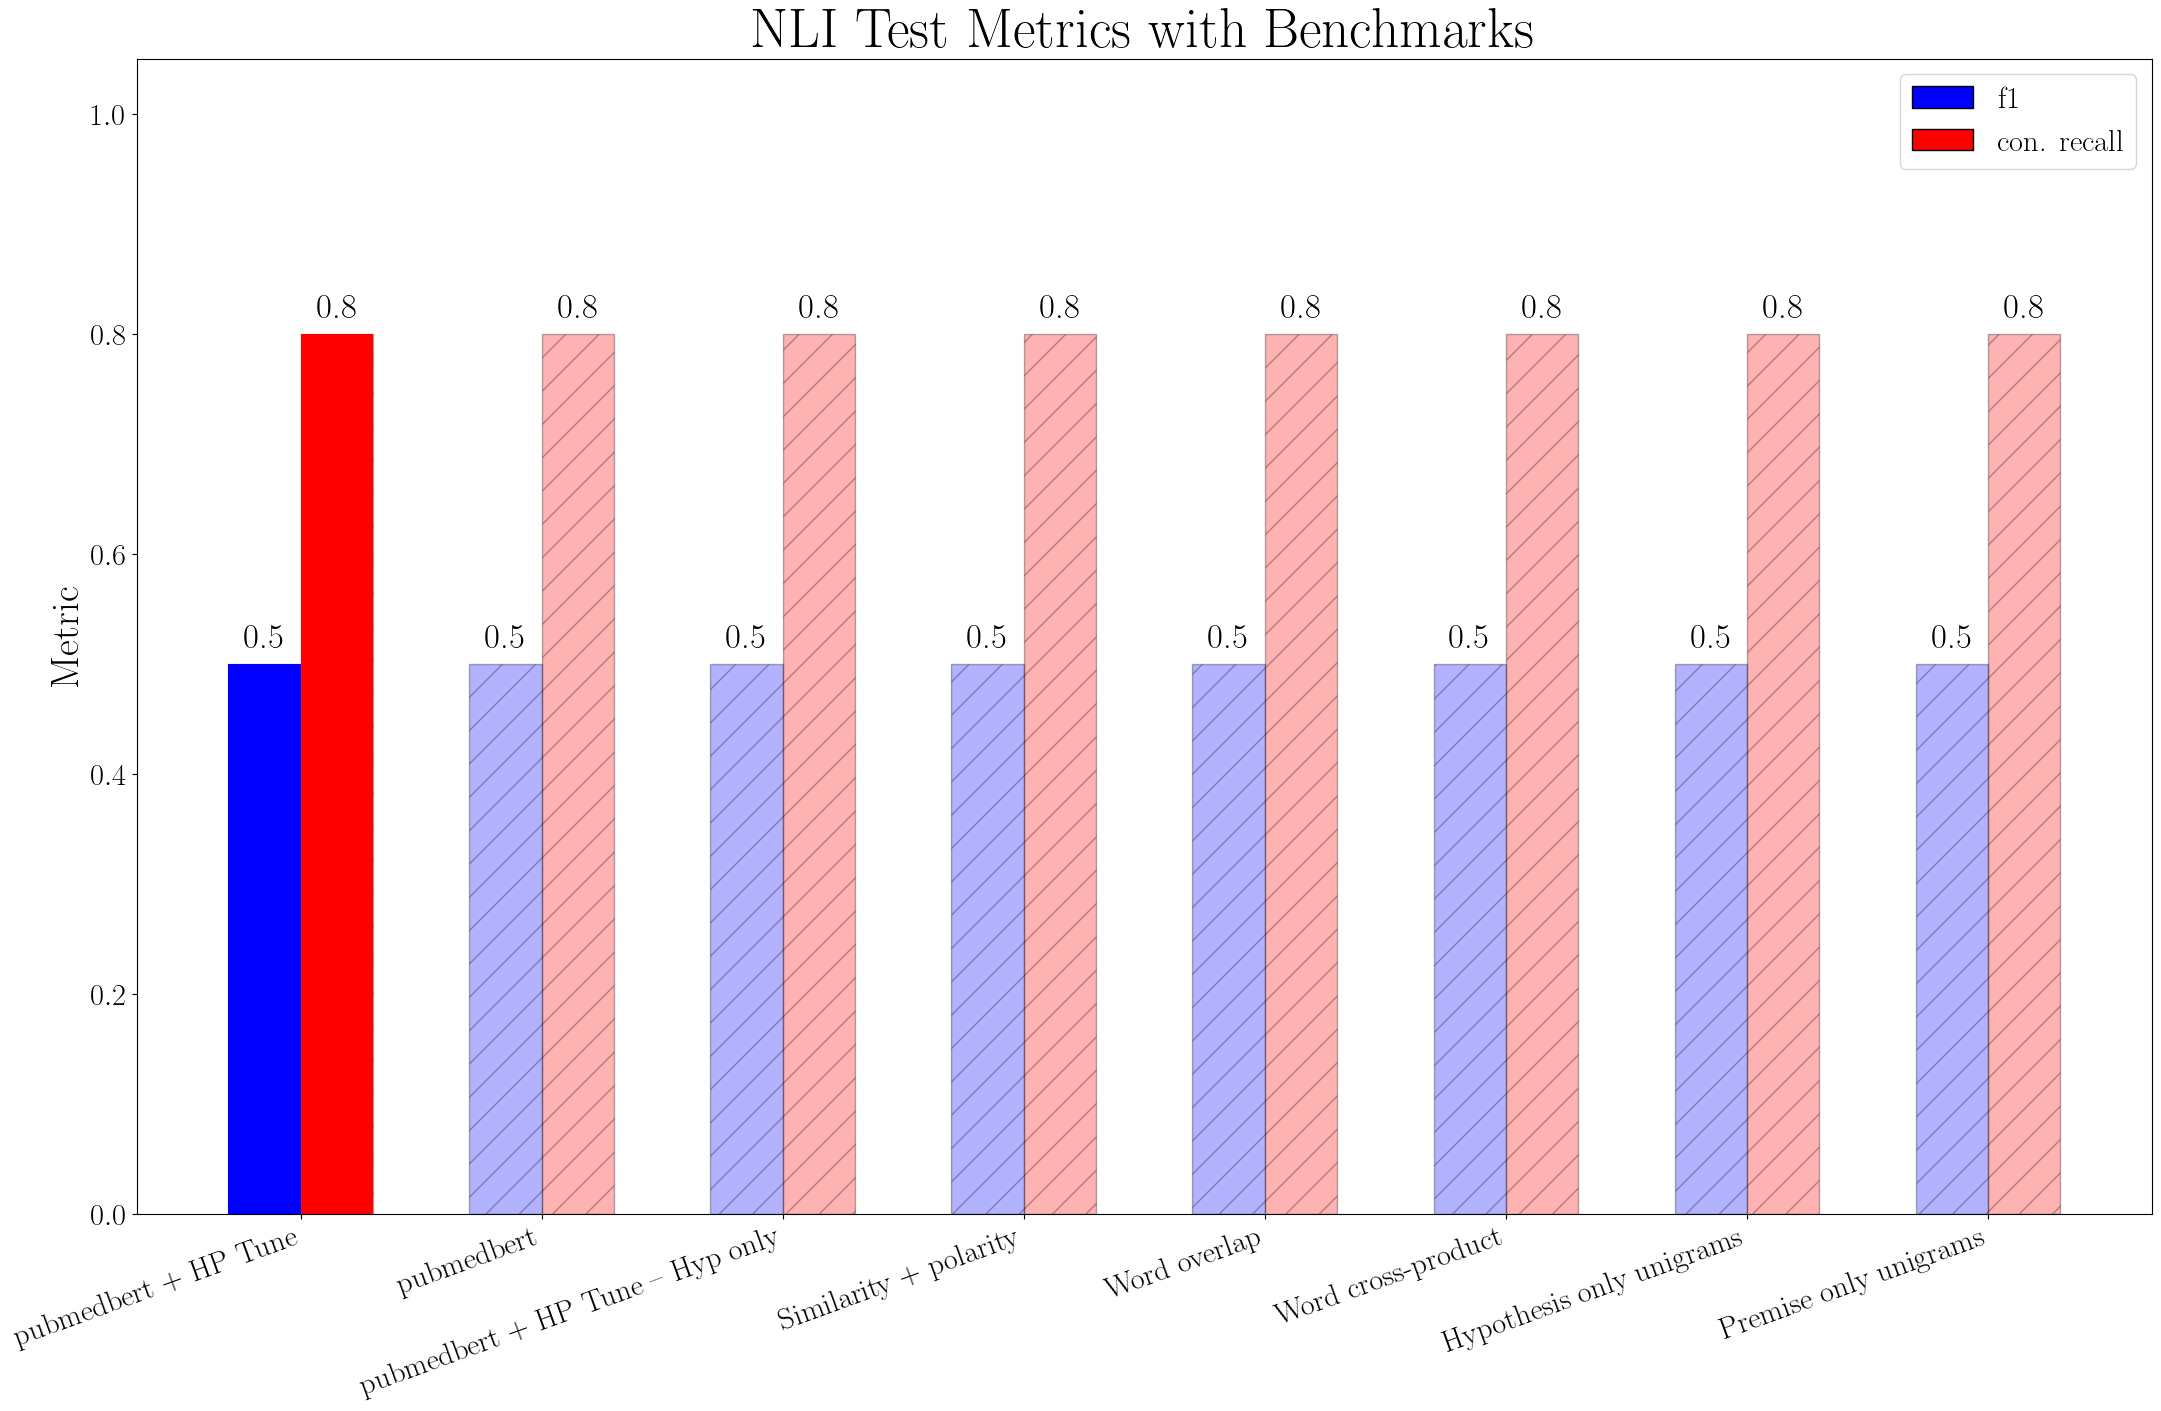

In [357]:
plot_benchmark_fig(final_results_df)